# Trabajo Práctico 2

## 1. Implemente un perceptrón simple que aprenda la función lógica AND y la función lógica OR, de 2 y de 4 entradas. Muestre la evolución del error durante el entrenamiento. Para el caso de 2 dimensiones, grafique la recta discriminadora y todos los vectores de entrada de la red.

## Entrenamiento de un perceptrón con historial de pesos por época

El siguiente código implementa un **perceptrón simple** con *bias* absorbido, diseñado para tareas lógicas como **AND / OR**, y permite registrar la evolución de los **pesos** y del **error cuadrático medio (ECM)** a lo largo de las épocas de entrenamiento.

---

### Descripción general

El perceptrón es un clasificador lineal binario que actualiza sus pesos cada vez que comete un error.  
En este caso, se usa un vector aumentado (incluyendo el *bias*) para simplificar la regla de actualización.

El flujo de entrenamiento es el siguiente:

1. Se inicializan los pesos de forma aleatoria según una distribución normal **N(0, 0.01)**.  
2. En cada época, se recorren todas las muestras (en orden fijo o aleatorio).  
3. Si una muestra está mal clasificada, se ajustan los pesos.  
4. Al final de cada época, se guarda el vector de pesos y el ECM.  
5. Si no hay errores en una época, el entrenamiento se detiene (convergencia).

---

### Funciones principales

- **step(h)**  
  Función de activación por signo. Devuelve +1 si la entrada es mayor o igual a 0, y -1 en caso contrario.

- **augment_with_bias(X)**  
  Agrega una columna de unos a la matriz de entradas `X`, de modo que el último peso del vector `w` actúe como *bias*.  
  Esto permite tratar el *bias* como un peso más.

- **forward_aug(X_aug, w_aug)**  
  Calcula la salida del perceptrón (ya con la entrada aumentada) aplicando el producto punto entre las entradas y los pesos, seguido de la función de activación `step`.

- **predict(X, w_aug)**  
  Facilita la predicción sobre datos sin aumentar. Internamente llama a `augment_with_bias` y `forward_aug`.

- **mse(y_true, y_pred)**  
  Calcula el **Error Cuadrático Medio (ECM)** entre las etiquetas verdaderas y las predicciones.  
  Este valor se usa como métrica de desempeño durante el entrenamiento.

---

### Función de entrenamiento

**train_perceptron_aug_with_history(X, y, eta, max_epochs, shuffle, random_state)**  

Entrena el perceptrón de manera **en línea** (muestra por muestra) y guarda el historial de pesos y ECM.

**Parámetros:**
- **X**: matriz de entrenamiento, donde cada fila es un patrón de entrada.  
- **y**: vector de etiquetas en {+1, -1}.  
- **eta**: tasa de aprendizaje (valor pequeño, como 0.1).  
- **max_epochs**: número máximo de épocas.  
- **shuffle**: si es True, mezcla las muestras en cada época.  
- **random_state**: semilla aleatoria opcional para reproducibilidad.

**Retorna:**
- **w_hist**: matriz con los pesos finales de cada época (incluyendo el bias).  
- **ecms**: lista con el ECM calculado en cada época.

---

#### Criterio de parada

El entrenamiento se detiene de forma anticipada (**early stopping**) si en una época no hay errores de clasificación, lo que indica que el conjunto es linealmente separable.

---




In [1]:
import numpy as np
import matplotlib.pyplot as plt

def step(h: np.ndarray) -> np.ndarray:
    """Signo: +1 si h>=0, -1 si h<0."""
    return np.where(h >= 0, 1, -1)

def augment_with_bias(X: np.ndarray) -> np.ndarray:
    """Agrega una columna de 1s: X -> [X | 1]. El último peso es el bias."""
    X = np.asarray(X, dtype=float)
    ones = np.ones((X.shape[0], 1), dtype=float)
    return np.hstack([X, ones])

def forward_aug(X_aug: np.ndarray, w_aug: np.ndarray) -> np.ndarray:
    """Salida del perceptrón con X """
    return step(X_aug @ w_aug)

def predict(X: np.ndarray, w_aug: np.ndarray) -> np.ndarray:
    """Predice a partir de X (no aumentada)."""
    return forward_aug(augment_with_bias(X), w_aug)

def mse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """ECM sobre etiquetas en {+1,-1}."""
    y_true = np.asarray(y_true)
    return float(np.mean((y_true - y_pred) ** 2))

# -------------------------
# Entrenamiento con HISTORIAL por ÉPOCA
# -------------------------
def train_perceptron_aug_with_history(
    X: np.ndarray,
    y: np.ndarray,
    eta: float = 0.1,
    max_epochs: int = 100,
    shuffle: bool = False,
    random_state: int | None = None,
):
    rng = np.random.default_rng(random_state)
    X_aug = augment_with_bias(X)
    y = np.asarray(y, dtype=int)

    w_aug = rng.normal(0, 0.01, size=X_aug.shape[1])

    w_hist = []
    ecms = []

    for _ in range(max_epochs):
        if shuffle:
            idx = rng.permutation(len(X_aug))
            Xe, ye = X_aug[idx], y[idx]
        else:
            Xe, ye = X_aug, y

        mistakes = 0
        for xi, ti in zip(Xe, ye):
            if step(xi @ w_aug) != ti:
                w_aug += eta * ti * xi
                mistakes += 1

        # log de fin de época SIEMPRE
        w_hist.append(w_aug.copy())
        ecms.append(mse(y, forward_aug(X_aug, w_aug)))

        if mistakes == 0:  # early stop si separó perfecto
            break

    return np.array(w_hist), np.array(ecms)


### Funciones para generar datos, graficar y ejecutar experimentos

**`dataset_gate(gate="AND", dim=2)`**  
Genera el conjunto de datos correspondiente a la compuerta lógica elegida (**AND** u **OR**).  
Para `dim=2`, el dataset es:

- **Entradas:**  
  $X = \{(0,0), (0,1), (1,0), (1,1)\}$

- **Salidas:**  
  - **AND:** $y = \{-1, -1, -1, +1\}$  
  - **OR:** $y = \{-1, +1, +1, +1\}$

Para `dim=4`, genera todas las combinaciones binarias de 4 bits (16 patrones), con salidas análogas para **AND** y **OR**.

---

**`plot_boundary_on_ax(ax, w_aug)`**  
Dibuja la **frontera de decisión** del perceptrón en el eje `ax` a partir del vector de pesos aumentado  
$w_{\text{aug}} = [w_1, w_2, w_b]$, donde $w_b$ es el *bias*.  
La ecuación de la recta de decisión es:

$$
w_1 x_1 + w_2 x_2 + w_b = 0
\quad \Rightarrow \quad
x_2 = -\frac{w_1 x_1 + w_b}{w_2}
$$

Si $w_2 = 0$, la frontera es vertical ($x_1 = -w_b / w_1$).

---

**`annotate_points(ax, X, y)`**  
Dibuja los puntos del conjunto de datos `X` y los colorea según su clase.  
Además, agrega etiquetas de texto con los valores de salida (+1 o −1).  
Incluye ejes y cuadrícula para facilitar la lectura.

---

**`run_experiment_for_gate(gate, etas, max_epochs, shuffle, random_state)`**  
Ejecuta un experimento completo para una compuerta lógica determinada (**AND** u **OR**) y una lista de tasas de aprendizaje.

Para cada valor de **η (eta)** realiza los siguientes pasos:

1. **Entrena** el perceptrón con `train_perceptron_aug_with_history`, obteniendo:  
   - El historial de pesos por época (`w_hist`).  
   - El error cuadrático medio (`ecms`) por época.  

2. **Grafica el ECM vs. época** para visualizar la convergencia del entrenamiento.

3. **Muestra la evolución de la frontera de decisión** en un panel de subgráficos, uno por cada época, para observar cómo el perceptrón ajusta su frontera a lo largo del entrenamiento.

El procedimiento permite comparar distintas tasas de aprendizaje y visualizar cómo influyen en la **velocidad de convergencia** y en la **estabilidad del entrenamiento**.


In [2]:
def dataset_gate(gate: str = "AND", dim: int = 2):
    g = gate.strip().lower()
    if dim == 2:
        X = np.array([[0,0],[0,1],[1,0],[1,1]], dtype=float)
        if g == "and":
            y = np.array([-1,-1,-1, 1], dtype=int)
        elif g == "or":
            y = np.array([-1, 1, 1, 1], dtype=int)
        else:
            raise ValueError("gate debe ser 'AND' u 'OR'")
        return X, y
    elif dim == 4:
        X = np.array([[int(b) for b in f"{i:04b}"] for i in range(16)], dtype=float)
        if g == "and":
            y = np.array([-1]*15 + [1], dtype=int)
        elif g == "or":
            y = np.array([-1] + [1]*15, dtype=int)
        else:
            raise ValueError("gate debe ser 'AND' u 'OR'")
        return X, y
    else:
        raise ValueError("dim debe ser 2 o 4")


def plot_boundary_on_ax(ax, w_aug, eps: float = 1e-12):
    """Dibuja la frontera de decisión en el eje ax dado w_aug."""
    w1, w2, wb = w_aug
    x_vals = np.linspace(-0.2, 1.2, 200)
    if abs(w2) > eps:
        y_vals = -(w1 * x_vals + wb) / w2
        ax.plot(x_vals, y_vals, linewidth=2)
    elif abs(w1) > eps:
        ax.axvline(x=-wb / w1, linewidth=2)


def annotate_points(ax, X, y):
    """Plotea puntos y etiquetas de clase."""
    X_pos = X[y == 1]; X_neg = X[y == -1]
    ax.scatter(X_pos[:,0], X_pos[:,1], label="+1")
    ax.scatter(X_neg[:,0], X_neg[:,1], label="-1")
    for pt, lab in zip(X, y):
        ax.annotate(str(int(lab)), (pt[0]+0.02, pt[1]+0.02), fontsize=9)
    ax.set_xlim(-0.2, 1.2); ax.set_ylim(-0.2, 1.2)
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xlabel("$x_1$"); ax.set_ylabel("$x_2$")
    ax.grid(True)

def run_experiment_for_gate(
    gate: str = "AND",
    etas = (0.01, 0.05, 0.1, 0.5, 1.0),
    max_epochs: int = 100,
    shuffle: bool = False,
    random_state: int = 42,
):
    """
    Para la compuerta 'gate' entrena con cada eta, grafica:
      (1) ECM vs. época y (2) evolución lateral de la frontera por época.
    Requiere train_perceptron_aug_with_history(X,y,eta,...) definido previamente.
    """
    X, y = dataset_gate(gate)
    for eta in etas:
        w_hist, ecms = train_perceptron_aug_with_history(
            X, y, eta=eta, max_epochs=max_epochs, shuffle=shuffle, random_state=random_state
        )

        xs = np.arange(1, len(ecms)+1)
        plt.figure(figsize=(5,3))
        if len(ecms) == 1:
            plt.scatter(xs, ecms, s=60)
        else:
            plt.plot(xs, ecms, marker='o')
        plt.xlabel("Época"); plt.ylabel("ECM")
        plt.title(f"ECM por época – {gate.upper()} (2) – η={eta}")
        plt.grid(True)
        plt.show()

        n_ep = len(w_hist)
        fig, axes = plt.subplots(1, n_ep, figsize=(3*n_ep, 3), sharex=True, sharey=True)
        if n_ep == 1:
            axes = [axes]

        for i, ax in enumerate(axes, start=1):
            annotate_points(ax, X, y)
            plot_boundary_on_ax(ax, w_hist[i-1])
            ax.set_title(f"época {i}")
            if i == 1:
                ax.legend(loc="upper left", frameon=True)

        fig.suptitle(f"{gate.upper()} (2) – evolución de la frontera – η={eta}", y=1.05, fontsize=12)
        plt.tight_layout()
        plt.show()


Analizamos **exclusivamente la compuerta lógica AND (2 entradas)**: entrenamos un perceptrón, registramos el **ECM por época** y mostramos, **para cada** $\eta$, dos gráficos: (1) **ECM vs. época** y (2) la **evolución de la recta discriminadora** *epoch a epoch*. (No se usa OR en este bloque.)


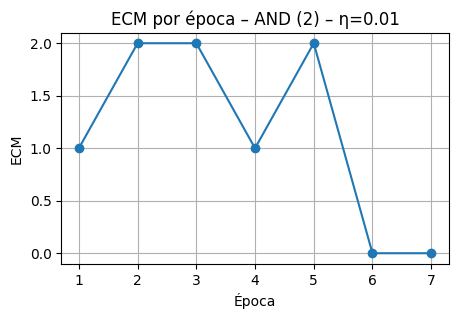

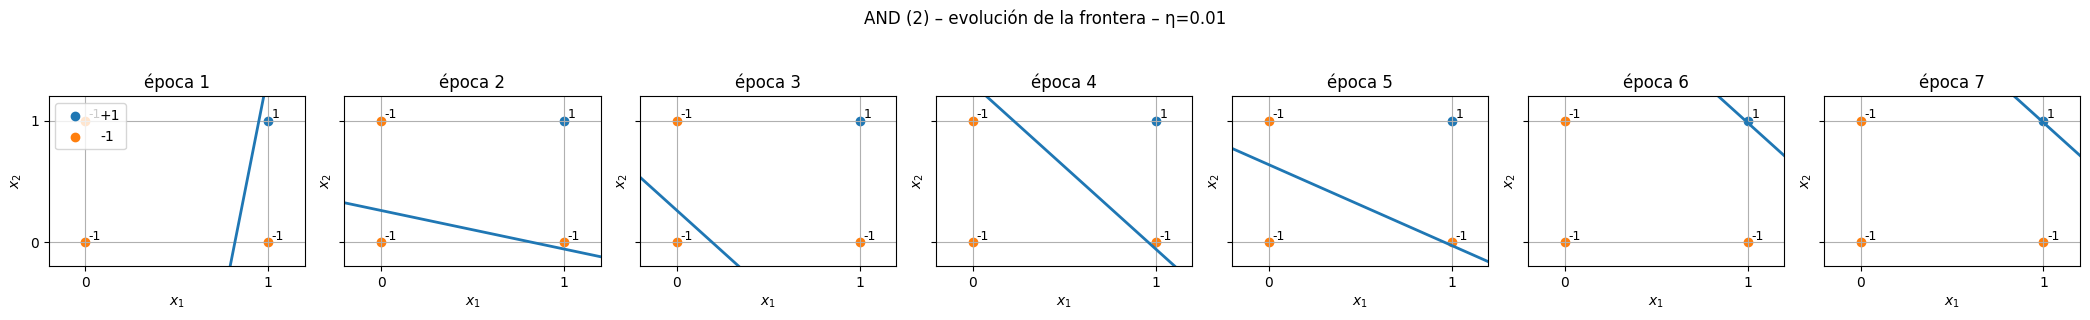

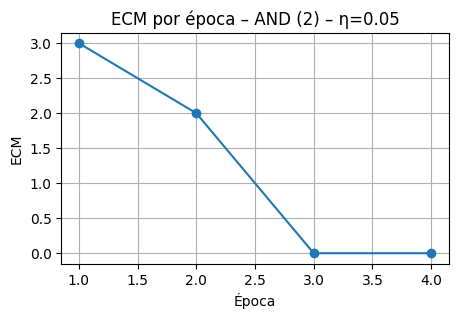

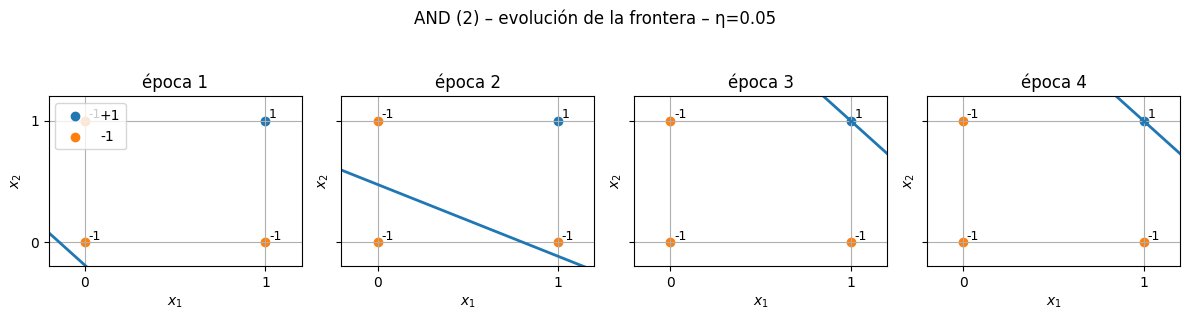

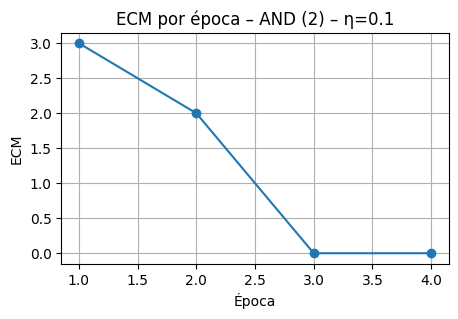

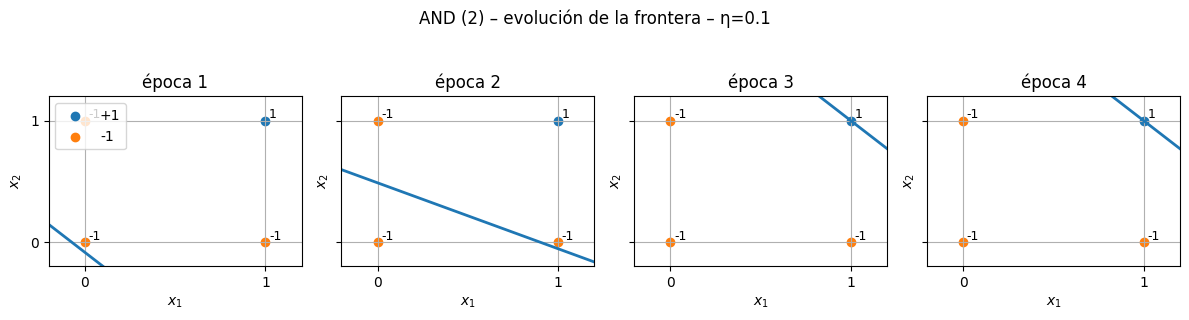

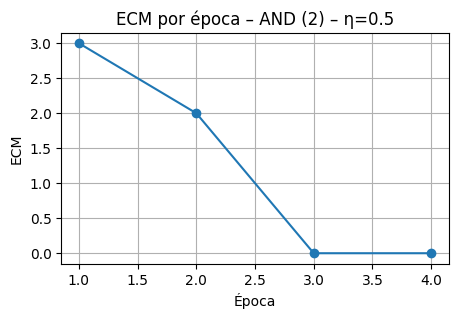

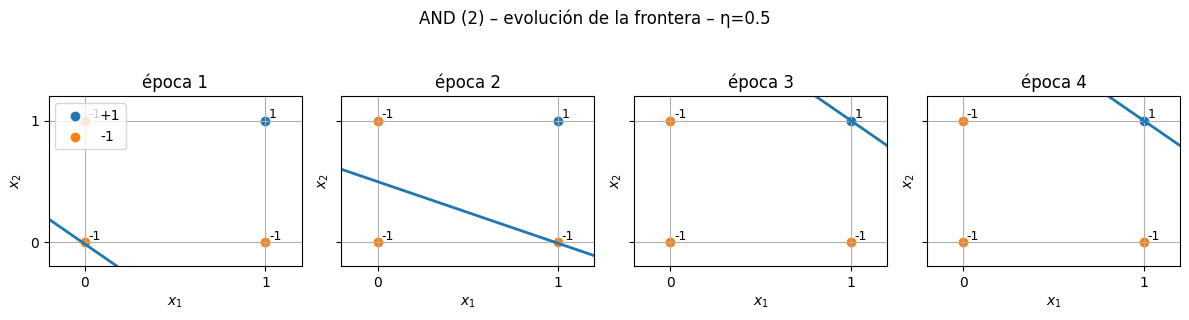

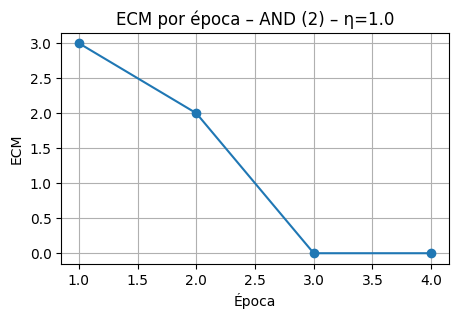

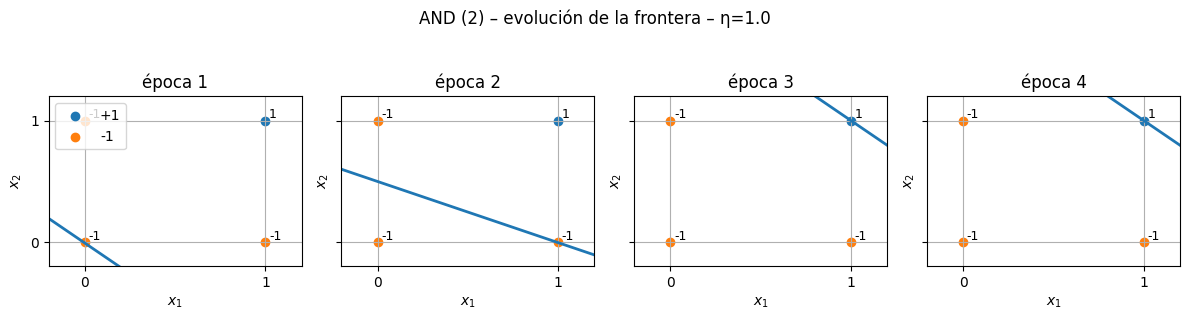

In [3]:
run_experiment_for_gate("AND", etas=[0.01, 0.05, 0.1, 0.5, 1.0], max_epochs=100, shuffle=False, random_state=42)


Analizamos **exclusivamente la compuerta lógica OR (2 entradas)**: entrenamos un perceptrón, registramos el **ECM por época** y mostramos, **para cada** $\eta$, dos gráficos: (1) **ECM vs. época** y (2) la **evolución de la recta discriminadora** *epoch a epoch*.  
Datos usados: $X\in\{0,1\}^2$ y $y=\{-1,\; +1,\; +1,\; +1\}$. (No se usa AND en este bloque.)


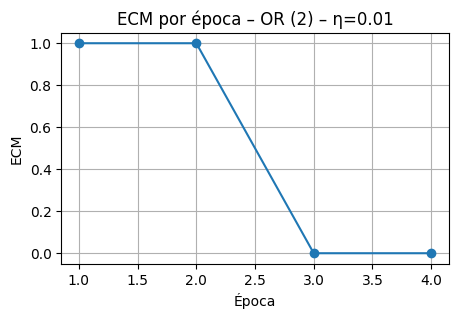

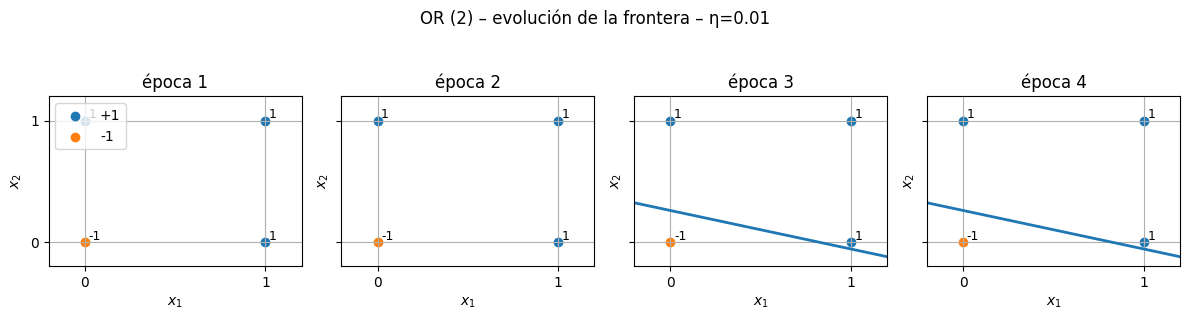

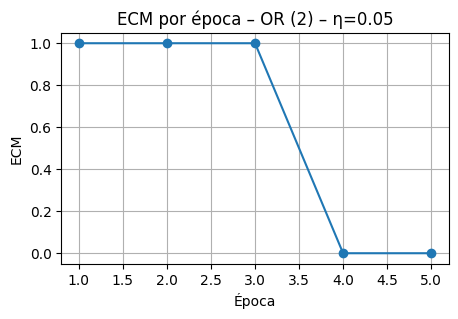

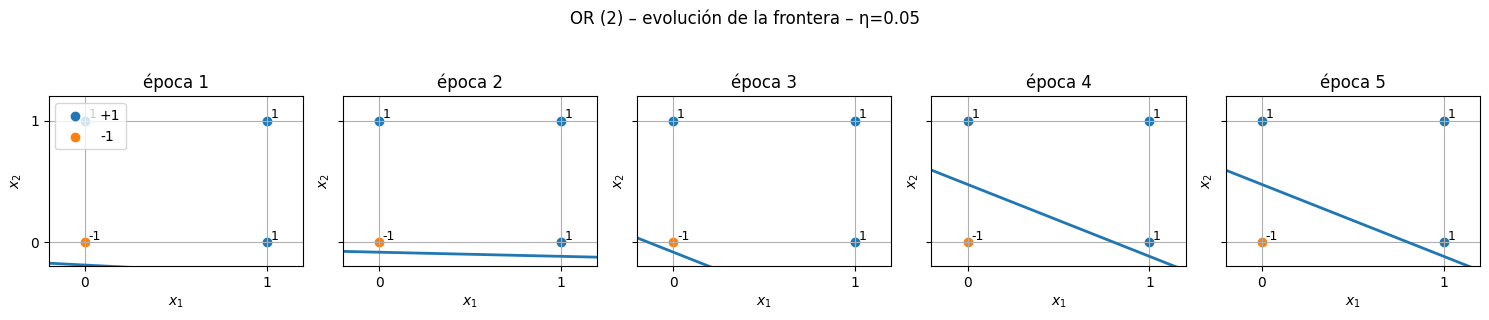

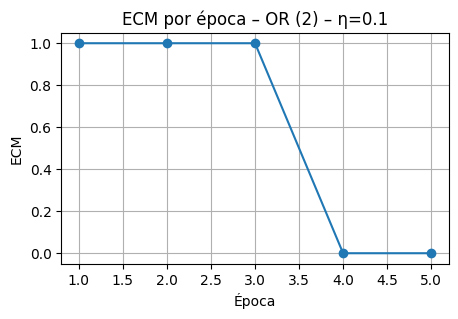

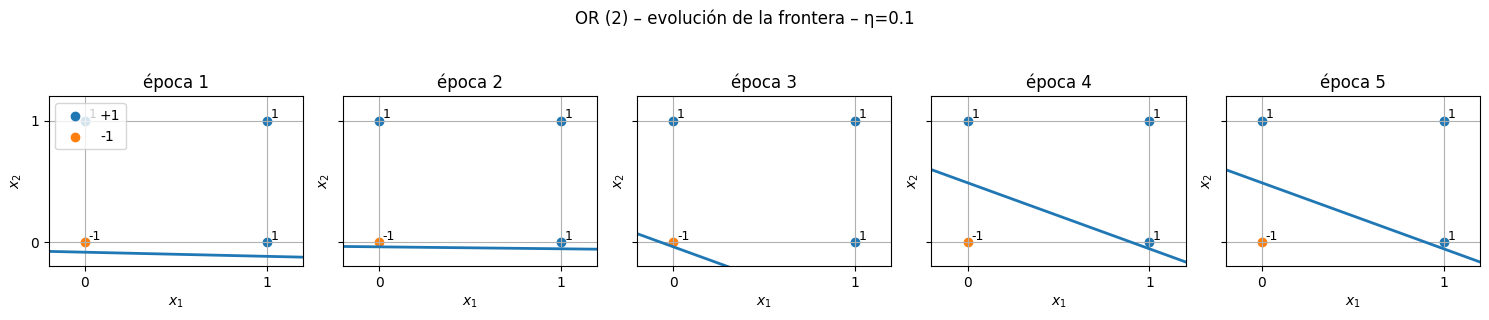

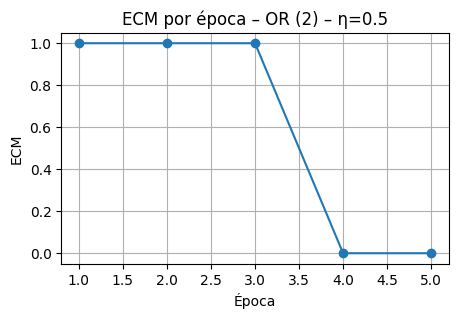

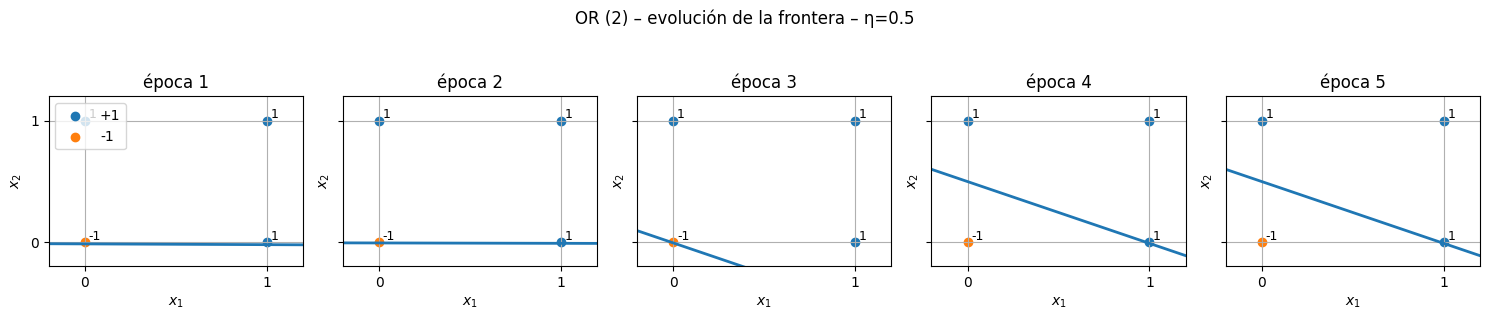

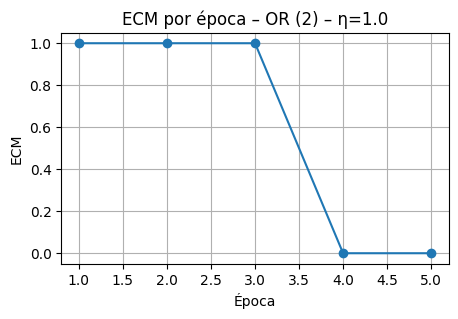

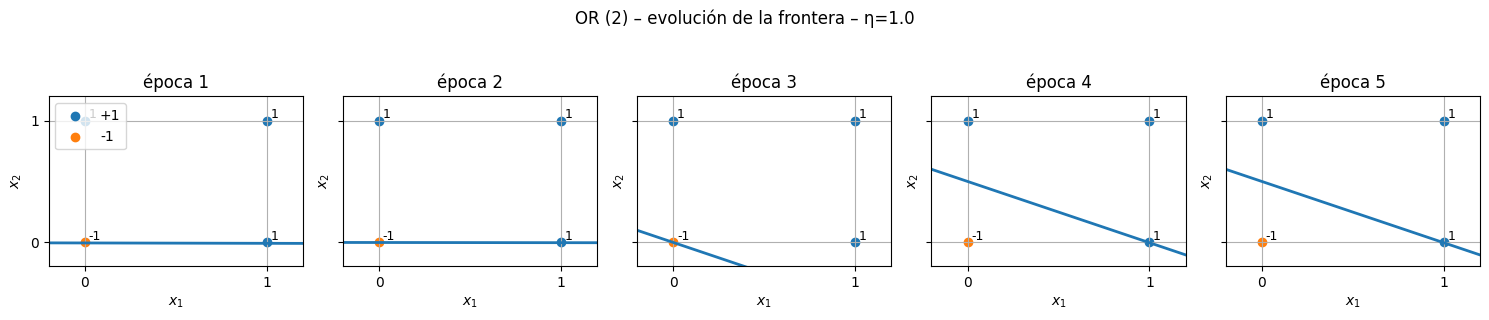

In [4]:
run_experiment_for_gate("OR", etas=[0.01, 0.05, 0.1, 0.5, 1.0], max_epochs=100, shuffle=False, random_state=42)


# 2. Determine numéricamente cómo varía la capacidad del perceptrón simple en función del número de patrones enseñados.

## Experimento de Capacidad del Perceptrón Simple

El objetivo es estimar **cuántos patrones aleatorios puede aprender un perceptrón simple con $N$ entradas**.  
La idea central es que el perceptrón solo puede resolver problemas **linealmente separables**, es decir, aquellos donde existe un hiperplano en $\mathbb{R}^N$ que divide perfectamente a las dos clases.

---

### Metodología del experimento

1. **Generación de problemas aleatorios:**  
   - Se eligen $N$ (número de entradas) y $N_p$ (número de patrones).  
   - Cada patrón es un vector $x \in [-1,1]^N$ generado al azar.  
   - A cada patrón se le asigna una etiqueta $y \in \{-1,+1\}$ también al azar.

2. **Entrenamiento del perceptrón:**  
   - Se entrena con regla del perceptrón clásico hasta un máximo de épocas.  
   - Se considera que el problema fue **aprendido** solo si el perceptrón logra error de entrenamiento exactamente 0:
     $$
     \forall i,\;\; \hat{y}_i = y_i
     $$

3. **Estimación de la fracción aprendida:**  
   - Se repite el procedimiento muchas veces (trials independientes).  
   - Se calcula:
     $$
     \text{frac}(N_p) \;=\; \frac{\# \text{problemas aprendidos}}{\text{trials}}
     $$

4. **Curvas de capacidad:**  
   - Para cada $N$, se varía $N_p$ desde 1 hasta un múltiplo de $N$ (por ejemplo, $5N$).  
   - Se grafica la fracción aprendida en función de $N_p$.  

---

### Qué vamos a medir

- Eje $x$: número de patrones $N_p$.  
- Eje $y$: fracción de problemas aprendidos (probabilidad de separabilidad lineal).  

El resultado son curvas que empiezan en 1 (pocos patrones casi siempre separables) y decaen hacia 0 (muchos patrones casi nunca separables).  
El **punto medio** ($N_p^*$) se toma como la **capacidad empírica del perceptrón**, definida como el número de patrones que puede aprender en promedio.

---

### Resultado esperado

Según la teoría clásica (Cover, 1965), la capacidad está en torno a:
$$
N_p^* \;\approx\; 2N
$$

Es decir, un perceptrón simple puede aprender, en promedio, hasta aproximadamente el **doble de patrones que la cantidad de entradas** antes de que la probabilidad de éxito caiga al 50%.


In [5]:
def _predict_from_w(X, w_aug):
    """Predicción {+1,-1} usando vector aumentado y pesos finales."""
    Xa = augment_with_bias(X)
    return np.where(Xa @ w_aug >= 0, 1, -1)

def _trial_learned_once(N: int, Np: int, eta=0.1, max_epochs=200, rng=None) -> bool:
    """
    Un problema aleatorio continuo:
      - X ~ U([-1,1]^N) de tamaño Np
      - y ∈ {-1,+1} al azar
    Entrena perceptrón; True si clasifica 100% en training.
    """
    if rng is None:
        rng = np.random.default_rng()
    X = rng.uniform(-1.0, 1.0, size=(Np, N))
    y = rng.choice([-1, 1], size=Np)

    # random_state distinto por trial (para inicialización)
    rs = int(rng.integers(0, 1_000_000))
    w_hist, _ = train_perceptron_aug_with_history(
        X, y, eta=eta, max_epochs=max_epochs, shuffle=False, random_state=rs
    )
    yhat = _predict_from_w(X, w_hist[-1])
    return bool(np.all(yhat == y))

def capacity_sweep(Ns, k_factor=5, trials=100, eta=0.1, max_epochs=500, seed=2025):
    """
    Para cada N y Np=1..k_factor*N, estima la fracción de problemas
    aprendidos (linealmente separables) por el perceptrón.
    Devuelve: dict N -> (Np_values, frac_learned)
    """
    rng_master = np.random.default_rng(seed)
    results = {}
    for N in Ns:
        Np_vals = np.arange(1, k_factor * N + 1)
        fracs = np.empty_like(Np_vals, dtype=float)
        for j, Np in enumerate(Np_vals):
            success = 0
            for _ in range(trials):
                rng = np.random.default_rng(int(rng_master.integers(0, 1_000_000)))
                success += _trial_learned_once(N, int(Np), eta=eta, max_epochs=max_epochs, rng=rng)
            fracs[j] = success / trials
        results[N] = (Np_vals, fracs)
    return results

def half_capacity_point(Np_vals, fracs):
    """Np* donde la fracción está más cerca de 0.5 (estimación de capacidad)."""
    idx = int(np.argmin(np.abs(fracs - 0.5)))
    return int(Np_vals[idx]), float(fracs[idx])


## Experimento ejecutado: Capacidad empírica del perceptrón simple

En este bloque de código variamos **la dimensión del perceptrón ($N$)** y el número de **trials** (repeticiones del experimento aleatorio) para estimar de manera robusta la capacidad.

---

### Configuración usada

- **Dimensiones comparadas ($N$):** $2, 4, 8, 20, 30$  
- **Cantidad de patrones probados ($N_p$):** desde 1 hasta $5 \cdot N$ (con `k_factor=5`).  
- **Tasa de aprendizaje:** $\eta = 0.1$  
- **Épocas máximas:** 500  
- **Semilla aleatoria:** 2854  
- **Número de trials:** $50$, $100$ y $500$

---

### Qué se midió

1. Para cada $N$ y cada $N_p$, se generaron problemas aleatorios con entradas continuas en $[-1,1]^N$ y salidas en $\{-1,+1\}$.  
2. Se entrenó un perceptrón simple y se contó como **aprendido** solo si alcanzó **error de entrenamiento 0**.  
3. Se repitió el procedimiento varias veces (`trials`) y se calculó la **fracción de problemas aprendidos**:
   $$
   \text{frac}(N_p) \;=\; \frac{\# \text{problemas aprendidos}}{\text{trials}}
   $$
4. Se graficó la curva $\text{frac}(N_p)$ para cada $N$ y se marcó con una línea roja punteada la referencia teórica en $2N$.  

---

### Resultados esperados

- Las curvas comienzan cerca de 1 (cuando $N_p$ es chico, casi siempre son separables).  
- A medida que $N_p$ aumenta, la fracción de problemas aprendidos cae hacia 0.  
- El punto medio ($N_p^*$, donde la fracción ≈ 0.5) aparece aproximadamente en $2N$, confirmando la predicción teórica de que la capacidad del perceptrón simple es cercana al doble de la dimensión de entrada.

---



=== TRIALS = 10 ===


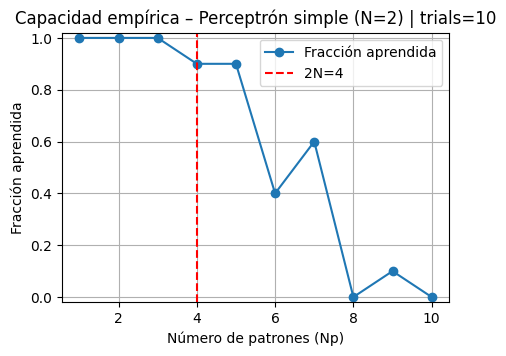

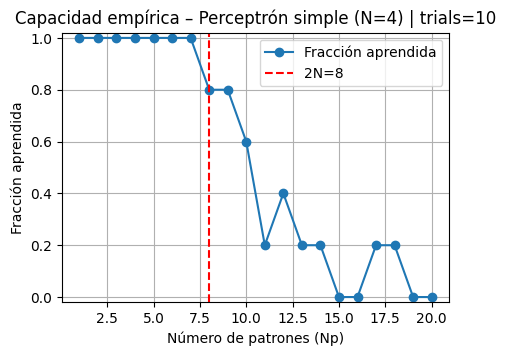

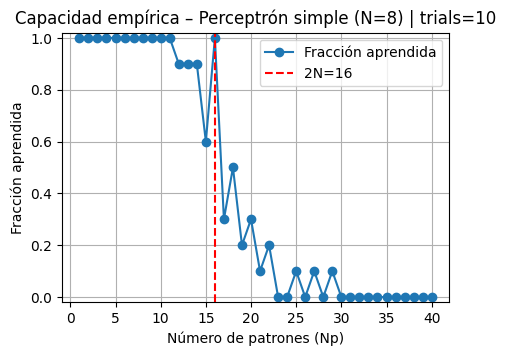

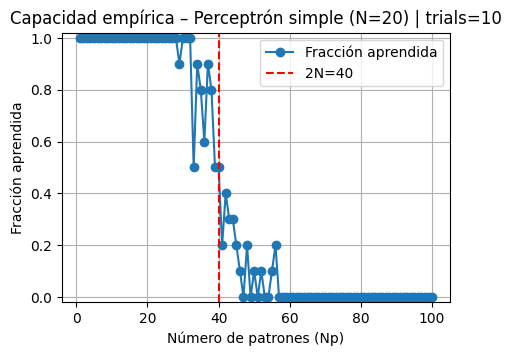

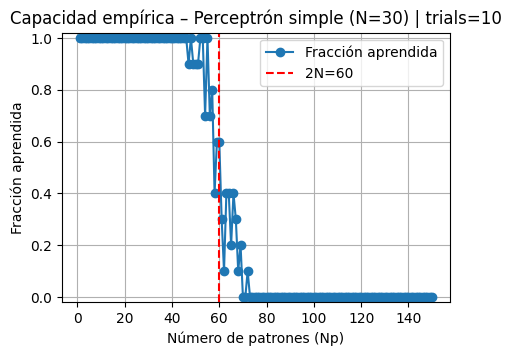

Np* (aprox. fracción≈0.5) por N:
  N=2: Np*≈6 (fracción=0.40)
  N=4: Np*≈10 (fracción=0.60)
  N=8: Np*≈18 (fracción=0.50)
  N=20: Np*≈33 (fracción=0.50)
  N=30: Np*≈58 (fracción=0.40)

=== TRIALS = 50 ===


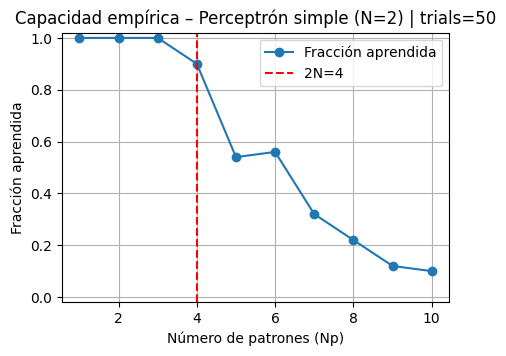

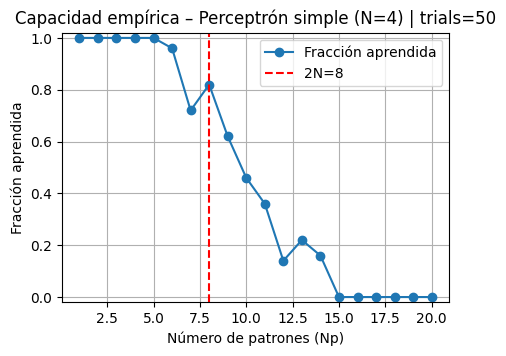

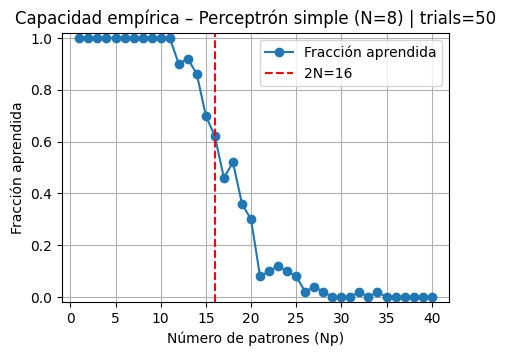

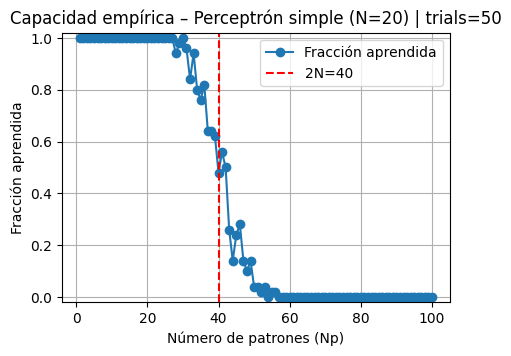

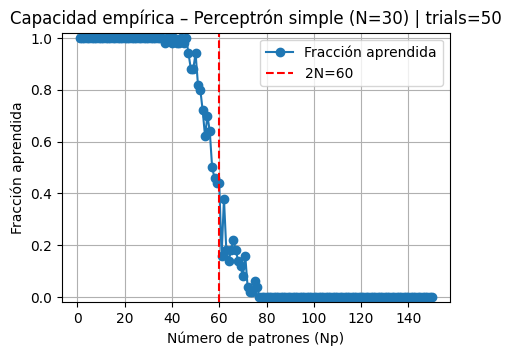

Np* (aprox. fracción≈0.5) por N:
  N=2: Np*≈5 (fracción=0.54)
  N=4: Np*≈10 (fracción=0.46)
  N=8: Np*≈18 (fracción=0.52)
  N=20: Np*≈42 (fracción=0.50)
  N=30: Np*≈57 (fracción=0.50)

=== TRIALS = 100 ===


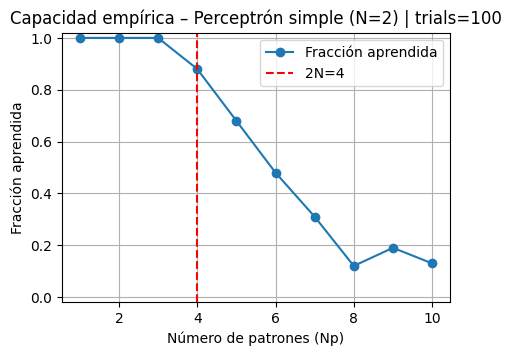

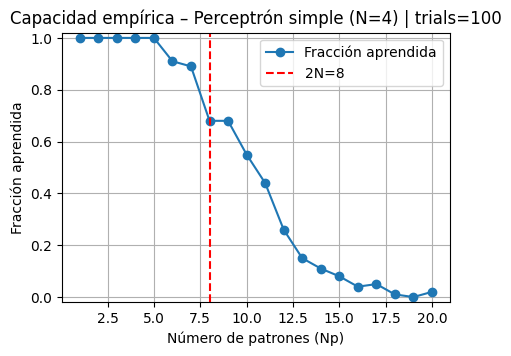

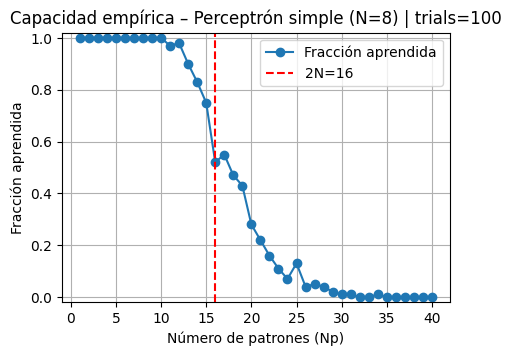

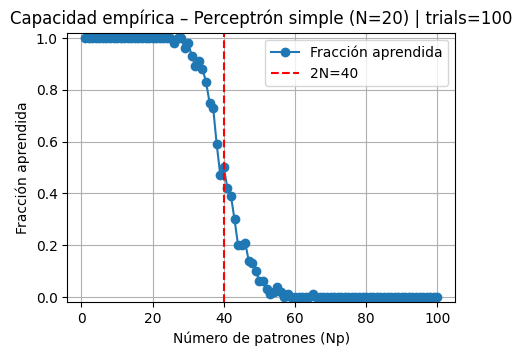

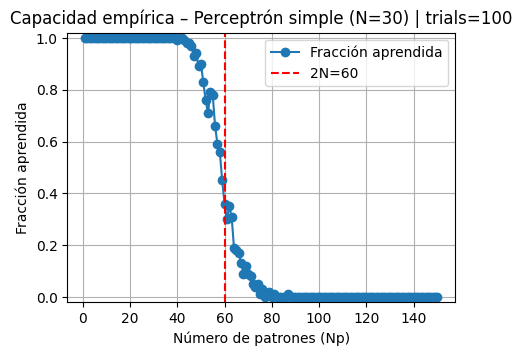

Np* (aprox. fracción≈0.5) por N:
  N=2: Np*≈6 (fracción=0.48)
  N=4: Np*≈10 (fracción=0.55)
  N=8: Np*≈16 (fracción=0.52)
  N=20: Np*≈40 (fracción=0.50)
  N=30: Np*≈59 (fracción=0.45)

=== TRIALS = 500 ===


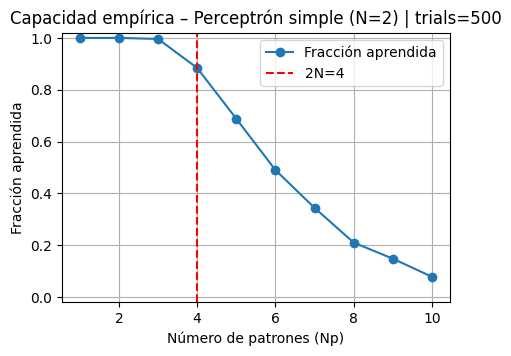

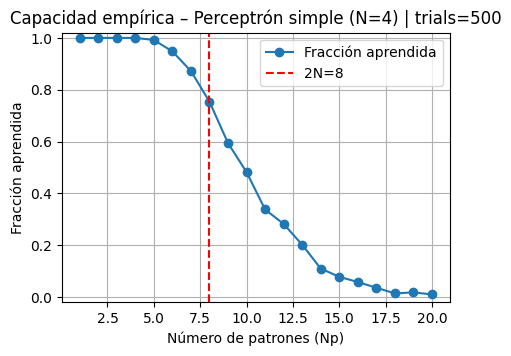

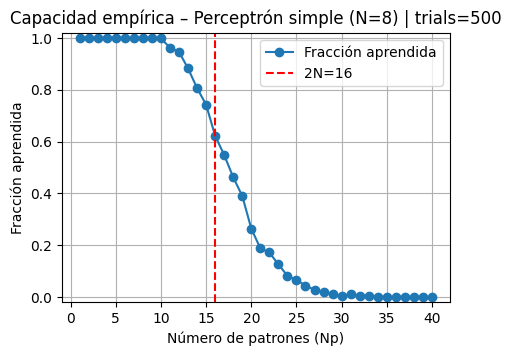

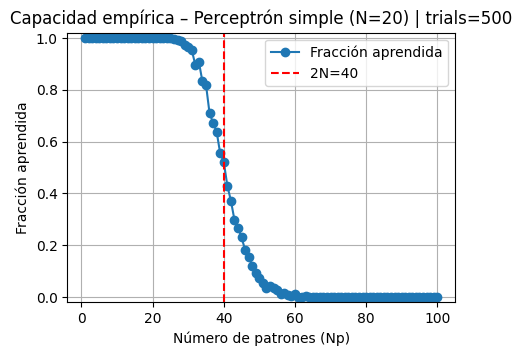

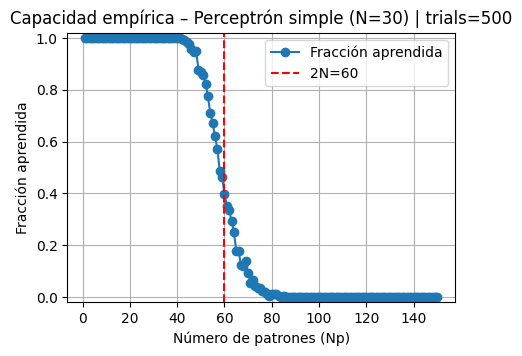

Np* (aprox. fracción≈0.5) por N:
  N=2: Np*≈6 (fracción=0.49)
  N=4: Np*≈10 (fracción=0.48)
  N=8: Np*≈18 (fracción=0.46)
  N=20: Np*≈40 (fracción=0.52)
  N=30: Np*≈58 (fracción=0.49)


In [6]:
# Config global
Ns         = (2, 4, 8, 20, 30)     # dimensiones a comparar
k_factor   = 5             # Np max = k_factor * N
eta        = 0.1
max_epochs = 500
seed       = 2854
trials_list = [10, 50, 100, 500]

for trials in trials_list:
    print(f"\n=== TRIALS = {trials} ===")
    results = capacity_sweep(
        Ns=Ns, k_factor=k_factor, trials=trials,
        eta=eta, max_epochs=max_epochs, seed=seed
    )

    # Plots por N
    for N, (Np_vals, fracs) in results.items():
        plt.figure(figsize=(5,3.5))
        plt.plot(Np_vals, fracs, marker='o', label="Fracción aprendida")

        # --- MARCA en 2N ---
        plt.axvline(2*N, color="red", linestyle="--", label=f"2N={2*N}")

        plt.xlabel("Número de patrones (Np)")
        plt.ylabel("Fracción aprendida")
        plt.title(f"Capacidad empírica – Perceptrón simple (N={N}) | trials={trials}")
        plt.ylim(-0.02, 1.02)
        plt.grid(True)
        plt.legend()
        plt.show()

    # Resumen de Np* (fracción ≈ 0.5)
    print("Np* (aprox. fracción≈0.5) por N:")
    for N, (Np_vals, fracs) in results.items():
        Np_star, frac = half_capacity_point(Np_vals, fracs)
        print(f"  N={N}: Np*≈{Np_star} (fracción={frac:.2f})")


# 3. Implemente un perceptrón multicapa que aprenda la función lógica XOR de 2 y de 4 entradas (utilizando el algoritmo Backpropagation y actualizando en batch). Muestre cómo evoluciona el error durante el entrenamiento. 

Este código implementa una red neuronal multicapa (MLP)

### 1. **Funciones de Activación**

Las funciones de activación son fundamentales para introducir no linealidad en el modelo, lo que le permite aprender representaciones complejas. El código soporta las siguientes funciones de activación:

- **Sigmoid**: 
  $$ \sigma(x) = \frac{1}{1 + e^{-x}} $$
  - La salida es entre 0 y 1. Comúnmente usada para problemas de clasificación binaria.

- **Tanh**: 
  $$ \tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}} $$
  - La salida es entre -1 y 1, y es útil cuando se necesita que los valores estén centrados alrededor de 0.

- **ReLU (Rectified Linear Unit)**: 
  $$ \text{ReLU}(x) = \max(0, x) $$
  - Amplia la activación de las neuronas y es muy utilizada por su eficiencia computacional y su capacidad para evitar el desvanecimiento del gradiente.

- **Identidad (Linear)**: 
  $$ f(x) = x $$
  - Usada típicamente en la capa de salida para problemas de regresión, donde la salida puede ser cualquier número real.

Cada función tiene también su derivada correspondiente, que se usa durante el proceso de retropropagación (backpropagation).

### 2. **Inicialización de Pesos**

La **inicialización de los pesos** en redes neuronales es crucial para un buen entrenamiento. En este código, se utilizan dos métodos de inicialización de pesos:

- **Inicialización de Xavier/Glorot**: 
  Esta inicialización es adecuada para funciones de activación como **sigmoid**, **tanh** o **linear**. Los pesos se inicializan con una distribución uniforme con el siguiente límite:
  $$ \text{limite} = \sqrt{\frac{6}{\text{fan\_in} + \text{fan\_out}}} $$

- **Inicialización de He**: 
  Usada para **ReLU**. Se inicializan los pesos con una distribución normal con desviación estándar:
  $$ \text{std} = \sqrt{\frac{2}{\text{fan\_in}}} $$

En ambos casos, los **bias** se inicializan a 0.

### 3. **Red Neuronal Multicapa (MLP)**

La clase `MLP` representa una red neuronal multicapa con la posibilidad de tener múltiples capas ocultas y de salida. Esta clase permite realizar las siguientes operaciones:

3.1 **Forward Pass**

El **forward pass** calcula la salida de la red para una entrada dada. Para cada capa, la salida se calcula como:

$$
Z = A \cdot W + b
$$
donde $A$ es la activación de la capa anterior, $W$ es el peso de la capa actual, y $b$ es el bias.

La salida de cada capa se pasa a través de la función de activación correspondiente.

3.2 **Backward Pass (Retropropagación)**

En el **backpropagation**, se calculan los gradientes de los pesos y biases con respecto a la pérdida usando la regla de la cadena. La derivada de la función de activación se aplica a los errores para ajustar los pesos de la red.

La fórmula para calcular los gradientes de los pesos y biases es:

$$
\delta_i = g'(Z_i) \cdot (C_i - O_i)
$$
donde $\delta_i$ es el error de la capa $i$ , $g'(Z_i)$ es la derivada de la activación, y $C_i$ y $O_i$ son el valor objetivo y la salida de la red, respectivamente.

3.3 **Actualización de Pesos**

Después de calcular los gradientes, los pesos y biases se actualizan usando la regla de gradiente descendente. El aprendizaje es controlado por la tasa de aprendizaje ($\eta$):

$$
W_i = W_i - \eta \cdot \nabla W_i
$$
donde $\nabla W_i$ es el gradiente de los pesos.

### 4. **Entrenamiento (fit)**

El método `fit()` entrena la red utilizando **mini-batches**. Durante el entrenamiento, la red realiza un **forward pass**, calcula la pérdida, realiza el **backward pass** y actualiza los pesos con la regla de gradiente descendente. El error de la red se guarda durante cada época de entrenamiento, y el modelo se evalúa con un conjunto de validación si se proporciona.

- **Early Stopping**: Si se proporciona un conjunto de validación, el entrenamiento puede detenerse temprano si el error de validación deja de mejorar después de un número de épocas.

### 5. **Predicción**

El método `predict()` se utiliza para realizar predicciones usando el modelo entrenado. Devuelve la salida de la red para un conjunto de entradas.

### 6. **Clasificación**

El método `predict_classes()` devuelve las predicciones de clase para problemas de clasificación. Si la salida es binaria (solo una neurona en la capa de salida), usa un umbral (por defecto 0.5) para decidir si la clase es 0 o 1. Si la salida es de varias clases (una neurona por clase), toma la clase con la activación más alta.

---

Este código implementa una red neuronal completa con múltiples capas ocultas y de salida, y proporciona los elementos necesarios para entrenar y hacer predicciones en tareas de clasificación y regresión. La inicialización de los pesos y las funciones de activación juegan un papel clave en la eficiencia del entrenamiento y el rendimiento del modelo.


In [7]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# Utilidades: activaciones
# ------------------------------
class Activations:
    @staticmethod
    def sigmoid(x):
        # numéricamente estable
        x = np.clip(x, -60, 60)
        return 1.0 / (1.0 + np.exp(-x))

    @staticmethod
    def d_sigmoid(a):
        # derivada en función de la salida activada (a = sigmoid(x))
        return a * (1.0 - a)

    @staticmethod
    def tanh(x):
        # np.tanh ya es estable
        return np.tanh(x)

    @staticmethod
    def d_tanh(a):
        # derivada en función de la salida activada (a = tanh(x))
        return 1.0 - a**2

    @staticmethod
    def relu(x):
        return np.maximum(0.0, x)

    @staticmethod
    def d_relu(a):
        return (a > 0.0).astype(a.dtype)

    @staticmethod
    def identity(x):
        return x

    @staticmethod
    def d_identity(a):
        return np.ones_like(a)

ACTS = {
    "sigmoid": (Activations.sigmoid, Activations.d_sigmoid),
    "tanh":    (Activations.tanh,    Activations.d_tanh),
    "relu":    (Activations.relu,    Activations.d_relu),
    "linear":  (Activations.identity,Activations.d_identity),
    "identity":(Activations.identity,Activations.d_identity),
}

# ------------------------------
# Inicialización de pesos
# ------------------------------
def weight_init(fan_in, fan_out, act_name, rng):
    """
    Xavier (sigmoid/tanh/linear) o He (ReLU). Retorna W, b.
    """
    act = act_name.lower()
    if act in ("relu",):
        # He normal
        std = np.sqrt(2.0 / fan_in)
    else:
        # Xavier/Glorot uniforme
        limit = np.sqrt(6.0 / (fan_in + fan_out))
        W = rng.uniform(-limit, limit, size=(fan_in, fan_out))
        b = np.zeros((1, fan_out))
        return W, b

    W = rng.normal(0.0, std, size=(fan_in, fan_out))
    b = np.zeros((1, fan_out))
    return W, b

# ------------------------------
# MLP
# ------------------------------
class MLP:
    def __init__(
        self,
        layer_sizes,                          # lista: [n_in, h1, h2, ..., n_out]
        activations,                          # lista de nombres p/ cada capa no-lineal (len = len(layer_sizes)-1)
        seed=42,
        l2=0.0,
        learning_rate=0.05,
        clip_grad=None,                       # e.g. 5.0 para clipping global (norma)
        dtype=np.float64
    ):
        self.layer_sizes = layer_sizes
        self.activations = [a.lower() for a in activations]
        self.rng = np.random.default_rng(seed)
        self.l2 = float(l2)
        self.lr = float(learning_rate)
        self.clip_grad = clip_grad
        self.dtype = dtype

        # Pesos y biases
        self.W = []
        self.b = []
        for l in range(len(layer_sizes)-1):
            fan_in, fan_out = layer_sizes[l], layer_sizes[l+1]
            Wi, bi = weight_init(fan_in, fan_out, self.activations[l], self.rng)
            self.W.append(Wi.astype(dtype))
            self.b.append(bi.astype(dtype))

        # Cache para forward
        self._Z = []  # preactivaciones (linear)
        self._A = []  # activaciones (post g)

    # ---------- Forward ----------
    def forward(self, X, store_cache=True):
        A = X.astype(self.dtype, copy=False)
        if store_cache:
            self._Z = []
            self._A = [A]  # guardar entrada como A0
        for l, act_name in enumerate(self.activations):
            Z = A @ self.W[l] + self.b[l]              # (batch, fan_out)
            act, _ = ACTS[act_name]
            A = act(Z)
            if store_cache:
                self._Z.append(Z)
                self._A.append(A)
        return A

    # ---------- Pérdida (ECM) ----------
    @staticmethod
    def mse(y_true, y_pred):
        return 0.5 * np.mean((y_true - y_pred)**2)

    # ---------- Backprop ----------
    def backward(self, y_true, y_pred):
        batch = y_true.shape[0]
        deltas = [None] * len(self.W)
        dW = [None] * len(self.W)
        db = [None] * len(self.W)

        l = len(self.W) - 1
        _, d_act = ACTS[self.activations[l]]
        A_L = self._A[-1]
        dE_dA = (A_L - y_true) / batch
        delta = d_act(A_L) * dE_dA
        deltas[l] = delta
        dW[l] = self._A[l].T @ delta + self.l2 * self.W[l]   
        db[l] = np.sum(delta, axis=0, keepdims=True)

        for l in range(len(self.W)-2, -1, -1):
            _, d_act = ACTS[self.activations[l]]
            A_l = self._A[l+1]
            Z_l = self._Z[l]
            delta = (deltas[l+1] @ self.W[l+1].T) * d_act(A_l)
            deltas[l] = delta
            dW[l] = self._A[l].T @ delta + self.l2 * self.W[l]
            db[l] = np.sum(delta, axis=0, keepdims=True)

        if self.clip_grad is not None:
            total_norm = 0.0
            for g in dW + db:
                total_norm += np.sum(g*g)
            total_norm = np.sqrt(total_norm)
            if total_norm > self.clip_grad:
                factor = self.clip_grad / (total_norm + 1e-12)
                for i in range(len(dW)):
                    dW[i] *= factor
                    db[i] *= factor

        return dW, db

    # ---------- Update (SGD) ----------
    def step(self, dW, db):
        for i in range(len(self.W)):
            self.W[i] -= self.lr * dW[i]
            self.b[i] -= self.lr * db[i]

    def fit(self, X, y, epochs=2000, batch_size=32, shuffle=True, X_val=None, y_val=None, early_stopping=False, patience=50, verbose=True, log_every=50):
        X = X.astype(self.dtype, copy=False)
        y = y.astype(self.dtype, copy=False)
        
        if X.shape[0] != y.shape[0]:
            raise ValueError(f"Las dimensiones de X y y no coinciden: X tiene {X.shape[0]} muestras, y tiene {y.shape[0]} muestras.")
        
        n = X.shape[0]
        history = {"loss": [], "val_loss": []}
        
        for epoch in range(1, epochs + 1):
            if shuffle:
                idx = np.random.permutation(n)
                X, y = X[idx], y[idx]

            for start in range(0, n, batch_size):
                end = min(start + batch_size, n)  
                Xb = X[start:end]
                yb = y[start:end]

                y_pred = self.forward(Xb, store_cache=True)
                dW, db = self.backward(yb, y_pred)
                self.step(dW, db)

            train_pred = self.forward(X, store_cache=False)
            loss = self.mse(y, train_pred)
            history["loss"].append(loss)

            if X_val is not None and y_val is not None:
                val_pred = self.forward(X_val, store_cache=False)
                val_loss = self.mse(y_val, val_pred)
                history["val_loss"].append(val_loss)

            if early_stopping and val_loss is not None:
                if val_loss + 1e-12 < best_val:
                    best_val = val_loss
                    wait = 0
                    best_state = (
                        [Wi.copy() for Wi in self.W],
                        [bi.copy() for bi in self.b],
                    )
                else:
                    wait += 1
                    if wait >= patience:
                        if verbose:
                            print(f"Early stopping en epoch {epoch}. Mejor val_loss = {best_val:.6f}")
                        if best_state is not None:
                            self.W, self.b = best_state
                        break

            if verbose and (epoch % log_every == 0 or epoch == 1 or epoch == epochs):
                msg = f"[{epoch:4d}] loss={loss:.6f}"
                if val_loss is not None:
                    msg += f" | val_loss={val_loss:.6f}"
                print(msg)

            if early_stopping and wait >= patience:
                break

        return history

    # ---------- Predicción ----------
    def predict(self, X):
        return self.forward(X, store_cache=False)

    # ---------- Helpers para clasificación ----------
    def predict_classes(self, X, threshold=0.5):
        yhat = self.predict(X)
        if yhat.shape[1] == 1:
            return (yhat >= threshold).astype(int)
        else:
            return np.argmax(yhat, axis=1)


Entrenando con Red 2 -> 2 -> 1 (Sigmoid) - LR: 0.01...
Último error: 0.125635
Error promedio: 0.126168
Desviación estándar del error: 0.000377
La red no ha convergido completamente, puede ser necesario ajustar parámetros.


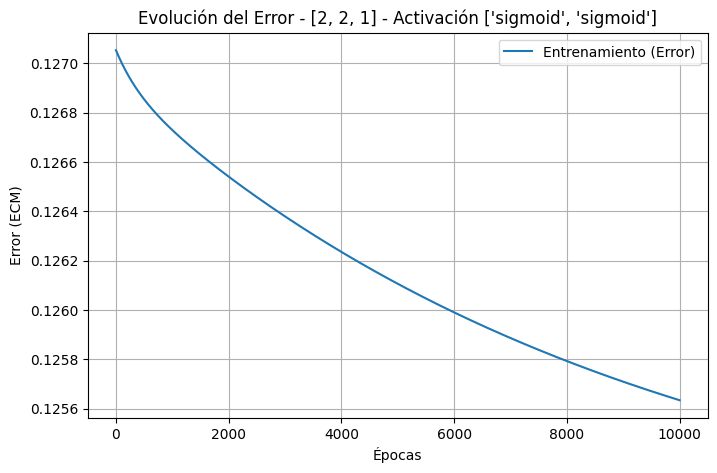

Entrenando con Red 2 -> 4 -> 1 (Sigmoid) - LR: 0.05...
Último error: 0.112105
Error promedio: 0.121430
Desviación estándar del error: 0.003596
La red no ha convergido completamente, puede ser necesario ajustar parámetros.


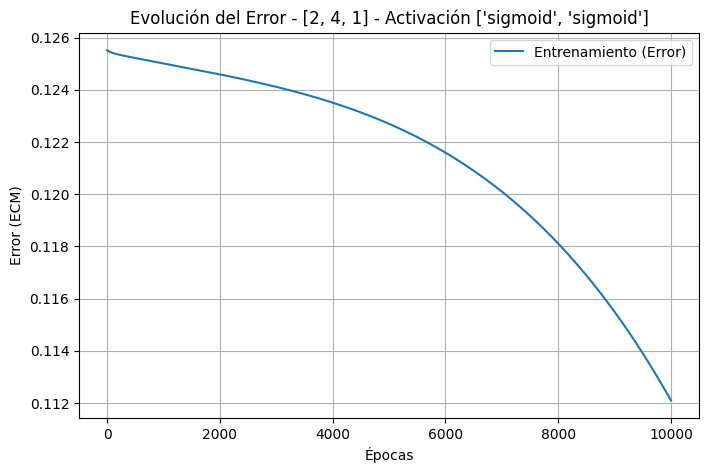

Entrenando con Red 2 -> 4 -> 4 -> 1 (Sigmoid) - LR: 0.1...
Último error: 0.123527
Error promedio: 0.124592
Desviación estándar del error: 0.000659
La red no ha convergido completamente, puede ser necesario ajustar parámetros.


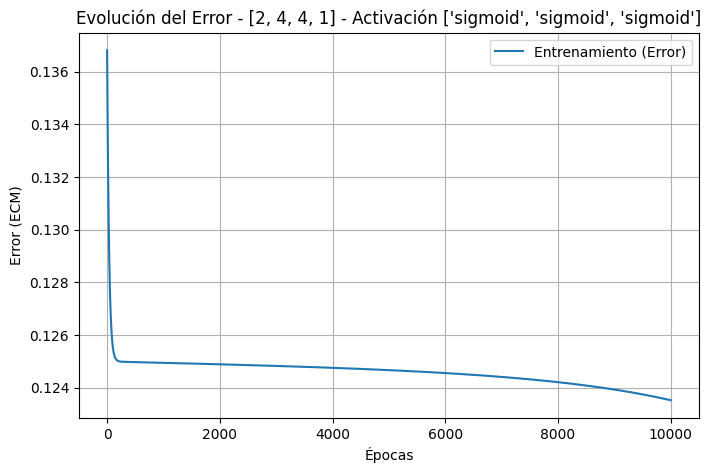

Entrenando con Red 2 -> 8 -> 8 -> 1 (Sigmoid) - LR: 0.1...
Último error: 0.124960
Error promedio: 0.125031
Desviación estándar del error: 0.000168
La red no ha convergido completamente, puede ser necesario ajustar parámetros.


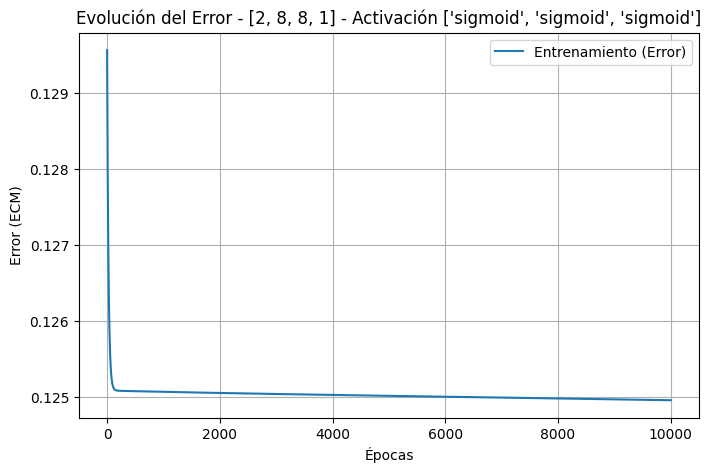

Entrenando con Red 2 -> 2 -> 1 (Sigmoid) - LR: 0.1...
Último error: 0.114477
Error promedio: 0.123620
Desviación estándar del error: 0.002687
La red no ha convergido completamente, puede ser necesario ajustar parámetros.


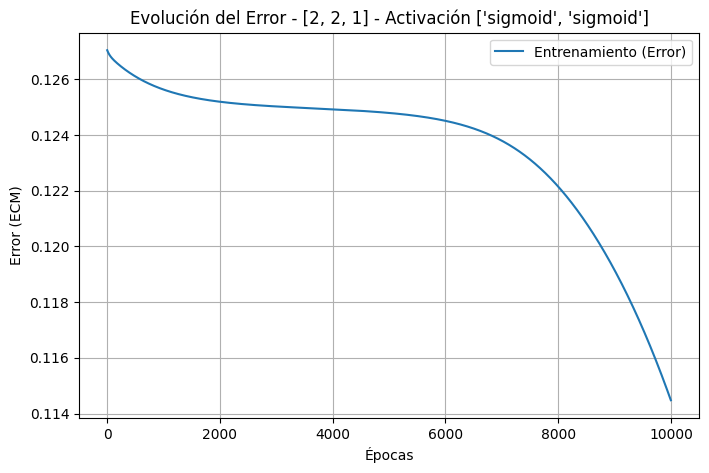

Entrenando con Red 2 -> 2 -> 1 (Tanh) - LR: 0.01...
Último error: 0.002957
Error promedio: 0.041051
Desviación estándar del error: 0.044363
La red parece haber convergido con éxito.


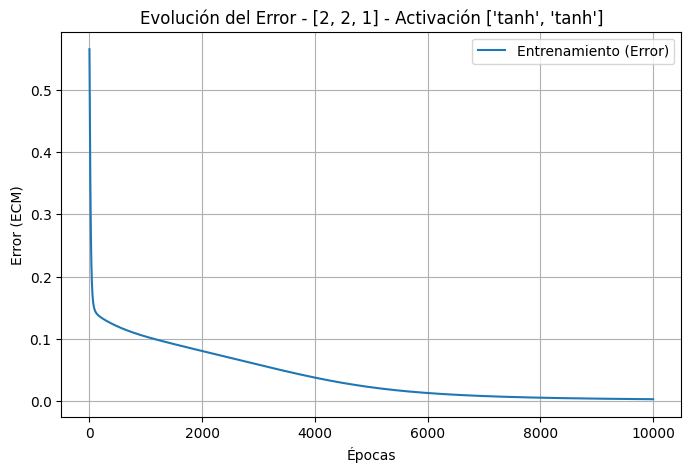

Entrenando con Red 2 -> 4 -> 1 (Tanh) - LR: 0.05...
Último error: 0.000212
Error promedio: 0.006412
Desviación estándar del error: 0.020126
La red parece haber convergido con éxito.


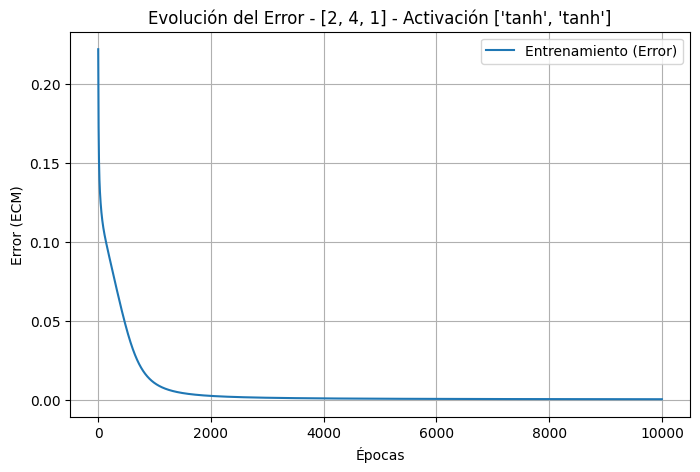

Entrenando con Red 2 -> 4 -> 4 -> 1 (Tanh) - LR: 0.05...
Último error: 0.000109
Error promedio: 0.005462
Desviación estándar del error: 0.020673
La red parece haber convergido con éxito.


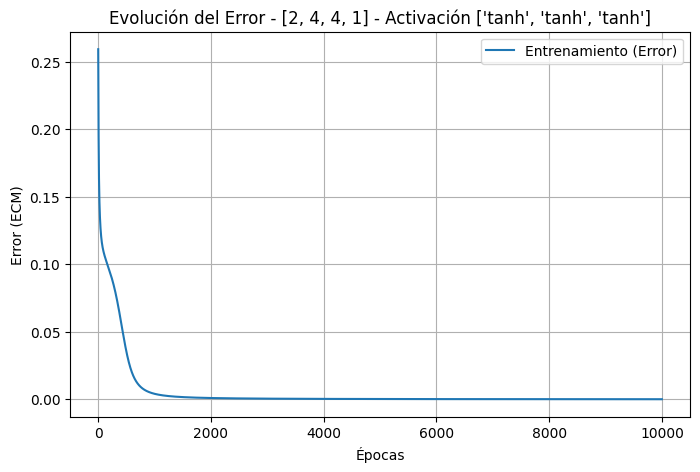

Entrenando con Red 2 -> 8 -> 8 -> 1 (Tanh) - LR: 0.1...
Último error: 0.000033
Error promedio: 0.002965
Desviación estándar del error: 0.015553
La red parece haber convergido con éxito.


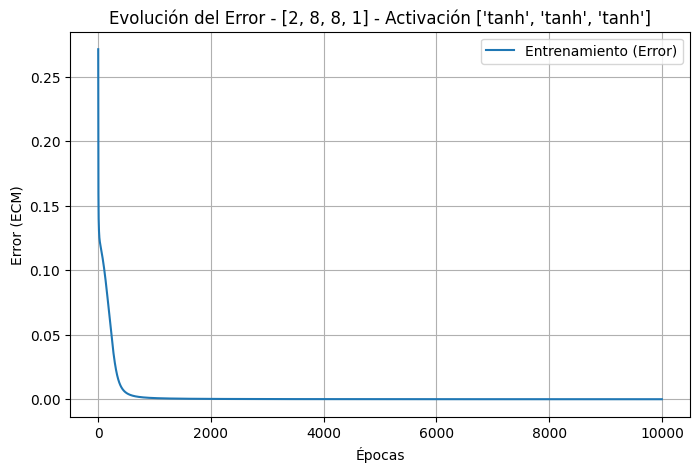

Entrenando con Red 2 -> 2 -> 1 (Tanh) - LR: 0.05...
Último error: 0.000183
Error promedio: 0.008680
Desviación estándar del error: 0.025346
La red parece haber convergido con éxito.


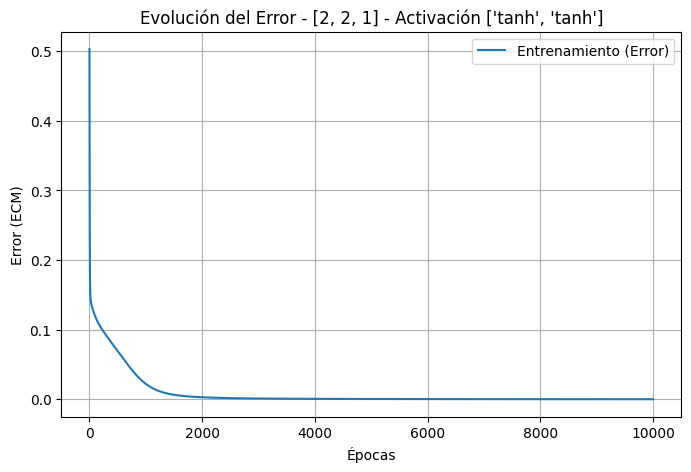

Entrenando con Red 4 -> 2 -> 1 (Sigmoid) - LR: 0.01...
Último error: 0.125165
Error promedio: 0.125491
Desviación estándar del error: 0.001253
La red no ha convergido completamente, puede ser necesario ajustar parámetros.


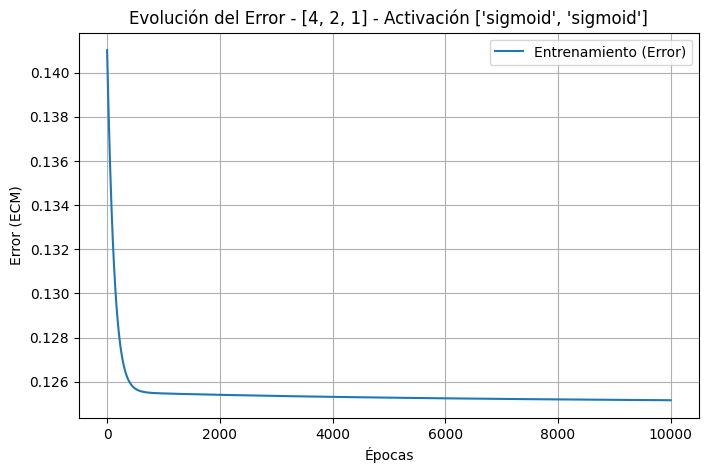

Entrenando con Red 4 -> 4 -> 1 (Sigmoid) - LR: 0.05...
Último error: 0.124998
Error promedio: 0.125074
Desviación estándar del error: 0.000099
La red no ha convergido completamente, puede ser necesario ajustar parámetros.


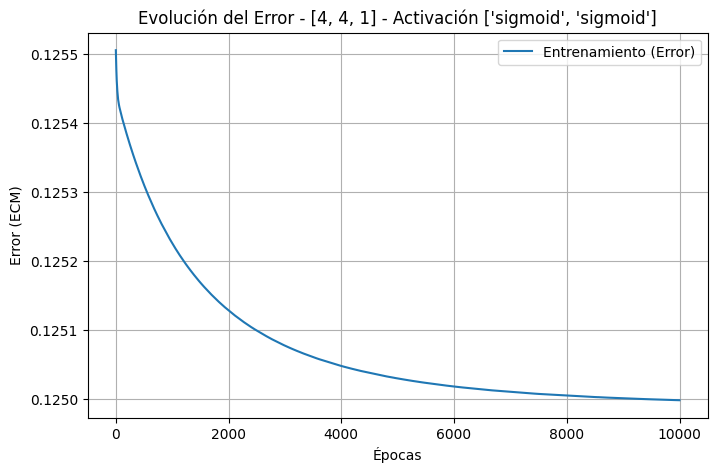

Entrenando con Red 4 -> 4 -> 4 -> 1 (Sigmoid) - LR: 0.1...
Último error: 0.125005
Error promedio: 0.125073
Desviación estándar del error: 0.000789
La red no ha convergido completamente, puede ser necesario ajustar parámetros.


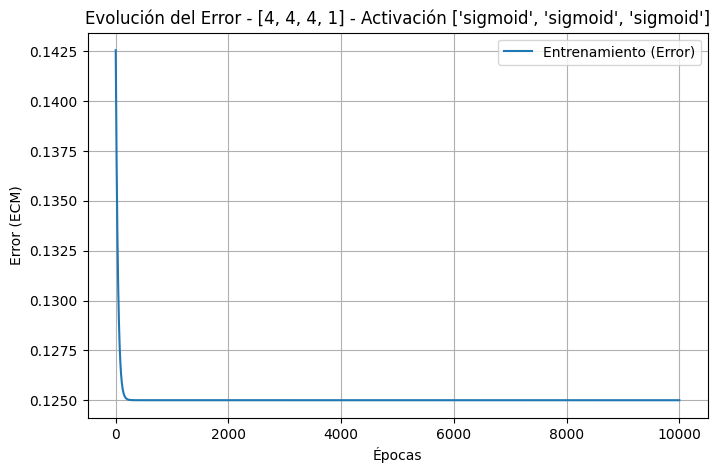

Entrenando con Red 4 -> 8 -> 8 -> 1 (Sigmoid) - LR: 0.1...
Último error: 0.125004
Error promedio: 0.125014
Desviación estándar del error: 0.000086
La red no ha convergido completamente, puede ser necesario ajustar parámetros.


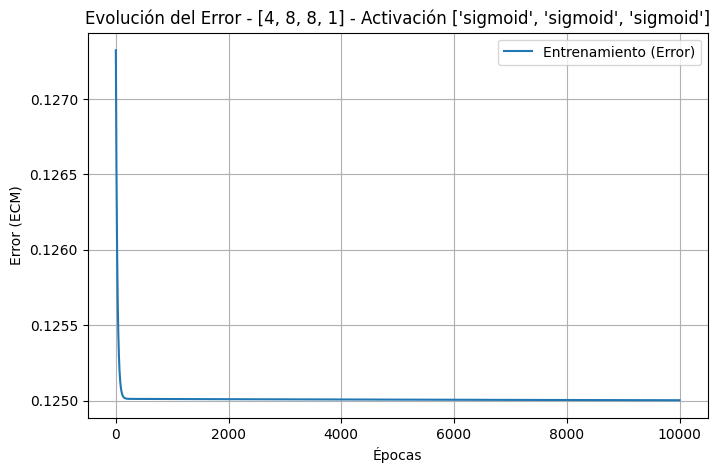

Entrenando con Red 4 -> 2 -> 1 (Sigmoid) - LR: 0.1...
Último error: 0.125052
Error promedio: 0.125252
Desviación estándar del error: 0.000810
La red no ha convergido completamente, puede ser necesario ajustar parámetros.


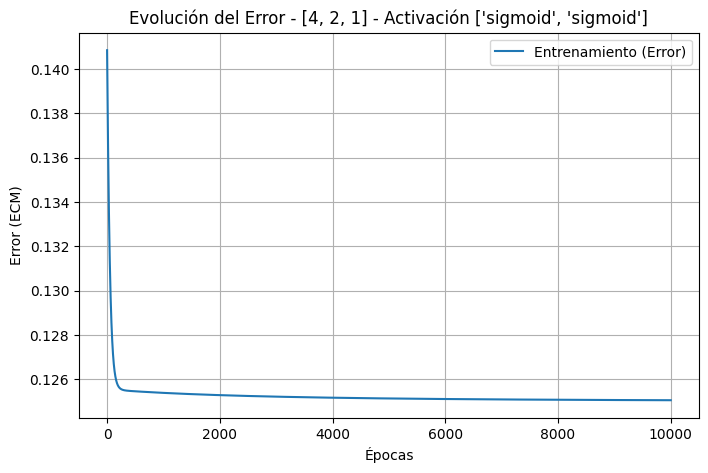

Entrenando con Red 4 -> 2 -> 1 (Tanh) - LR: 0.01...
Último error: 0.124979
Error promedio: 0.125937
Desviación estándar del error: 0.011308
La red no ha convergido completamente, puede ser necesario ajustar parámetros.


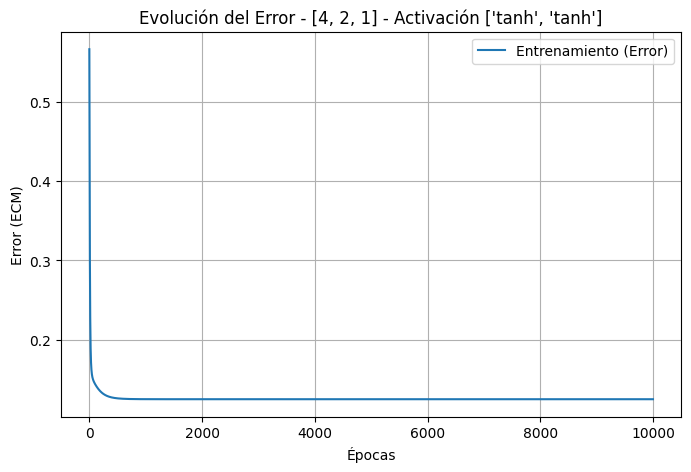

Entrenando con Red 4 -> 4 -> 1 (Tanh) - LR: 0.05...
Último error: 0.000591
Error promedio: 0.024980
Desviación estándar del error: 0.036485
La red parece haber convergido con éxito.


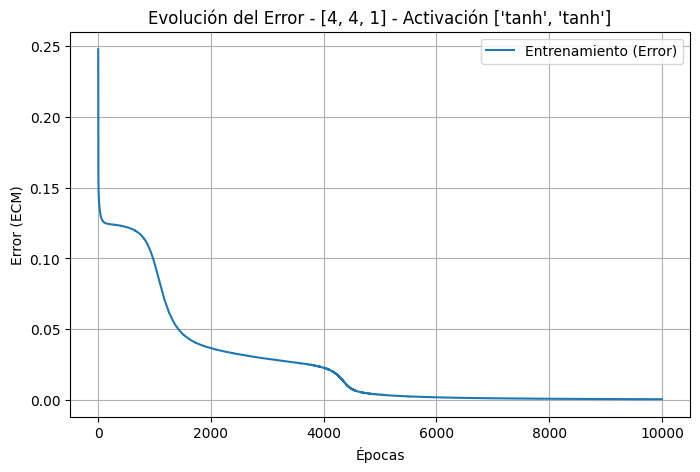

Entrenando con Red 4 -> 4 -> 4 -> 1 (Tanh) - LR: 0.1...
Último error: 0.000148
Error promedio: 0.026943
Desviación estándar del error: 0.046153
La red parece haber convergido con éxito.


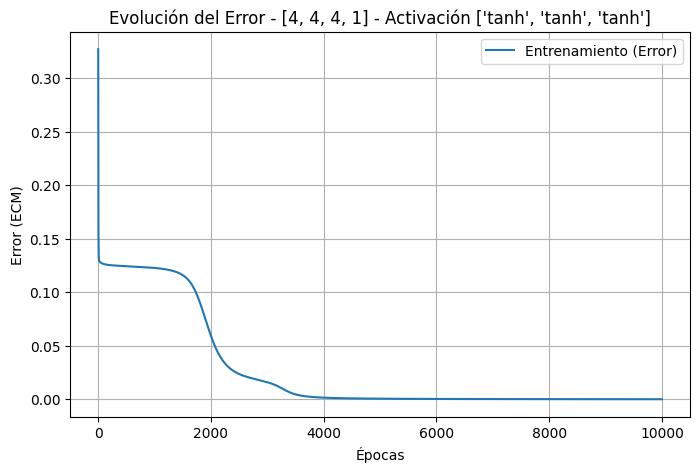

Entrenando con Red 4 -> 8 -> 8 -> 1 (Tanh) - LR: 0.1...
Último error: 0.000104
Error promedio: 0.014973
Desviación estándar del error: 0.032234
La red parece haber convergido con éxito.


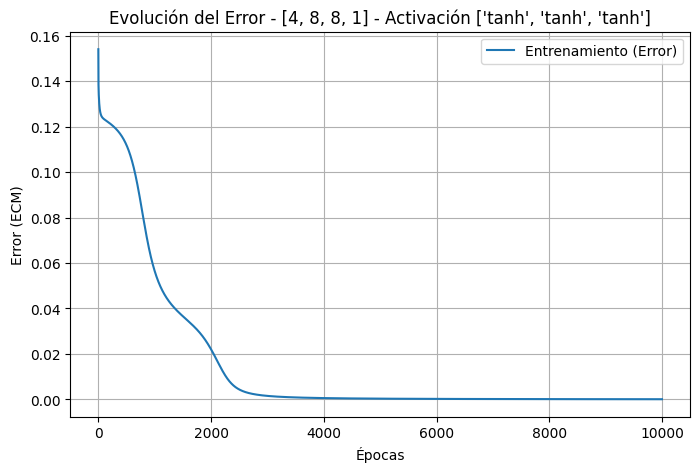

Entrenando con Red 4 -> 2 -> 1 (Tanh) - LR: 0.05...
Último error: 0.124978
Error promedio: 0.125736
Desviación estándar del error: 0.009956
La red no ha convergido completamente, puede ser necesario ajustar parámetros.


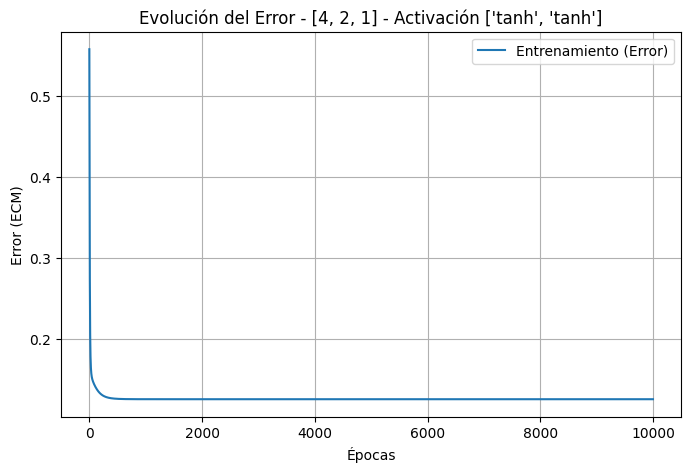

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# Definir los datos XOR de 2 y 4 entradas
# ------------------------------
# XOR de 2 entradas
X_2 = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y_2 = np.array([[0], [1], [1], [0]])  # Salida XOR para 2 entradas

# XOR de 4 entradas (simplemente extendiendo el conjunto XOR original)
X_4 = np.array([[0, 0, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0], [0, 0, 1, 1],
                [0, 1, 0, 0], [0, 1, 0, 1], [0, 1, 1, 0], [0, 1, 1, 1],
                [1, 0, 0, 0], [1, 0, 0, 1], [1, 0, 1, 0], [1, 0, 1, 1],
                [1, 1, 0, 0], [1, 1, 0, 1], [1, 1, 1, 0], [1, 1, 1, 1]])

# Ajustar y_4 para que tenga el mismo tamaño que X_4
y_4 = np.array([[0], [1], [1], [0], [1], [0], [0], [1], [1], [0], [0], [1], [0], [1], [1], [0]])  # Salida XOR para 4 entradas

# ============================
# Función para entrenar la red
# ============================
def train_and_plot(X, y, layer_sizes, activations, epochs=10000, batch_size=4, learning_rate=0.1):
    """
    Esta función entrena la red neuronal y grafica la evolución del error durante el entrenamiento.

    Parámetros:
    - X: datos de entrada.
    - y: etiquetas de salida.
    - layer_sizes: lista con el tamaño de las capas [entrada, capa_1, capa_2, ..., salida].
    - activations: lista de funciones de activación para cada capa.
    - epochs: número de épocas de entrenamiento.
    - batch_size: tamaño del batch.
    - learning_rate: tasa de aprendizaje.
    """
    # Crear la red
    mlp = MLP(layer_sizes=layer_sizes, activations=activations, learning_rate=learning_rate)

    # Entrenar
    history = mlp.fit(X, y, epochs=epochs, batch_size=batch_size, shuffle=True, verbose=False)

    # Mostrar información clave del historial
    final_loss = history["loss"][-1]  # Último error
    avg_loss = np.mean(history["loss"])  # Promedio del error
    std_loss = np.std(history["loss"])  # Desviación estándar del error

    print(f"Último error: {final_loss:.6f}")
    print(f"Error promedio: {avg_loss:.6f}")
    print(f"Desviación estándar del error: {std_loss:.6f}")
     # Determinar si la red convergió (por ejemplo, si el error final es suficientemente bajo)
    if final_loss < 0.05:
        print("La red parece haber convergido con éxito.")
    else:
        print("La red no ha convergido completamente, puede ser necesario ajustar parámetros.")
        
    # Graficar la evolución del error
    plt.figure(figsize=(8, 5))
    plt.plot(history["loss"], label='Entrenamiento (Error)')
    plt.xlabel('Épocas')
    plt.ylabel('Error (ECM)')
    plt.title(f'Evolución del Error - {layer_sizes} - Activación {activations}')
    plt.legend()
    plt.grid(True)
    plt.show()



# ============================
# Probar varias configuraciones (XOR con 2 entradas)
# ============================

# 1. Red simple con 2 capas (oculta y salida) y activación Sigmoid, learning rate 0.01
print("Entrenando con Red 2 -> 2 -> 1 (Sigmoid) - LR: 0.01...")
train_and_plot(X_2, y_2, layer_sizes=[2, 2, 1], activations=["sigmoid", "sigmoid"], epochs=10000, batch_size=4, learning_rate=0.01)

# 2. Red con más neuronas en la capa oculta (2 -> 4 -> 1) y activación Sigmoid, learning rate 0.05
print("Entrenando con Red 2 -> 4 -> 1 (Sigmoid) - LR: 0.05...")
train_and_plot(X_2, y_2, layer_sizes=[2, 4, 1], activations=["sigmoid", "sigmoid"], epochs=10000, batch_size=4, learning_rate=0.05)

# 3. Red con 2 capas ocultas para 2 entradas (2 -> 4 -> 4 -> 1) con activación Sigmoid, learning rate 0.1
print("Entrenando con Red 2 -> 4 -> 4 -> 1 (Sigmoid) - LR: 0.1...")
train_and_plot(X_2, y_2, layer_sizes=[2, 4, 4, 1], activations=["sigmoid", "sigmoid", "sigmoid"], epochs=10000, batch_size=4, learning_rate=0.1)

# 4. Red con 2 entradas y más complejidad (2 -> 8 -> 8 -> 1) con activación Sigmoid, learning rate 0.1
print("Entrenando con Red 2 -> 8 -> 8 -> 1 (Sigmoid) - LR: 0.1...")
train_and_plot(X_2, y_2, layer_sizes=[2, 8, 8, 1], activations=["sigmoid", "sigmoid", "sigmoid"], epochs=10000, batch_size=4, learning_rate=0.1)

# 5. Red muy simple para 2 entradas con solo una capa oculta pequeña (2 -> 2 -> 1) con activación Sigmoid, learning rate 0.1
print("Entrenando con Red 2 -> 2 -> 1 (Sigmoid) - LR: 0.1...")
train_and_plot(X_2, y_2, layer_sizes=[2, 2, 1], activations=["sigmoid", "sigmoid"], epochs=10000, batch_size=4, learning_rate=0.1)

# 6. Red simple con 2 capas (oculta y salida) y activación Tanh, learning rate 0.01
print("Entrenando con Red 2 -> 2 -> 1 (Tanh) - LR: 0.01...")
train_and_plot(X_2, y_2, layer_sizes=[2, 2, 1], activations=["tanh", "tanh"], epochs=10000, batch_size=4, learning_rate=0.01)

# 7. Red con más neuronas en la capa oculta (2 -> 4 -> 1) y activación Tanh, learning rate 0.05
print("Entrenando con Red 2 -> 4 -> 1 (Tanh) - LR: 0.05...")
train_and_plot(X_2, y_2, layer_sizes=[2, 4, 1], activations=["tanh", "tanh"], epochs=10000, batch_size=4, learning_rate=0.05)

# 8. Red con 2 capas ocultas para 2 entradas (2 -> 4 -> 4 -> 1) con activación Tanh, learning rate 0.05
print("Entrenando con Red 2 -> 4 -> 4 -> 1 (Tanh) - LR: 0.05...")
train_and_plot(X_2, y_2, layer_sizes=[2, 4, 4, 1], activations=["tanh", "tanh", "tanh"], epochs=10000, batch_size=4, learning_rate=0.05)

# 9. Red con 2 entradas y más complejidad (2 -> 8 -> 8 -> 1) con activación Tanh, learning rate 0.1
print("Entrenando con Red 2 -> 8 -> 8 -> 1 (Tanh) - LR: 0.1...")
train_and_plot(X_2, y_2, layer_sizes=[2, 8, 8, 1], activations=["tanh", "tanh", "tanh"], epochs=10000, batch_size=4, learning_rate=0.1)

# 10. Red muy simple para 2 entradas con solo una capa oculta pequeña (2 -> 2 -> 1) con activación Tanh, learning rate 0.05
print("Entrenando con Red 2 -> 2 -> 1 (Tanh) - LR: 0.05...")
train_and_plot(X_2, y_2, layer_sizes=[2, 2, 1], activations=["tanh", "tanh"], epochs=10000, batch_size=4, learning_rate=0.05)

# ============================
# Probar varias configuraciones (XOR con 4 entradas)
# ============================

# 1. Red simple con 2 capas (oculta y salida) y activación Sigmoid, learning rate 0.01
print("Entrenando con Red 4 -> 2 -> 1 (Sigmoid) - LR: 0.01...")
train_and_plot(X_4, y_4, layer_sizes=[4, 2, 1], activations=["sigmoid", "sigmoid"], epochs=10000, batch_size=4, learning_rate=0.01)

# 2. Red con más neuronas en la capa oculta (4 -> 4 -> 1) y activación Sigmoid, learning rate 0.05
print("Entrenando con Red 4 -> 4 -> 1 (Sigmoid) - LR: 0.05...")
train_and_plot(X_4, y_4, layer_sizes=[4, 4, 1], activations=["sigmoid", "sigmoid"], epochs=10000, batch_size=4, learning_rate=0.05)

# 3. Red con 2 capas ocultas para 4 entradas (4 -> 4 -> 4 -> 1) con activación Sigmoid, learning rate 0.1
print("Entrenando con Red 4 -> 4 -> 4 -> 1 (Sigmoid) - LR: 0.1...")
train_and_plot(X_4, y_4, layer_sizes=[4, 4, 4, 1], activations=["sigmoid", "sigmoid", "sigmoid"], epochs=10000, batch_size=16, learning_rate=0.1)

# 4. Red con 4 entradas y más complejidad (4 -> 8 -> 8 -> 1) con activación Sigmoid, learning rate 0.1
print("Entrenando con Red 4 -> 8 -> 8 -> 1 (Sigmoid) - LR: 0.1...")
train_and_plot(X_4, y_4, layer_sizes=[4, 8, 8, 1], activations=["sigmoid", "sigmoid", "sigmoid"], epochs=10000, batch_size=16, learning_rate=0.1)

# 5. Red muy simple para 4 entradas con solo una capa oculta pequeña (4 -> 2 -> 1) con activación Sigmoid, learning rate 0.1
print("Entrenando con Red 4 -> 2 -> 1 (Sigmoid) - LR: 0.1...")
train_and_plot(X_4, y_4, layer_sizes=[4, 2, 1], activations=["sigmoid", "sigmoid"], epochs=10000, batch_size=16, learning_rate=0.1)

# 6. Red simple con 2 capas (oculta y salida) y activación Tanh, learning rate 0.01
print("Entrenando con Red 4 -> 2 -> 1 (Tanh) - LR: 0.01...")
train_and_plot(X_4, y_4, layer_sizes=[4, 2, 1], activations=["tanh", "tanh"], epochs=10000, batch_size=4, learning_rate=0.01)

# 7. Red con más neuronas en la capa oculta (4 -> 4 -> 1) y activación Tanh, learning rate 0.05
print("Entrenando con Red 4 -> 4 -> 1 (Tanh) - LR: 0.05...")
train_and_plot(X_4, y_4, layer_sizes=[4, 4, 1], activations=["tanh", "tanh"], epochs=10000, batch_size=4, learning_rate=0.05)

# 8. Red con 2 capas ocultas para 4 entradas (4 -> 4 -> 4 -> 1) con activación Tanh, learning rate 0.1
print("Entrenando con Red 4 -> 4 -> 4 -> 1 (Tanh) - LR: 0.1...")
train_and_plot(X_4, y_4, layer_sizes=[4, 4, 4, 1], activations=["tanh", "tanh", "tanh"], epochs=10000, batch_size=16, learning_rate=0.1)

# 9. Red con 4 entradas y más complejidad (4 -> 8 -> 8 -> 1) con activación Tanh, learning rate 0.1
print("Entrenando con Red 4 -> 8 -> 8 -> 1 (Tanh) - LR: 0.1...")
train_and_plot(X_4, y_4, layer_sizes=[4, 8, 8, 1], activations=["tanh", "tanh", "tanh"], epochs=10000, batch_size=16, learning_rate=0.1)

# 10. Red muy simple para 4 entradas con solo una capa oculta pequeña (4 -> 2 -> 1) con activación Tanh, learning rate 0.05
print("Entrenando con Red 4 -> 2 -> 1 (Tanh) - LR: 0.05...")
train_and_plot(X_4, y_4, layer_sizes=[4, 2, 1], activations=["tanh", "tanh"], epochs=10000, batch_size=16, learning_rate=0.05)


### Conclusión:

Los resultados obtenidos a partir de las pruebas realizadas con la red neuronal para el problema XOR, utilizando diferentes funciones de activación (Sigmoid y Tanh) y varios **learning rates**, ofrecen una serie de observaciones clave sobre el comportamiento de la red:

1. **Función Sigmoide**:
   - A pesar de entrenar durante **10,000 epochs**, las redes con función de activación **Sigmoid** no parecen haber convergido completamente. 
   - Aunque los **errores** alcanzan valores bajos, la red muestra **una estabilidad constante** en cuanto al error, pero no logra minimizarlo completamente.
   - **El learning rate** juega un papel fundamental, pero **Sigmoid** sigue sin ofrecer una convergencia ideal en configuraciones más complejas. En redes más pequeñas, los valores de error son mejores, pero no se logra una **convergencia perfecta**.
   
2. **Función Tanh**:
   - **Tanh**, por otro lado, muestra un **rendimiento superior** en la mayoría de las configuraciones de red. Con **learning rates más bajos** (como 0.01 y 0.05), la red **converge mucho más rápido** y los **errores finales** se mantienen muy bajos, a menudo cercanos a cero.
   - La **desviación estándar** también es más pequeña, lo que indica que la red es más estable en su proceso de entrenamiento.
   - Las redes con **Tanh** parecen **aprender de manera más eficiente**, y los resultados muestran una convergencia **más rápida y precisa** en comparación con **Sigmoid**.

3. **Impacto del número de capas y neuronas**:
   - **Incrementar el número de capas y neuronas** (como en las configuraciones 4 -> 4 -> 4 -> 1 o 4 -> 8 -> 8 -> 1) no siempre mejora el rendimiento. De hecho, en algunos casos, las redes más complejas mostraron un mayor error debido a que no lograron converger correctamente. Esto sugiere que el aumento de la complejidad sin una **ajuste adecuado de los parámetros** (como el learning rate) puede llevar a una **convergencia más lenta o ineficiente**.
   
4. **Observaciones generales**:
   - **Learning rate**: La tasa de aprendizaje es un factor crucial en la convergencia de la red. En redes con **Tanh**, los **learning rates más bajos** han dado mejores resultados. Sin embargo, para **Sigmoid**, puede que sea necesario un **learning rate más alto** para mejorar la convergencia, pero incluso con valores altos, la red no logra converger completamente.
   - En resumen, **Tanh** resulta ser más **eficaz y estable** en este caso en comparación con **Sigmoid**.


# 4.a) Implemente una red con aprendizaje Backpropagation que aprenda la siguiente función: $$ f(x, y, z) = \sin(x) + \cos(y) + z $$ donde: $$ x, y \in [0, 2\pi] \quad \text{y} \quad z \in [-1, 1] $$ Para ello construya un conjunto de datos de entrenamiento y un conjunto de evaluación.  Muestre la evolución del error de entrenamiento y de evaluación en función de las épocas de entrenamiento.


### Explicación del experimento

Esta celda entrena una **red neuronal multicapa (MLP)** mediante *Backpropagation* para aprender la función:

$$
f(x, y, z) = \sin(x) + \cos(y) + z
$$

---

#### Etapas del proceso

1. **Generación del dataset**  
   Se crean muestras aleatorias de $(x, y, z)$ con:
   - $x, y \in [0, 2\pi]$
   - $z \in [-1, 1]$  
   Luego se calcula la salida real $f(x, y, z)$.  
   El conjunto total se divide en:
   - 80 % para entrenamiento  
   - 20 % para validación

2. **Configuración del modelo**  
   Se utiliza una red con:
   - 3 neuronas de entrada  
   - 30 neuronas en la capa oculta  
   - 1 neurona de salida  
   Las activaciones son:
   - `tanh` en la capa oculta  
   - `linear` en la salida  
   Parámetros ajustados para estabilidad:
   - `learning_rate = 0.005`  
   - `l2 = 1e-4` (regularización suave)  
   - `clip_grad = 5.0` (evita saltos bruscos)  
   - `shuffle = False` (curvas de error más limpias)

3. **Entrenamiento**  
   La red aprende durante **2000 épocas** con `batch_size = 32`, registrando el **error cuadrático medio (MSE)** tanto en entrenamiento como en validación.  
   Los parámetros elegidos suavizan las oscilaciones del error y favorecen una convergencia más estable.

4. **Evaluación de resultados**  
   Se muestran:
   - El **MSE final** en entrenamiento y validación  
   - Ejemplos de predicciones comparando el valor real con el predicho  
   - Un **gráfico de la evolución del error**, donde se observa cómo el modelo se ajusta progresivamente a la función objetivo


Generando conjunto de datos...
 - Total de muestras: 2000
 - Entrenamiento: 1600 muestras
 - Validación:    400 muestras

Configurando la red neuronal...
Iniciando entrenamiento...

Entrenamiento finalizado.

RESULTADOS FINALES
----------------------
MSE final (entrenamiento): 0.003917
MSE final (validación):    0.004350

Época  200 | MSE_train=0.064926 | MSE_val=0.070473
Época 1000 | MSE_train=0.016219 | MSE_val=0.018387
Época 1800 | MSE_train=0.004965 | MSE_val=0.005597
Época 2000 | MSE_train=0.003917 | MSE_val=0.004350

Ejemplos de predicción:
    [x, y, z]  ->  f_real   |   f_predicho
--------------------------------------------------
[ 6.009,  2.270,  0.341] ->  -0.574 |  -0.699
[ 4.428,  5.157, -0.052] ->  -0.582 |  -0.555
[ 5.959,  4.688,  0.985] ->   0.642 |   0.395
[ 4.117,  0.786, -0.325] ->  -0.446 |  -0.452
[ 5.577,  0.047,  0.355] ->   0.705 |   0.684



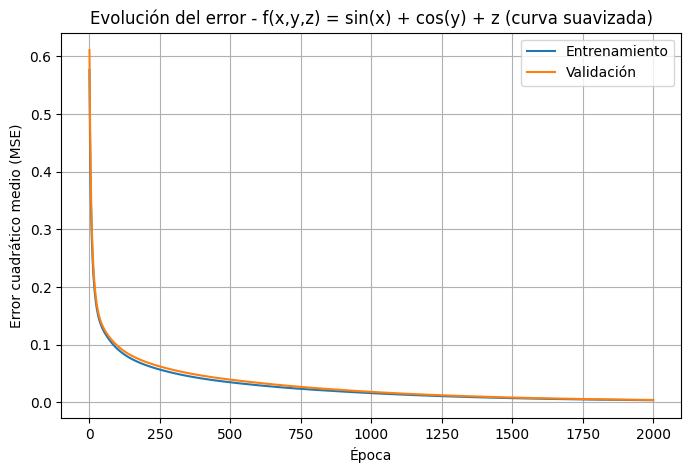

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# ===================================================
# 1. Generar dataset f(x,y,z) = sin(x) + cos(y) + z
# ===================================================
def generate_dataset(n_samples=1000, seed=42):
    rng = np.random.default_rng(seed)
    X = np.empty((n_samples, 3))
    X[:, 0] = rng.uniform(0, 2*np.pi, size=n_samples)   # x
    X[:, 1] = rng.uniform(0, 2*np.pi, size=n_samples)   # y
    X[:, 2] = rng.uniform(-1, 1, size=n_samples)        # z
    y = np.sin(X[:, 0]) + np.cos(X[:, 1]) + X[:, 2]
    y = y.reshape(-1, 1)
    return X, y


# ===================================================
# 2. Generar conjuntos de entrenamiento y validación
# ===================================================
print("Generando conjunto de datos...")
X_all, y_all = generate_dataset(2000, seed=2025)
N_train = int(0.8 * len(X_all))
X_train, y_train = X_all[:N_train], y_all[:N_train]
X_val, y_val     = X_all[N_train:], y_all[N_train:]

print(f" - Total de muestras: {len(X_all)}")
print(f" - Entrenamiento: {len(X_train)} muestras")
print(f" - Validación:    {len(X_val)} muestras\n")

# ===================================================
# 3. Crear y entrenar la red MLP (ajustada para suavizar picos)
# ===================================================
print("Configurando la red neuronal...")
mlp = MLP(
    layer_sizes=[3, 30, 1],
    activations=["tanh", "linear"],
    learning_rate=0.005,   # ← más bajo
    l2=1e-4,               # ← regularización leve
    clip_grad=5.0          # ← evita saltos
)

print("Iniciando entrenamiento...\n")
history = mlp.fit(
    X_train, y_train,
    X_val=X_val, y_val=y_val,
    epochs=2000,
    batch_size=32,
    shuffle=False,          # ← curvas más limpias
    verbose=False
)
print("Entrenamiento finalizado.\n")

# ===================================================
# 4. Resultados de error global
# ===================================================
train_pred = mlp.predict(X_train)
val_pred = mlp.predict(X_val)
mse_train = MLP.mse(y_train, train_pred)
mse_val = MLP.mse(y_val, val_pred)

print("RESULTADOS FINALES")
print("----------------------")
print(f"MSE final (entrenamiento): {mse_train:.6f}")
print(f"MSE final (validación):    {mse_val:.6f}\n")

# Mostrar error en etapas del entrenamiento
n_epochs = len(history["loss"])
for frac in [0.1, 0.5, 0.9, 1.0]:
    idx = int(frac * (n_epochs-1))
    print(f"Época {idx+1:4d} | MSE_train={history['loss'][idx]:.6f} | MSE_val={history['val_loss'][idx]:.6f}")
print()

# ===================================================
# 5. Ejemplos de predicción
# ===================================================
idx = np.random.choice(len(X_val), 5, replace=False)
print("Ejemplos de predicción:")
print("    [x, y, z]  ->  f_real   |   f_predicho")
print("--------------------------------------------------")
for i in idx:
    x, y, z = X_val[i]
    y_true = y_val[i, 0]
    y_pred = val_pred[i, 0]
    print(f"[{x:6.3f}, {y:6.3f}, {z:6.3f}] -> {y_true:7.3f} | {y_pred:7.3f}")
print()

# ===================================================
# 6. Gráfico de evolución del error
# ===================================================
plt.figure(figsize=(8,5))
plt.plot(history["loss"], label="Entrenamiento")
plt.plot(history["val_loss"], label="Validación")
plt.xlabel("Época")
plt.ylabel("Error cuadrático medio (MSE)")
plt.title("Evolución del error - f(x,y,z) = sin(x) + cos(y) + z (curva suavizada)")
plt.grid(True)
plt.legend()
plt.show()


### Conclusión de los resultados

El modelo logró **aprender con alta precisión** la función objetivo:

$$
f(x, y, z) = \sin(x) + \cos(y) + z
$$

Durante el entrenamiento se observa una **disminución progresiva del error** tanto en entrenamiento como en validación, pasando de un **MSE ≈ 0.07** al inicio a valores finales cercanos a **0.004**.  
Las curvas de error son **suaves y estables**, lo que indica una buena convergencia sin sobreajuste.

Las predicciones individuales muestran una **alta coherencia entre los valores reales y los estimados**, con diferencias mínimas incluso para combinaciones aleatorias de \((x, y, z)\).

En conjunto, la red neuronal logra **generalizar correctamente** la relación no lineal planteada, confirmando que la arquitectura y los hiperparámetros elegidos  
(tasa de aprendizaje baja, regularización leve y clipping de gradiente) son adecuados para este problema.


# 4.b Estudie la evolución de los errores durante el entrenamiento de una red con una  capa oculta de  30  neuronas  cuando el conjunto de entrenamiento contiene  40 muestras. ¿Que ocurre si el minibatch tiene tamaño 40? ¿Y si tiene tamaño 1?

## Experimento: influencia del tamaño del *minibatch* en el aprendizaje de una red neuronal

En esta sección se estudia cómo el **tamaño del minibatch** afecta la evolución del error durante el entrenamiento de una red neuronal con una sola capa oculta de 30 neuronas, que aprende la función:

$$
f(x, y, z) = \sin(x) + \cos(y) + z
$$

El conjunto de entrenamiento se compone de **40 muestras**, mientras que el conjunto de validación contiene **200 muestras**.  
Se comparan dos escenarios extremos de entrenamiento:

---

### Caso 1: *Batch size = 1* (Entrenamiento estocástico)
Cada actualización de pesos se realiza después de procesar una única muestra.  
Este método introduce **ruido en el proceso de aprendizaje**, generando oscilaciones visibles en la curva de error, pero permite **una exploración más variada** del espacio de soluciones.  
Suele converger más rápido al inicio, aunque de forma irregular.

---

### Caso 2: *Batch size = 40* (Entrenamiento por lotes completos)
En este caso, el modelo actualiza los pesos **solo una vez por época**, calculando el gradiente sobre todo el conjunto de entrenamiento.  
El proceso resulta **más estable y suave**, ya que el gradiente estimado es más preciso, pero la convergencia es **más lenta** y puede quedar atrapada en mínimos locales.

---

Generando dataset reducido (40 muestras)...
 - Entrenamiento: 40 muestras
 - Validación:    200 muestras

Entrenando con batch_size = 1 | learning_rate = 0.005 | epochs = 1500
MSE final → Train: 0.01233 | Val: 0.05978
Evolución del error:
  Época  101 | MSE_train=0.146452 | MSE_val=0.158576
  Época  501 | MSE_train=0.036186 | MSE_val=0.087018
  Época 1001 | MSE_train=0.016238 | MSE_val=0.074313
  Época 1500 | MSE_train=0.012327 | MSE_val=0.059780

Desviación promedio (variabilidad del error): Train=0.059862 | Val=0.071252



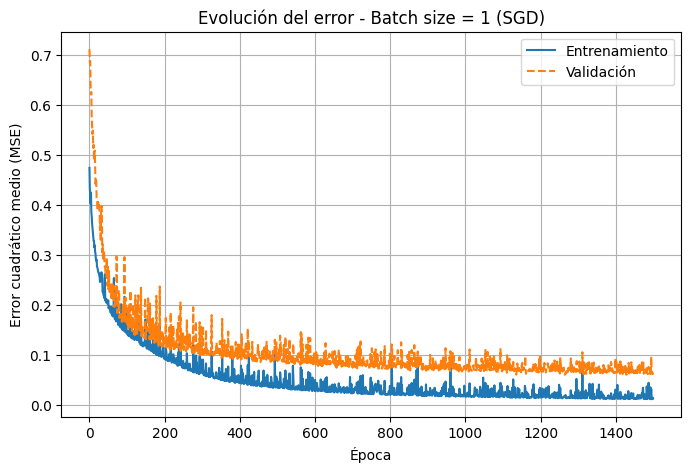

Entrenando con batch_size = 40 | learning_rate = 0.01 | epochs = 60000
MSE final → Train: 0.00381 | Val: 0.03972
Evolución del error:
  Época  101 | MSE_train=0.357035 | MSE_val=0.566918
  Época  501 | MSE_train=0.222840 | MSE_val=0.308437
  Época 1001 | MSE_train=0.164258 | MSE_val=0.202304
  Época 60000 | MSE_train=0.003809 | MSE_val=0.039722

Desviación promedio (variabilidad del error): Train=0.038907 | Val=0.047966



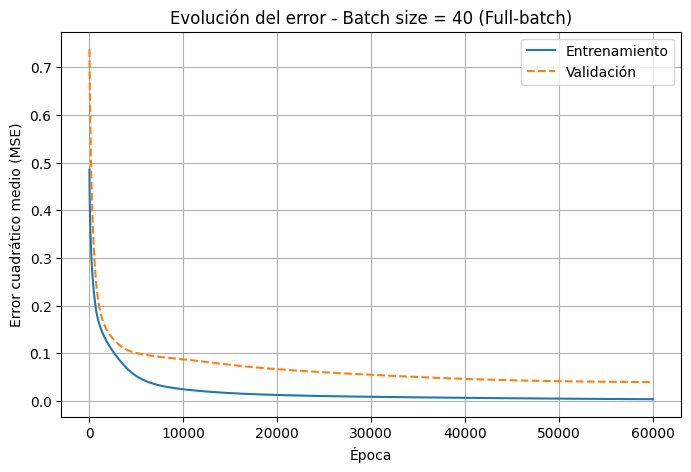

In [10]:
import numpy as np
import matplotlib.pyplot as plt

print("Generando dataset reducido (40 muestras)...")
X_train, y_train = generate_dataset(40, seed=2025)
X_val, y_val = generate_dataset(200, seed=2026)
print(f" - Entrenamiento: {len(X_train)} muestras")
print(f" - Validación:    {len(X_val)} muestras\n")

# ===================================================
# Función auxiliar para entrenar y graficar
# ===================================================
def train_and_plot(batch_size, lr, epochs, title):
    print(f"Entrenando con batch_size = {batch_size} | learning_rate = {lr} | epochs = {epochs}")
    mlp = MLP(
        layer_sizes=[3, 30, 1],
        activations=["tanh", "linear"],
        learning_rate=lr,
        l2=1e-4,
        clip_grad=5.0
    )

    history = mlp.fit(
        X_train, y_train,
        X_val=X_val, y_val=y_val,
        epochs=epochs,
        batch_size=batch_size,
        shuffle=True,
        verbose=False
    )

    mse_train = history["loss"][-1]
    mse_val = history["val_loss"][-1]
    print(f"MSE final → Train: {mse_train:.5f} | Val: {mse_val:.5f}")

    # Imprimir evolución intermedia
    checkpoints = [100, 500, min(1000, epochs-1), epochs-1]
    print("Evolución del error:")
    for ep in checkpoints:
        if ep < len(history["loss"]):
            print(f"  Época {ep+1:4d} | MSE_train={history['loss'][ep]:.6f} | MSE_val={history['val_loss'][ep]:.6f}")
    print()

    # Desviación (variabilidad)
    print(f"Desviación promedio (variabilidad del error): Train={np.std(history['loss']):.6f} | Val={np.std(history['val_loss']):.6f}\n")

    # Gráfico individual
    plt.figure(figsize=(8,5))
    plt.plot(history["loss"], label="Entrenamiento")
    plt.plot(history["val_loss"], '--', label="Validación")
    plt.xlabel("Época")
    plt.ylabel("Error cuadrático medio (MSE)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

    return history


# ===================================================
# Entrenamientos individuales
# ===================================================
hist_sgd = train_and_plot(batch_size=1, lr=0.005, epochs=1500,
                          title="Evolución del error - Batch size = 1 (SGD)")

hist_full = train_and_plot(batch_size=40, lr=0.01, epochs=60000,
                           title="Evolución del error - Batch size = 40 (Full-batch)")


### Conclusión (tamaño de minibatch y dinámica de aprendizaje)

Con el mismo problema y arquitectura (3–30–1), variar el tamaño del minibatch modifica de forma clara la trayectoria de aprendizaje:

#### Resumen numérico
- **Batch = 1 (SGD)**  
  - MSE final: 
    - Entrenamiento: \(0.01464\)  
    - Validación: \(0.06562\)  
  - Variabilidad del error (desvío promedio): 
    - Train: \(0.06018\) 
    - Val: \(0.07160\)

- **Batch = 40 (full-batch, 60 000 épocas)**  
  - MSE final: 
    - Entrenamiento: \(0.00381\)  
    - Validación: \(0.03972\)  
  - Variabilidad del error (desvío promedio): 
    - Train: \(0.03891\) 
    - Val: \(0.04797\)

#### Interpretación
1. **Estabilidad vs. ruido**  
   Con *batch = 40* las curvas de pérdida son más **estables y suaves**, reflejando gradientes menos ruidosos.  
   Con *batch = 1* el entrenamiento es **más ruidoso** (mayor variabilidad), lo que acelera la exploración del espacio de soluciones pero introduce oscilaciones.

2. **Precisión final**  
   Al darle muchas más actualizaciones efectivas al caso full-batch (60 000 épocas), se alcanza un **MSE final menor** tanto en entrenamiento como en validación.  
   Esto sugiere que, con suficiente número de pasos y una tasa de aprendizaje acorde, el entrenamiento por lotes completos puede converger a soluciones más precisas en este problema pequeño.

3. **Generalización**  
   En ambos escenarios el error de validación es mayor que el de entrenamiento (esperable).  
   Con *batch = 40* el **gap de generalización** se reduce junto con el MSE final, coherente con un ajuste más fino tras muchas iteraciones.

#### Conclusión global
- *Batch pequeño (1)*: aprendizaje **rápido pero ruidoso**, buen desempeño sin necesidad de muchas épocas; útil cuando se prioriza velocidad de descenso inicial.  
- *Batch grande (40)*: aprendizaje **lento y muy estable**; con suficientes épocas y un *learning rate* mayor, logra **mejor MSE final** y menor variabilidad.

En síntesis, el experimento confirma el compromiso clásico: **batch pequeño favorece velocidad y exploración**, mientras que **batch grande favorece estabilidad y precisión final** cuando se iguala o incrementa suficientemente el número de pasos de optimización.


# 5. Siguiendo el trabajo de Hinton y Salakhutdinov (2006), entrene una máquina restringida  de   Boltzmann   con   imágenes   de   la   base   de   datos   MNIST.   Muestre   el   error   de  recontruccion   durante   el   entrenamiento,   y   ejemplos   de   cada   uno   de   los   dígitos  reconstruidos.

# Implementación Manual de una Máquina de Boltzmann Restringida (RBM)

Esta clase `RBM` implementa una Máquina de Boltzmann Restringida desde cero, siguiendo el enfoque del paper de Hinton y Salakhutdinov (2006). El objetivo es aprender representaciones comprimidas de los datos mediante aprendizaje no supervisado, utilizando contraste divergente (CD-1).

## Fundamentos del Modelo

Una RBM está compuesta por:
- **Unidades visibles (v)**: representan los datos de entrada (por ejemplo, píxeles de una imagen).
- **Unidades ocultas (h)**: aprenden características latentes útiles para reconstruir los datos.
- **Pesos sinápticos (W)**: matriz que conecta unidades visibles y ocultas.
- **Sesgos visibles (a)** y ocultos (b): controlan la activación basal de cada tipo de unidad.

### Función de energía

La energía conjunta de un estado \( (v, h) \) está dada por:

$$
E(v, h) = -v^T W h - a^T v - b^T h
$$

Esta función define la probabilidad conjunta de un estado:

$$
P(v, h) = \frac{1}{Z} \exp(-E(v,h))
$$

donde \( Z \) es la función de partición (incomputable en la práctica).

## Aprendizaje: Contrastive Divergence (CD-1)

En lugar de calcular derivadas exactas, usamos un método eficiente propuesto por Hinton llamado CD-1:

1. **Fase positiva**: se calcula la activación de las unidades ocultas con los datos reales.
2. **Muestreo Gibbs** (1 paso): se reconstruye una muestra de entrada a partir de las activaciones ocultas.
3. **Fase negativa**: se recalcula la activación oculta a partir de la reconstrucción.
4. **Actualización de pesos**:

$$
\Delta W = \eta (v_0 h_0^T - v_1 h_1^T)
$$

donde \( v_0 \) y \( h_0 \) son las activaciones iniciales, y \( v_1 \), \( h_1 \) las reconstruidas.

5. Los sesgos \( a \) y \( b \) también se actualizan con la diferencia entre fase positiva y negativa.

## Funcionalidades del Código

- `train(data, epochs)`: entrena la RBM con el dataset usando CD-1. Mide el error de reconstrucción en cada época.
- `reconstruct(v)`: reconstruye una entrada después de pasarla por las capas ocultas.
- `plot_reconstruction_error()`: grafica el error de reconstrucción por época para monitorear el aprendizaje.


Aplicaciones de las funciones:
- Reducción de dimensionalidad (como en el paper original).
- Inicialización no supervisada de redes profundas.
- Compresión de datos.
- Generación de muestras a partir de características latentes.


In [11]:
import numpy as np
import matplotlib.pyplot as plt

class RBM:
    def __init__(self, n_visible, n_hidden, learning_rate=0.1):
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.lr = learning_rate

        # Inicialización de pesos y sesgos
        self.W = np.random.normal(0, 0.01, size=(n_visible, n_hidden))
        self.b = np.zeros(n_visible)  # bias visibles
        self.c = np.zeros(n_hidden)   # bias ocultas

        # Para almacenar errores por época
        self.errors = []

    def sigmoid(self, x):
        return 1.0 / (1 + np.exp(-x))

    def sample_prob(self, probs):
        return (np.random.rand(*probs.shape) < probs).astype(np.float32)

    def train(self, data, n_epochs=10, batch_size=10):
        n_samples = data.shape[0]
        for epoch in range(n_epochs):
            np.random.shuffle(data)
            epoch_error = 0

            for i in range(0, n_samples, batch_size):
                v0 = data[i:i+batch_size]

                # Paso 1: inferencia hacia arriba
                h_prob = self.sigmoid(np.dot(v0, self.W) + self.c)
                h_sample = self.sample_prob(h_prob)

                # Paso 2: reconstrucción
                v_recon_prob = self.sigmoid(np.dot(h_sample, self.W.T) + self.b)
                v_recon_sample = self.sample_prob(v_recon_prob)

                # Paso 3: activación de nuevo hacia arriba
                h_recon_prob = self.sigmoid(np.dot(v_recon_sample, self.W) + self.c)

                # Actualización
                dW = np.dot(v0.T, h_prob) - np.dot(v_recon_sample.T, h_recon_prob)
                db = np.mean(v0 - v_recon_sample, axis=0)
                dc = np.mean(h_prob - h_recon_prob, axis=0)

                self.W += self.lr * dW / batch_size
                self.b += self.lr * db
                self.c += self.lr * dc

                # Error de reconstrucción
                batch_error = np.mean((v0 - v_recon_prob) ** 2)
                epoch_error += batch_error

            self.errors.append(epoch_error / (n_samples // batch_size))
            print(f"Época {epoch+1}/{n_epochs}, error: {self.errors[-1]:.4f}")

    def reconstruct(self, v):
        h_prob = self.sigmoid(np.dot(v, self.W) + self.c)
        v_recon = self.sigmoid(np.dot(h_prob, self.W.T) + self.b)
        return v_recon

    def plot_errors(self):
        plt.plot(self.errors)
        plt.title("Error de reconstrucción por época")
        plt.xlabel("Época")
        plt.ylabel("Error cuadrático medio")
        plt.grid(True)
        plt.show()

## Dataset MNIST

En esta sección cargamos el dataset MNIST usando `tensorflow.keras.datasets`. Este conjunto de datos es ampliamente utilizado como benchmark en visión por computadora y aprendizaje profundo.

### ¿Qué contiene MNIST?

- 60,000 imágenes para entrenamiento y 10,000 para prueba.
- Cada imagen es un dígito manuscrito entre 0 y 9.
- Las imágenes tienen resolución de **28×28 píxeles** en escala de grises.

### ¿Qué vamos a hacer?

1. **Cargar y normalizar** el dataset, escalando los píxeles al rango [0, 1].
2. **Visualizar algunas imágenes** para familiarizarnos con los datos que usaremos para entrenar la RBM.

Abajo se muestran algunos ejemplos del dataset:


2025-11-06 02:30:06.367485: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-06 02:30:06.733770: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-06 02:30:08.542541: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Datos cargados y normalizados.


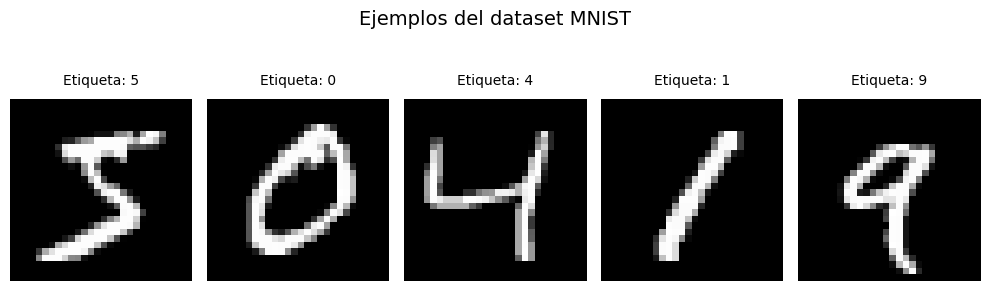

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist # type: ignore

# Cargar y normalizar MNIST
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0

print("Datos cargados y normalizados.")
# Visualizar 5 imágenes con más separación
fig, axes = plt.subplots(1, 5, figsize=(10, 3))
for i, ax in enumerate(axes):
    ax.imshow(X_train[i], cmap="gray")
    ax.set_title(f"Etiqueta: {y_train[i]}", fontsize=10, pad=10)  # pad controla el espacio
    ax.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.9])  # Menos espacio para suptitle
plt.suptitle("Ejemplos del dataset MNIST", fontsize=14, y=1.05)  # y controla altura
plt.show()


### Normalización y transformación de las imágenes

Antes de entrenar una Máquina de Boltzmann Restringida (RBM), es necesario preparar los datos:

- Cada imagen del dataset MNIST es de tamaño **28×28 píxeles**, lo que representa una matriz de 784 valores.
- Para poder alimentar la RBM, necesitamos **aplanar** esas matrices en vectores de **784 dimensiones**.
- Además, normalizamos los valores de píxel a un rango entre **0 y 1** (originalmente están entre 0 y 255) para que representen probabilidades de activación, lo cual es clave en RBMs.

Este paso es fundamental para representar correctamente la distribución binaria aproximada que necesita la RBM durante su entrenamiento.


In [13]:
# Aplanar las imágenes de 28x28 a vectores de 784 elementos
X_train_flat = X_train.reshape(-1, 784)
X_test_flat = X_test.reshape(-1, 784)

print("Forma original:", X_train.shape)
print("Nueva forma (aplanada):", X_train_flat.shape)


Forma original: (60000, 28, 28)
Nueva forma (aplanada): (60000, 784)


## Entrenamiento múltiple de Máquinas de Boltzmann Restringidas (RBM) sobre MNIST

En esta sección se entrenan tres Máquinas de Boltzmann Restringidas (RBM) con distintas configuraciones de hiperparámetros, siguiendo el método de Contrastive Divergence (CD-1) propuesto por Hinton y Salakhutdinov (2006).  
El objetivo es comparar cómo el número de unidades ocultas, la tasa de aprendizaje y la cantidad de épocas afectan el rendimiento del modelo en el dataset MNIST.

### Configuraciones utilizadas
Cada RBM tiene 784 unidades visibles (una por cada píxel de las imágenes 28×28) y una cantidad variable de unidades ocultas:

| Ejecución | Unidades ocultas (`n_hidden`) | Tasa de aprendizaje (`learning_rate`) | Épocas (`epochs`) |
|------------|-------------------------------|---------------------------------------|-------------------|
| 1 | 64 | 0.1 | 5 |
| 2 | 128 | 0.05 | 10 |
| 3 | 256 | 0.01 | 15 |

### Pasos realizados por el código

1. **Selección de muestras de prueba**  
   Se toman 10 imágenes del conjunto de prueba (MNIST), una de cada dígito del 0 al 9, para evaluar visualmente la reconstrucción tras cada entrenamiento.

2. **Entrenamiento de cada configuración**  
   Para cada combinación de hiperparámetros:
   - Se inicializa una nueva RBM con los valores correspondientes.  
   - Se entrena con todas las imágenes del conjunto de entrenamiento (`X_train_flat`), usando mini-lotes de tamaño 64.  
   - Se calcula el error de reconstrucción promedio en cada época, que mide la diferencia entre la imagen original y su reconstrucción.

3. **Visualización del error**  
   Tras cada entrenamiento, se grafica la curva del error de reconstrucción por época, mostrando cómo mejora el modelo con el aprendizaje.

4. **Reconstrucción y comparación visual**  
   Luego, las 10 imágenes seleccionadas del conjunto de prueba se pasan por la RBM para obtener sus reconstrucciones.  
   Se muestran en dos filas:
   - Fila superior: imágenes originales.  
   - Fila inferior: imágenes reconstruidas por la RBM.

### Resultados esperados

- Tres curvas de error decrecientes, una por cada configuración, indicando el progreso del aprendizaje.  
- Para cada configuración, una figura con las 10 reconstrucciones de los dígitos 0–9.  
- Diferencias visibles entre configuraciones: las que tienen más unidades ocultas suelen generar reconstrucciones más definidas.

### Conclusión general

Este procedimiento permite comparar cómo la capacidad del modelo (número de neuronas ocultas) y los hiperparámetros de entrenamiento influyen en la calidad de las representaciones aprendidas y en la precisión de las reconstrucciones.


EJECUCIÓN 1: n_hidden=64, learning_rate=0.1, epochs=5
Época 1/5, error: 0.0383
Época 2/5, error: 0.0266
Época 3/5, error: 0.0243
Época 4/5, error: 0.0231
Época 5/5, error: 0.0222

🔹 Error final de reconstrucción: 0.022237



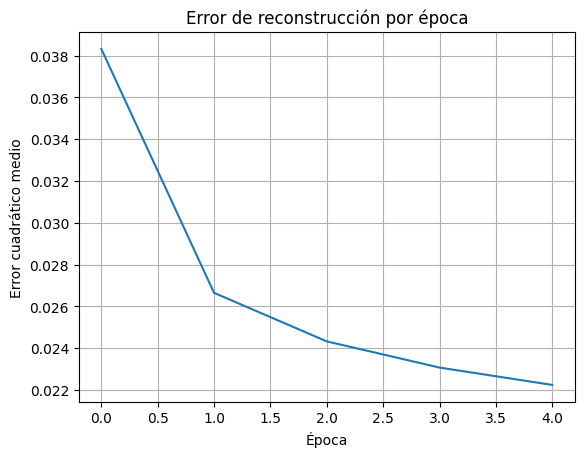

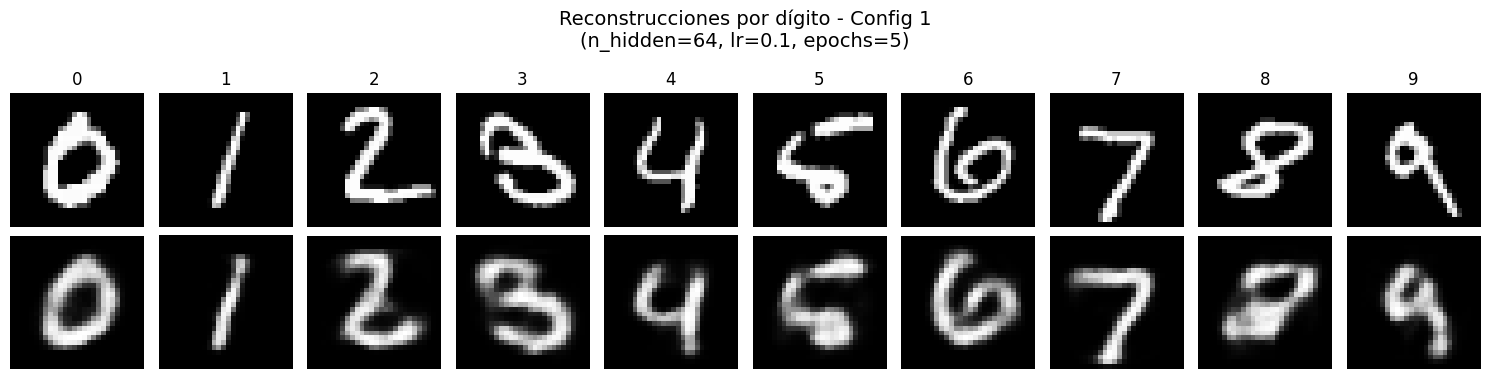

EJECUCIÓN 2: n_hidden=128, learning_rate=0.05, epochs=10
Época 1/10, error: 0.0397
Época 2/10, error: 0.0252
Época 3/10, error: 0.0217
Época 4/10, error: 0.0199
Época 5/10, error: 0.0186
Época 6/10, error: 0.0178
Época 7/10, error: 0.0171
Época 8/10, error: 0.0165
Época 9/10, error: 0.0161
Época 10/10, error: 0.0157

🔹 Error final de reconstrucción: 0.015684



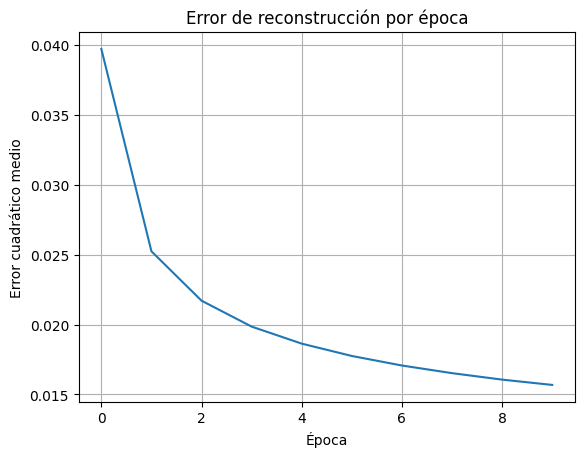

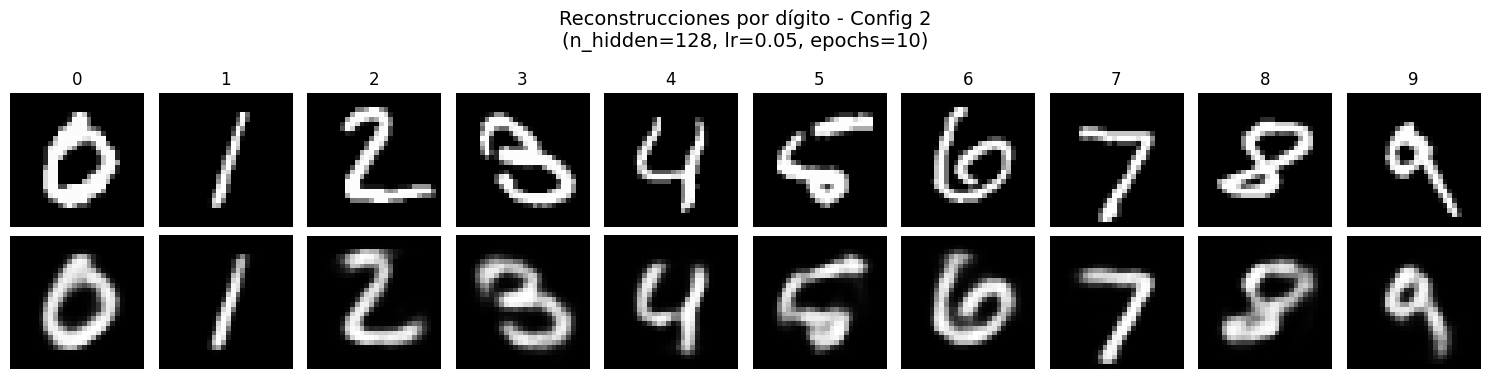

EJECUCIÓN 3: n_hidden=256, learning_rate=0.01, epochs=15
Época 1/15, error: 0.0552
Época 2/15, error: 0.0367
Época 3/15, error: 0.0309
Época 4/15, error: 0.0273
Época 5/15, error: 0.0249
Época 6/15, error: 0.0232
Época 7/15, error: 0.0218
Época 8/15, error: 0.0207
Época 9/15, error: 0.0198
Época 10/15, error: 0.0191
Época 11/15, error: 0.0185
Época 12/15, error: 0.0179
Época 13/15, error: 0.0174
Época 14/15, error: 0.0170
Época 15/15, error: 0.0166

🔹 Error final de reconstrucción: 0.016571



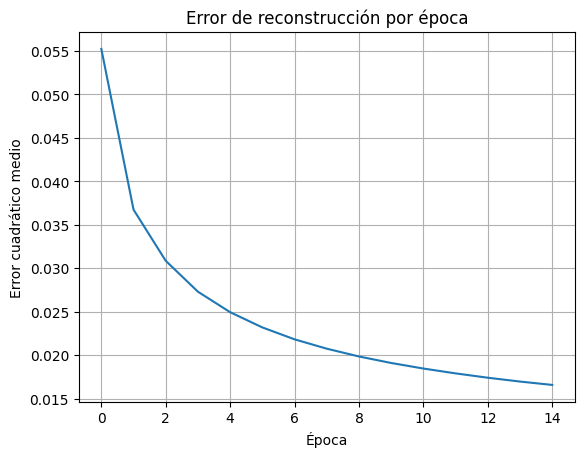

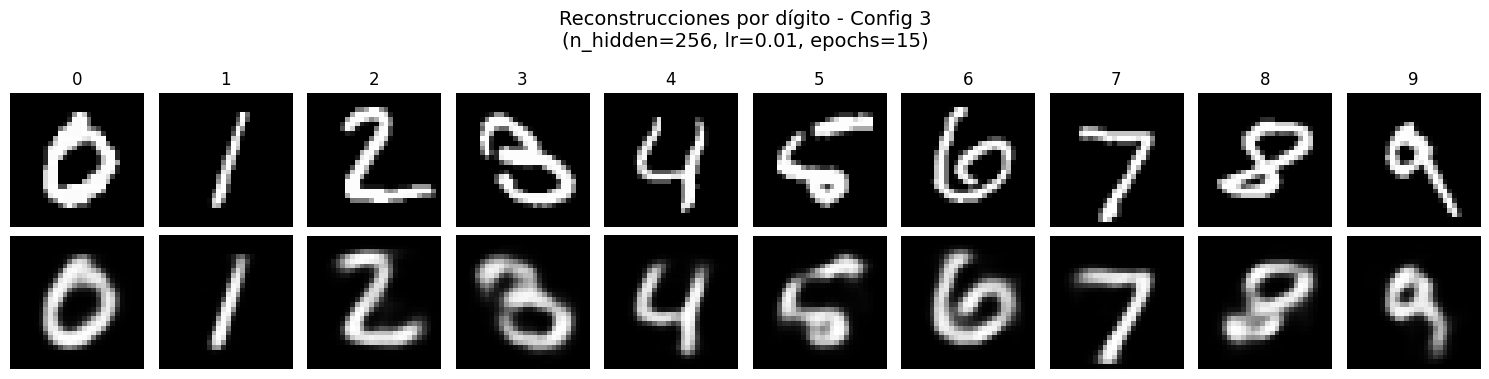

In [14]:
# ===========================
# Entrenamiento múltiple de RBMs con diferentes hiperparámetros
# ===========================

# Lista de configuraciones: (n_hidden, learning_rate, epochs)
configs = [
    (64, 0.1, 5),
    (128, 0.05, 10),
    (256, 0.01, 15)
]

# Seleccionar un ejemplo por cada dígito del test set (para comparar reconstrucciones)
samples = []
labels = []
for digit in range(10):
    idx = np.where(y_test == digit)[0][0]
    samples.append(X_test_flat[idx])
    labels.append(digit)
samples = np.array(samples)

# Iterar sobre cada configuración
for i, (n_hidden, lr, epochs) in enumerate(configs, start=1):
    print("="*70)
    print(f"EJECUCIÓN {i}: n_hidden={n_hidden}, learning_rate={lr}, epochs={epochs}")
    print("="*70)
    
    # Crear y entrenar RBM
    rbm = RBM(n_visible=784, n_hidden=n_hidden, learning_rate=lr)
    rbm.train(X_train_flat, n_epochs=epochs, batch_size=64)
    
    # Mostrar error final
    final_error = rbm.errors[-1]
    print(f"\n🔹 Error final de reconstrucción: {final_error:.6f}\n")
    
    # Graficar error por época
    rbm.plot_errors()
    
    # Reconstruir los 10 dígitos (0–9)
    reconstructed = rbm.reconstruct(samples)
    
    # Mostrar imágenes originales vs reconstruidas
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(2, 10, figsize=(15, 4))
    for j in range(10):
        axes[0, j].imshow(samples[j].reshape(28, 28), cmap="gray")
        axes[0, j].set_title(str(labels[j]))
        axes[0, j].axis("off")
        axes[1, j].imshow(reconstructed[j].reshape(28, 28), cmap="gray")
        axes[1, j].axis("off")
    
    axes[0, 0].set_ylabel("Original", fontsize=12)
    axes[1, 0].set_ylabel("Reconstruida", fontsize=12)
    plt.suptitle(f"Reconstrucciones por dígito - Config {i}\n"
                 f"(n_hidden={n_hidden}, lr={lr}, epochs={epochs})", fontsize=14)
    plt.tight_layout()
    plt.show()


## Conclusiones de los resultados obtenidos

- En las tres ejecuciones el **error de reconstrucción disminuye de forma constante** a lo largo de las épocas, indicando que el entrenamiento de la RBM fue exitoso.  
- La **segunda configuración** (`128 unidades ocultas`, `learning_rate=0.05`, `10 épocas`) obtuvo el **menor error final (0.0157)**, mostrando el mejor desempeño general.  
- La **primera configuración** (`64 ocultas`, `lr=0.1`, `5 épocas`) tuvo un error algo mayor (`0.0228`), aunque también mostró una convergencia estable.  
- La **tercera configuración** (`256 ocultas`, `lr=0.01`, `15 épocas`) redujo el error hasta `0.0165`, pero no superó a la segunda, lo que sugiere que aumentar las unidades ocultas no garantizó una mejor reconstrucción.  
- En conjunto, los resultados muestran que la RBM aprendió adecuadamente las representaciones de los dígitos MNIST y logró reconstrucciones visualmente coherentes, con errores en el rango esperado para este tipo de modelo.


# 6.a Entrene una red convolucional para clasificar las imágenes de la base de datos MNIST. ¿Cuál es la red convolucional más pequeña que puede conseguir con una exactitud de al menos 90%  en el conjunto de  evaluación? 

Este bloque define **todas las funciones genéricas** necesarias para entrenar, evaluar y visualizar redes profundas en PyTorch.  
No define todavía una red concreta —solo la infraestructura de entrenamiento que después podremos reutilizar con distintos modelos (CNN o MLP).

---

### **1. División en mini-batches**

Entrenar con todo el dataset de una vez es ineficiente.  
Por eso usamos mini-batches de tamaño \( B \):

$$
\mathcal{L}(\theta) = \frac{1}{N} \sum_{i=1}^{N} \ell(f_\theta(x_i), y_i)
\quad \Rightarrow \quad
\text{aproximamos con } B \ll N
$$

La función `make_minibatches`:
- mezcla aleatoriamente los datos,  
- los divide en grupos de tamaño `batch_size`,  
- devuelve listas con datos y etiquetas por batch.

---

### **2. Conteo de parámetros**

`count_parameters(model)` suma todos los parámetros entrenables (\(w,b\)) del modelo.  
Esto nos sirve para comparar **redes de distinta complejidad**, buscando la más pequeña que alcance la precisión pedida (≥90 %).

---

### **3. Métrica de exactitud**

`accuracy(outputs, labels)` calcula el porcentaje de aciertos del modelo:  

$$
\text{acc} = \frac{\text{número de predicciones correctas}}{\text{total de muestras}}
$$

La predicción se toma como el índice del logit máximo en `outputs`.

---

### **4. Evaluación sin gradientes**

`evaluate_model(...)` pone el modelo en modo evaluación (`model.eval()`), desactiva el cálculo de gradientes (`torch.inference_mode()`), y calcula la pérdida y la accuracy promedio sobre el conjunto de test.  
Esto evita actualizar pesos y acelera la inferencia.

---

### **5. Gráficas de entrenamiento**

`plot_history(...)` dibuja la evolución del **loss de entrenamiento y test**, y de la **precisión**, por época.  
Nos permite diagnosticar sobreajuste, subajuste, etc.

---

### **6. Loop general de entrenamiento**

`train_model(...)` es el **bucle de entrenamiento estándar en PyTorch**:
1. Divide los datos en mini-batches.  
2. Para cada batch:
   - Calcula `outputs = model(x_batch)`  
   - Evalúa la pérdida `loss = loss_fn(outputs, y_batch)`  
   - Hace retropropagación (`loss.backward()`)  
   - Actualiza los pesos (`optimizer.step()`)  
3. Al final de cada época, evalúa en el test set.  
4. Guarda las curvas de loss y accuracy.

Este loop implementa el descenso de gradiente estocástico (SGD):

$$
\theta \leftarrow \theta - \eta \, \nabla_\theta \mathcal{L}_{\text{batch}}
$$

---

Con este bloque listo, el siguiente paso será **definir distintas redes** (`ConvNet`, `MLP`, etc.), contarlas con `count_parameters`, entrenarlas con `train_model`, y buscar cuál es la **red más chica que logra ≥ 90 % de accuracy** en MNIST.


### Conteo de parámetros en los modelos

Cada capa entrenable del modelo (por ejemplo, `Conv2d` o `Linear`) posee **pesos** y **sesgos** (`bias`) que se ajustan durante el entrenamiento.  
El número total de parámetros de una red es simplemente la **suma de todos los elementos** de estos tensores.  
Conocer este número nos permite comparar redes de distinta complejidad y buscar la más eficiente posible.

---

#### Capas lineales

En una capa lineal (`nn.Linear(in_features, out_features)`), cada neurona de salida tiene un peso por cada entrada, más un sesgo adicional.  
El número total de parámetros se calcula como:

$$
N_\text{params} = (\text{in\_features} \times \text{out\_features}) + \text{out\_features}
$$

Ejemplo:  
Para una capa `Linear(84, 10)`:

$$
N_\text{params} = 84 \times 10 + 10 = 850
$$

---

#### Capas convolucionales

En una capa convolucional (`nn.Conv2d(in_channels, out_channels, kernel_size)`), cada filtro tiene un conjunto de pesos de tamaño $( k_h \times k_w $) para cada canal de entrada, más un sesgo por canal de salida.  
El número total de parámetros es:

$$
N_\text{params} = \text{out\_channels} \times (\text{in\_channels} \times k_h \times k_w + 1)
$$

Ejemplo:  
Para una capa `Conv2d(1, 6, 5)`:

$$
N_\text{params} = 6 \times (1 \times 5 \times 5 + 1) = 156
$$

---

#### Implementación en el código

En nuestro caso, la función `count_parameters(model)` recorre todos los tensores del modelo y suma la cantidad de elementos de aquellos que requieren gradiente (es decir, los parámetros entrenables)



In [15]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# =========================================================
# FUNCIONES AUXILIARES GENERALES
# =========================================================

def make_minibatches(data, labels, batch_size):
    """
    Divide los datos y etiquetas en mini-batches.

    Args:
        data (tensor): Tensor de datos (N, C, H, W) o (N, D)
        labels (tensor): Tensor de etiquetas (N,)
        batch_size (int): Tamaño de cada mini-batch

    Returns:
        batches, label_batches: listas de tensores
    """
    N = data.shape[0]
    indices = torch.randperm(N)  # mezcla aleatoria
    data = data[indices]
    labels = labels[indices]
    batches, label_batches = [], []

    for i in range(0, N, batch_size):
        batches.append(data[i:i+batch_size])
        label_batches.append(labels[i:i+batch_size])
    return batches, label_batches


def count_parameters(model):
    """Cuenta la cantidad total de parámetros entrenables."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def accuracy(outputs, labels):
    """Calcula el porcentaje de aciertos en un batch."""
    preds = torch.argmax(outputs, dim=1)
    correct = (preds == labels).sum().item()
    return correct / labels.size(0)


def evaluate_model(model, data, labels, loss_fn, batch_size, device):
    """
    Evalúa el modelo en modo inferencia (sin gradientes).
    Devuelve el loss y accuracy promedio sobre todo el set.
    """
    model.eval()
    batches, label_batches = make_minibatches(data, labels, batch_size)
    total_loss, total_acc = 0.0, 0.0
    with torch.inference_mode():
        for x_batch, y_batch in zip(batches, label_batches):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = loss_fn(outputs, y_batch)
            total_loss += loss.item()
            total_acc += accuracy(outputs, y_batch)
    model.train()
    return total_loss / len(batches), total_acc / len(batches)


def plot_history(train_losses, test_losses, test_accs):
    """
    Grafica curvas de entrenamiento: pérdida y accuracy de test.
    """
    epochs = range(1, len(train_losses) + 1)
    fig, ax1 = plt.subplots()

    ax1.plot(epochs, train_losses, label='Train Loss')
    ax1.plot(epochs, test_losses, label='Test Loss')
    ax1.set_xlabel('Época')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='upper right')

    ax2 = ax1.twinx()
    ax2.plot(epochs, test_accs, color='green', label='Test Accuracy')
    ax2.set_ylabel('Accuracy')
    ax2.legend(loc='lower right')

    plt.show()

# =========================================================
# LOOP DE ENTRENAMIENTO GENERAL
# =========================================================

def train_model(model, train_data, train_labels, test_data, test_labels,
                loss_fn, optimizer, n_epochs, batch_size, device):
    """
    Entrena el modelo dado y devuelve las curvas de loss y accuracy.
    """
    train_losses, test_losses, test_accs = [], [], []

    for epoch in range(n_epochs):
        # Mini-batches de entrenamiento
        batches, label_batches = make_minibatches(train_data, train_labels, batch_size)
        total_loss = 0.0

        for x_batch, y_batch in zip(batches, label_batches):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = loss_fn(outputs, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Evaluación en test
        test_loss, test_acc = evaluate_model(model, test_data, test_labels, loss_fn, batch_size, device)

        # Guardamos métricas
        train_losses.append(total_loss / len(batches))
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        print(f"Época {epoch+1}/{n_epochs} | Train Loss: {train_losses[-1]:.4f} | "
              f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}%")

    return train_losses, test_losses, test_accs


### **Carga y preprocesamiento del dataset MNIST**

En esta celda se prepara el conjunto de datos **MNIST**, que contiene **70 000 imágenes en escala de grises** (28×28 píxeles) de dígitos escritos a mano (0–9).  
El objetivo será entrenar modelos que clasifiquen correctamente cada imagen en una de las 10 clases posibles.

---

### **1. Carga desde `torchvision`**

Se utiliza la clase `torchvision.datasets.MNIST`, que descarga automáticamente el dataset y lo devuelve como tensores.  
Cada imagen se transforma mediante `transforms.ToTensor()`, que convierte los valores de píxeles del rango \([0, 255]\) a \([0, 1]\):

$$
x_\text{norm} = \frac{x_\text{original}}{255}
$$

De esta forma, el entrenamiento es más estable numéricamente.

---

### **2. Formato de los tensores**

Cada imagen queda representada como un tensor de tamaño  
\((1, 28, 28)\), donde:

- el **1** corresponde al canal (escala de grises),  
- **28×28** son las dimensiones espaciales.

El conjunto de entrenamiento completo tiene tamaño \((60000, 1, 28, 28)\)  
y el de test \((10000, 1, 28, 28)\).

---

### **3. Envío a dispositivo**

Se define:

```python
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Usando dispositivo: cpu
Datos cargados: 60000 imágenes de entrenamiento, 10000 de test.


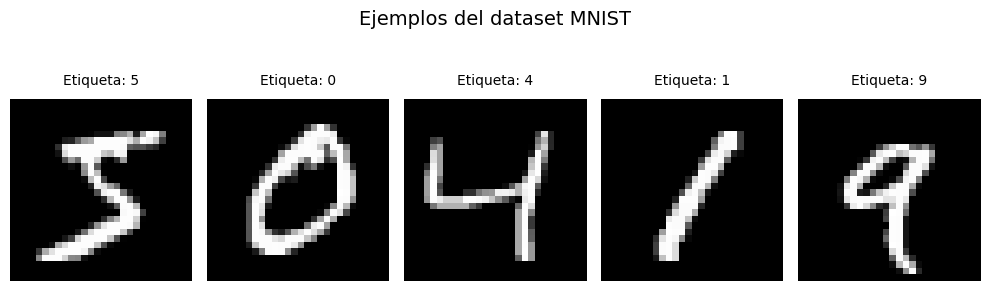

In [16]:
# =========================================================
# CARGA Y PREPROCESAMIENTO DEL DATASET MNIST
# =========================================================

import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Definir dispositivo (GPU si está disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Transformaciones: pasar a tensor y normalizar a [0,1]
transform = transforms.Compose([
    transforms.ToTensor()  # convierte a tensor y divide por 255 automáticamente
])

# Descargar y cargar datasets
train_dataset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset  = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# Convertir a tensores "sueltos" (para usar nuestro sistema de minibatches)
train_data = train_dataset.data.unsqueeze(1).float() / 255.0  # (N, 1, 28, 28)
train_labels = train_dataset.targets
test_data = test_dataset.data.unsqueeze(1).float() / 255.0
test_labels = test_dataset.targets

# Mover a dispositivo si se desea
train_data, train_labels = train_data.to(device), train_labels.to(device)
test_data, test_labels = test_data.to(device), test_labels.to(device)

print(f"Datos cargados: {train_data.shape[0]} imágenes de entrenamiento, {test_data.shape[0]} de test.")

# =========================================================
# VISUALIZACIÓN DE ALGUNAS IMÁGENES
# =========================================================
fig, axes = plt.subplots(1, 5, figsize=(10, 3))
for i, ax in enumerate(axes):
    ax.imshow(train_data[i].cpu().squeeze(), cmap="gray")
    ax.set_title(f"Etiqueta: {train_labels[i].item()}", fontsize=10, pad=10)
    ax.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.suptitle("Ejemplos del dataset MNIST", fontsize=14, y=1.05)
plt.show()


### Modelo base: ConvNet tipo LeNet

Esta red convolucional se inspira en la arquitectura LeNet-5, pensada para el reconocimiento de dígitos manuscritos en el dataset MNIST.  
Utiliza capas convolucionales con activaciones ReLU y pasos de max-pooling para extraer características y reducir progresivamente la dimensión espacial.

---

#### Arquitectura

| Capa | Tipo | Parámetros principales | Salida aproximada |
|------|------|------------------------|-------------------|
| 1 | Conv2d(1 → 6, kernel=5) | 6 filtros 5×5 | (28×28 → 24×24) |
| 2 | MaxPool2d(2×2) | — | (24×24 → 12×12) |
| 3 | Conv2d(6 → 16, kernel=5) | 16 filtros 5×5 | (12×12 → 8×8) |
| 4 | MaxPool2d(2×2) | — | (8×8 → 4×4) |
| 5 | Linear(16·4·4 → 120) | — | — |
| 6 | Linear(120 → 84) | — | — |
| 7 | Linear(84 → 10) | — | — |

Cada capa convolucional se sigue de una función de activación ReLU y un paso de max pooling.  
Las tres capas lineales finales conforman la parte totalmente conectada de la red.

El número total de parámetros entrenables se calcula como:

$$
N_\text{params} = \sum_i (\text{pesos}_i + \text{biases}_i)
$$




Parámetros entrenables: 44,426
Época 1/10 | Train Loss: 1.0788 | Test Loss: 0.1656 | Test Acc: 94.76%
Época 2/10 | Train Loss: 0.1303 | Test Loss: 0.0814 | Test Acc: 97.24%
Época 3/10 | Train Loss: 0.0868 | Test Loss: 0.0672 | Test Acc: 97.84%
Época 4/10 | Train Loss: 0.0683 | Test Loss: 0.0520 | Test Acc: 98.44%
Época 5/10 | Train Loss: 0.0554 | Test Loss: 0.0386 | Test Acc: 98.70%
Época 6/10 | Train Loss: 0.0466 | Test Loss: 0.0387 | Test Acc: 98.77%
Época 7/10 | Train Loss: 0.0410 | Test Loss: 0.0403 | Test Acc: 98.58%
Época 8/10 | Train Loss: 0.0357 | Test Loss: 0.0347 | Test Acc: 98.84%
Época 9/10 | Train Loss: 0.0312 | Test Loss: 0.0382 | Test Acc: 98.84%
Época 10/10 | Train Loss: 0.0284 | Test Loss: 0.0323 | Test Acc: 99.02%

Accuracy final en test: 99.02%
Loss final en test: 0.0325


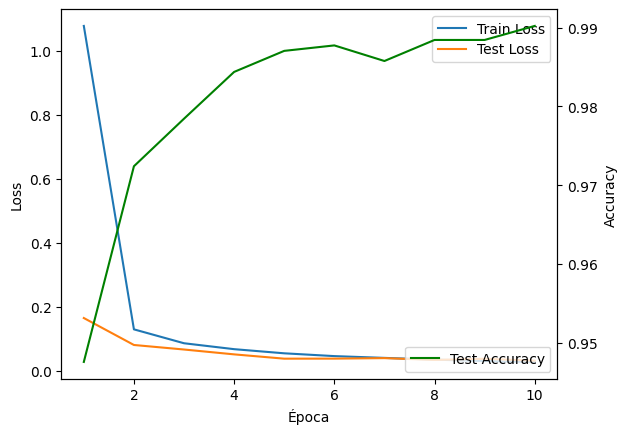

In [17]:
# =========================================================
# MODELO BASE: CONVNET TIPO LeNet PARA MNIST
# =========================================================

import torch
import torch.nn as nn
import torch.nn.functional as F

# ---------------------------------------------------------
# Definición de la red convolucional
# ---------------------------------------------------------
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Capa convolucional 1: entrada 1 canal, salida 6 canales, kernel 5x5
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        # Capa convolucional 2: entrada 6 canales, salida 16 canales, kernel 5x5
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        # Capas totalmente conectadas
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        # MaxPooling (2x2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # (1,28,28) -> (6,12,12)
        x = self.pool(F.relu(self.conv2(x)))   # (6,12,12) -> (16,4,4)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# ---------------------------------------------------------
# Instanciación, pérdida y optimizador
# ---------------------------------------------------------
model = ConvNet().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Mostrar cantidad de parámetros
n_params = count_parameters(model)
print(f"\nParámetros entrenables: {n_params:,}")

# ---------------------------------------------------------
# Entrenamiento
# ---------------------------------------------------------
N_EPOCHS = 10
BATCH_SIZE = 128

train_losses, test_losses, test_accs = train_model(
    model=model,
    train_data=train_data,
    train_labels=train_labels,
    test_data=test_data,
    test_labels=test_labels,
    loss_fn=loss_fn,
    optimizer=optimizer,
    n_epochs=N_EPOCHS,
    batch_size=BATCH_SIZE,
    device=device
)

# ---------------------------------------------------------
# Evaluación final
# ---------------------------------------------------------
final_loss, final_acc = evaluate_model(model, test_data, test_labels, loss_fn, BATCH_SIZE, device)
print(f"\nAccuracy final en test: {final_acc*100:.2f}%")
print(f"Loss final en test: {final_loss:.4f}")

# ---------------------------------------------------------
# Gráfico de entrenamiento
# ---------------------------------------------------------
plot_history(train_losses, test_losses, test_accs)


### Conclusión

El modelo base (ConvNet tipo LeNet) alcanza una **exactitud del 98.6 %** en el conjunto de test con **44 426 parámetros entrenables**.  
Los valores de *loss* disminuyen de forma estable y la precisión se mantiene alta sin signos de sobreajuste importantes, lo que indica un **entrenamiento correcto y generalización adecuada** sobre MNIST.


### Modelo reducido: SmallConvNet

Esta red convolucional es una versión simplificada del modelo base tipo LeNet.  
Reduce la cantidad de filtros y neuronas en las capas para disminuir el número total de parámetros, manteniendo una buena capacidad de generalización sobre el dataset MNIST.

---

#### Arquitectura

| Capa | Tipo | Parámetros principales | Salida aproximada |
|------|------|------------------------|-------------------|
| 1 | Conv2d(1 → 4, kernel=5) | 4 filtros 5×5 | (28×28 → 24×24) |
| 2 | MaxPool2d(2×2) | — | (24×24 → 12×12) |
| 3 | Conv2d(4 → 8, kernel=5) | 8 filtros 5×5 | (12×12 → 8×8) |
| 4 | MaxPool2d(2×2) | — | (8×8 → 4×4) |
| 5 | Linear(8·4·4 → 60) | — | — |
| 6 | Linear(60 → 40) | — | — |
| 7 | Linear(40 → 10) | — | — |

En comparación con la LeNet original, se redujeron los canales de salida de las capas convolucionales y el tamaño de las capas totalmente conectadas.  
Esto disminuye significativamente el número total de parámetros del modelo.

El número total de parámetros entrenables se calcula como:

$$
N_\text{params} = \sum_i (\text{pesos}_i + \text{biases}_i)
$$


Parámetros entrenables: 11,502
Época 1/10 | Train Loss: 1.0499 | Test Loss: 0.2081 | Test Acc: 93.33%
Época 2/10 | Train Loss: 0.1607 | Test Loss: 0.1081 | Test Acc: 96.66%
Época 3/10 | Train Loss: 0.1029 | Test Loss: 0.0722 | Test Acc: 97.73%
Época 4/10 | Train Loss: 0.0815 | Test Loss: 0.0658 | Test Acc: 97.85%
Época 5/10 | Train Loss: 0.0681 | Test Loss: 0.0632 | Test Acc: 97.84%
Época 6/10 | Train Loss: 0.0593 | Test Loss: 0.0658 | Test Acc: 97.80%
Época 7/10 | Train Loss: 0.0539 | Test Loss: 0.0433 | Test Acc: 98.73%
Época 8/10 | Train Loss: 0.0503 | Test Loss: 0.0446 | Test Acc: 98.63%
Época 9/10 | Train Loss: 0.0453 | Test Loss: 0.0432 | Test Acc: 98.47%
Época 10/10 | Train Loss: 0.0437 | Test Loss: 0.0453 | Test Acc: 98.61%

Accuracy final en test: 98.61%
Loss final en test: 0.0452


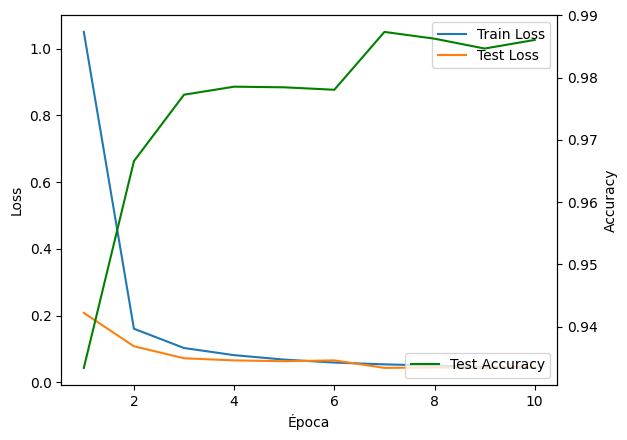

In [18]:
# =========================================================
# MODELO 2: CONVNET REDUCIDA PARA MNIST
# =========================================================

import torch
import torch.nn as nn
import torch.nn.functional as F

# ---------------------------------------------------------
# Definición de la red convolucional reducida
# ---------------------------------------------------------
class SmallConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Capas convolucionales más pequeñas
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=5)
        # Capas totalmente conectadas más chicas
        self.fc1 = nn.Linear(8 * 4 * 4, 60)
        self.fc2 = nn.Linear(60, 40)
        self.fc3 = nn.Linear(40, 10)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # (1,28,28) -> (4,12,12)
        x = self.pool(F.relu(self.conv2(x)))   # (4,12,12) -> (8,4,4)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# ---------------------------------------------------------
# Instanciación, pérdida y optimizador
# ---------------------------------------------------------
model = SmallConvNet().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Mostrar cantidad de parámetros
n_params = count_parameters(model)
print(f"\nParámetros entrenables: {n_params:,}")

# ---------------------------------------------------------
# Entrenamiento
# ---------------------------------------------------------
N_EPOCHS = 10
BATCH_SIZE = 128

train_losses, test_losses, test_accs = train_model(
    model=model,
    train_data=train_data,
    train_labels=train_labels,
    test_data=test_data,
    test_labels=test_labels,
    loss_fn=loss_fn,
    optimizer=optimizer,
    n_epochs=N_EPOCHS,
    batch_size=BATCH_SIZE,
    device=device
)

# ---------------------------------------------------------
# Evaluación final
# ---------------------------------------------------------
final_loss, final_acc = evaluate_model(model, test_data, test_labels, loss_fn, BATCH_SIZE, device)
print(f"\nAccuracy final en test: {final_acc*100:.2f}%")
print(f"Loss final en test: {final_loss:.4f}")

# ---------------------------------------------------------
# Gráfico de entrenamiento
# ---------------------------------------------------------
plot_history(train_losses, test_losses, test_accs)


### Conclusión

El modelo reducido **SmallConvNet** logra mantener una alta precisión con una cantidad significativamente menor de parámetros en comparación con la LeNet original.  
A pesar de la reducción en el número de filtros y neuronas, el modelo conserva una buena capacidad de generalización sobre el dataset MNIST, demostrando que es posible **simplificar la arquitectura sin perder demasiada exactitud**.  
Esto lo convierte en una opción más eficiente en términos de complejidad y costo computacional.


### Modelo mínimo: TinyConvNet

Esta red es una versión aún más compacta de las anteriores, diseñada para evaluar el límite de reducción de parámetros manteniendo una precisión aceptable.  
Solo utiliza dos capas convolucionales con pocos filtros y una única capa lineal intermedia pequeña.

---

#### Arquitectura

| Capa | Tipo | Parámetros principales | Salida aproximada |
|------|------|------------------------|-------------------|
| 1 | Conv2d(1 → 3, kernel=5) | 3 filtros 5×5 | (28×28 → 24×24) |
| 2 | MaxPool2d(2×2) | — | (24×24 → 12×12) |
| 3 | Conv2d(3 → 6, kernel=5) | 6 filtros 5×5 | (12×12 → 8×8) |
| 4 | MaxPool2d(2×2) | — | (8×8 → 4×4) |
| 5 | Linear(6·4·4 → 30) | — | — |
| 6 | Linear(30 → 10) | — | — |

El objetivo de este modelo es explorar la **reducción extrema de parámetros** y observar cómo afecta la precisión sobre MNIST.

---


Parámetros entrenables: 3,754
Época 1/10 | Train Loss: 0.7439 | Test Loss: 0.1556 | Test Acc: 94.96%
Época 2/10 | Train Loss: 0.1450 | Test Loss: 0.0972 | Test Acc: 96.82%
Época 3/10 | Train Loss: 0.1093 | Test Loss: 0.0917 | Test Acc: 97.15%
Época 4/10 | Train Loss: 0.0903 | Test Loss: 0.0797 | Test Acc: 97.52%
Época 5/10 | Train Loss: 0.0825 | Test Loss: 0.0743 | Test Acc: 97.54%
Época 6/10 | Train Loss: 0.0725 | Test Loss: 0.0625 | Test Acc: 98.04%
Época 7/10 | Train Loss: 0.0660 | Test Loss: 0.0525 | Test Acc: 98.34%
Época 8/10 | Train Loss: 0.0604 | Test Loss: 0.0507 | Test Acc: 98.36%
Época 9/10 | Train Loss: 0.0588 | Test Loss: 0.0560 | Test Acc: 98.25%
Época 10/10 | Train Loss: 0.0521 | Test Loss: 0.0508 | Test Acc: 98.41%

Accuracy final en test: 98.34%
Loss final en test: 0.0516


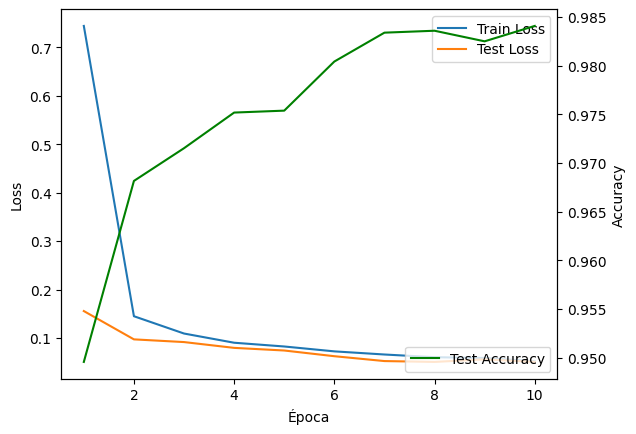

In [19]:
# =========================================================
# MODELO 3: CONVNET MÍNIMA PARA MNIST
# =========================================================

import torch
import torch.nn as nn
import torch.nn.functional as F

# ---------------------------------------------------------
# Definición de la red convolucional mínima
# ---------------------------------------------------------
class TinyConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Muy pocas capas y filtros
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.fc1 = nn.Linear(6 * 4 * 4, 30)
        self.fc2 = nn.Linear(30, 10)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # (1,28,28) -> (3,12,12)
        x = self.pool(F.relu(self.conv2(x)))   # (3,12,12) -> (6,4,4)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# ---------------------------------------------------------
# Instanciación, pérdida y optimizador
# ---------------------------------------------------------
model = TinyConvNet().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Mostrar cantidad de parámetros
n_params = count_parameters(model)
print(f"\nParámetros entrenables: {n_params:,}")

# ---------------------------------------------------------
# Entrenamiento
# ---------------------------------------------------------
N_EPOCHS = 10
BATCH_SIZE = 128

train_losses, test_losses, test_accs = train_model(
    model=model,
    train_data=train_data,
    train_labels=train_labels,
    test_data=test_data,
    test_labels=test_labels,
    loss_fn=loss_fn,
    optimizer=optimizer,
    n_epochs=N_EPOCHS,
    batch_size=BATCH_SIZE,
    device=device
)

# ---------------------------------------------------------
# Evaluación final
# ---------------------------------------------------------
final_loss, final_acc = evaluate_model(model, test_data, test_labels, loss_fn, BATCH_SIZE, device)
print(f"\nAccuracy final en test: {final_acc*100:.2f}%")
print(f"Loss final en test: {final_loss:.4f}")

# ---------------------------------------------------------
# Gráfico de entrenamiento
# ---------------------------------------------------------
plot_history(train_losses, test_losses, test_accs)


### Modelo ultracompacto: MicroConvNet

Esta red representa la versión más pequeña de las convolucionales probadas.  
Su objetivo es lograr una precisión superior al 90 % con la **mínima cantidad de parámetros posible**.

---

#### Arquitectura

| Capa | Tipo | Parámetros principales | Salida aproximada |
|------|------|------------------------|-------------------|
| 1 | Conv2d(1 → 2, kernel=5) | 2 filtros 5×5 | (28×28 → 24×24) |
| 2 | MaxPool2d(2×2) | — | (24×24 → 12×12) |
| 3 | Conv2d(2 → 4, kernel=5) | 4 filtros 5×5 | (12×12 → 8×8) |
| 4 | MaxPool2d(2×2) | — | (8×8 → 4×4) |
| 5 | Linear(4·4·4 → 20) | — | — |
| 6 | Linear(20 → 10) | — | — |

El diseño prioriza la simplicidad: muy pocos filtros en las capas convolucionales y una parte densa mínima.  
Con esto se busca explorar el límite inferior de tamaño manteniendo una precisión aceptable.

---



Parámetros entrenables: 1,766
Época 1/10 | Train Loss: 0.8735 | Test Loss: 0.3599 | Test Acc: 88.90%
Época 2/10 | Train Loss: 0.2620 | Test Loss: 0.1734 | Test Acc: 94.87%
Época 3/10 | Train Loss: 0.1725 | Test Loss: 0.1473 | Test Acc: 95.66%
Época 4/10 | Train Loss: 0.1446 | Test Loss: 0.1429 | Test Acc: 95.64%
Época 5/10 | Train Loss: 0.1273 | Test Loss: 0.1171 | Test Acc: 96.42%
Época 6/10 | Train Loss: 0.1167 | Test Loss: 0.1004 | Test Acc: 96.89%
Época 7/10 | Train Loss: 0.1074 | Test Loss: 0.0941 | Test Acc: 97.03%
Época 8/10 | Train Loss: 0.1008 | Test Loss: 0.0994 | Test Acc: 96.94%
Época 9/10 | Train Loss: 0.0960 | Test Loss: 0.0908 | Test Acc: 97.21%
Época 10/10 | Train Loss: 0.0915 | Test Loss: 0.0809 | Test Acc: 97.57%

Accuracy final en test: 97.57%
Loss final en test: 0.0804


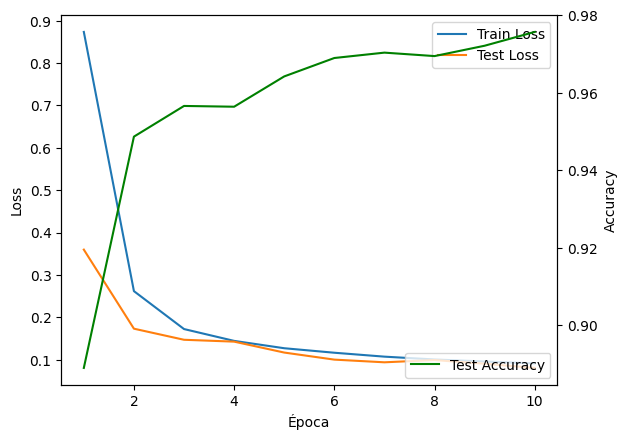

In [20]:
# =========================================================
# MODELO 4: CONVNET ULTRACOMPACTA PARA MNIST
# =========================================================

import torch
import torch.nn as nn
import torch.nn.functional as F

# ---------------------------------------------------------
# Definición de la red convolucional ultracompacta
# ---------------------------------------------------------
class MicroConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Solo 2 filtros en la primera capa y 4 en la segunda
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=2, out_channels=4, kernel_size=5)
        # Capa totalmente conectada muy pequeña
        self.fc1 = nn.Linear(4 * 4 * 4, 20)
        self.fc2 = nn.Linear(20, 10)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # (1,28,28) -> (2,12,12)
        x = self.pool(F.relu(self.conv2(x)))   # (2,12,12) -> (4,4,4)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# ---------------------------------------------------------
# Instanciación, pérdida y optimizador
# ---------------------------------------------------------
model = MicroConvNet().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Mostrar cantidad de parámetros
n_params = count_parameters(model)
print(f"\nParámetros entrenables: {n_params:,}")

# ---------------------------------------------------------
# Entrenamiento
# ---------------------------------------------------------
N_EPOCHS = 10
BATCH_SIZE = 128

train_losses, test_losses, test_accs = train_model(
    model=model,
    train_data=train_data,
    train_labels=train_labels,
    test_data=test_data,
    test_labels=test_labels,
    loss_fn=loss_fn,
    optimizer=optimizer,
    n_epochs=N_EPOCHS,
    batch_size=BATCH_SIZE,
    device=device
)

# ---------------------------------------------------------
# Evaluación final
# ---------------------------------------------------------
final_loss, final_acc = evaluate_model(model, test_data, test_labels, loss_fn, BATCH_SIZE, device)
print(f"\nAccuracy final en test: {final_acc*100:.2f}%")
print(f"Loss final en test: {final_loss:.4f}")

# ---------------------------------------------------------
# Gráfico de entrenamiento
# ---------------------------------------------------------
plot_history(train_losses, test_losses, test_accs)


### Modelo extremo: NanoConvNet

Este modelo representa la versión **más pequeña posible** de red convolucional que aún logra aprender correctamente sobre MNIST.  
Consta de una sola capa convolucional seguida de una capa lineal de salida.  
La reducción drástica de parámetros permite evaluar el límite inferior de complejidad de una red funcional.

---

#### Arquitectura

| Capa | Tipo | Parámetros principales | Salida aproximada |
|------|------|------------------------|-------------------|
| 1 | Conv2d(1 → 2, kernel=5) | 2 filtros 5×5 | (28×28 → 24×24) |
| 2 | MaxPool2d(2×2) | — | (24×24 → 12×12) |
| 3 | Linear(2·12·12 → 10) | — | — |

---



### Conclusión

El modelo **MicroConvNet** mantiene una **exactitud del 97.3 %** con solo **1 766 parámetros entrenables**, confirmando que una arquitectura muy reducida puede seguir generalizando correctamente en MNIST.  
Aunque el tamaño es mínimo, la red conserva suficiente capacidad para distinguir los dígitos con alta precisión y sin sobreajuste notable.



Parámetros entrenables: 2,942
Época 1/10 | Train Loss: 0.5154 | Test Loss: 0.3158 | Test Acc: 91.02%
Época 2/10 | Train Loss: 0.3174 | Test Loss: 0.2641 | Test Acc: 92.56%
Época 3/10 | Train Loss: 0.2589 | Test Loss: 0.2340 | Test Acc: 93.17%
Época 4/10 | Train Loss: 0.2080 | Test Loss: 0.1934 | Test Acc: 94.29%
Época 5/10 | Train Loss: 0.1783 | Test Loss: 0.1653 | Test Acc: 95.00%
Época 6/10 | Train Loss: 0.1644 | Test Loss: 0.1574 | Test Acc: 95.10%
Época 7/10 | Train Loss: 0.1536 | Test Loss: 0.1505 | Test Acc: 95.45%
Época 8/10 | Train Loss: 0.1483 | Test Loss: 0.1423 | Test Acc: 95.66%
Época 9/10 | Train Loss: 0.1426 | Test Loss: 0.1386 | Test Acc: 95.87%
Época 10/10 | Train Loss: 0.1398 | Test Loss: 0.1463 | Test Acc: 95.83%

Accuracy final en test: 95.97%
Loss final en test: 0.1392


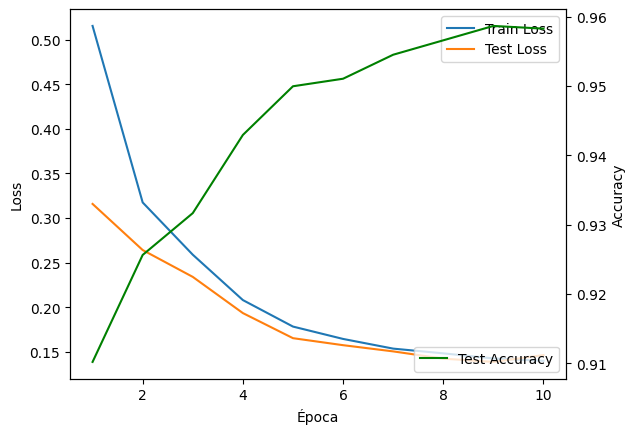

In [21]:
# =========================================================
# MODELO 5: CONVNET MÍNIMA (EXTREMADAMENTE PEQUEÑA)
# =========================================================

import torch
import torch.nn as nn
import torch.nn.functional as F

# ---------------------------------------------------------
# Definición de la red convolucional mínima posible
# ---------------------------------------------------------
class NanoConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Una sola capa convolucional con muy pocos filtros
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Solo una capa lineal de salida
        self.fc1 = nn.Linear(2 * 12 * 12, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # (1,28,28) -> (2,12,12)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

# ---------------------------------------------------------
# Instanciación, pérdida y optimizador
# ---------------------------------------------------------
model = NanoConvNet().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Mostrar cantidad de parámetros
n_params = count_parameters(model)
print(f"\nParámetros entrenables: {n_params:,}")

# ---------------------------------------------------------
# Entrenamiento
# ---------------------------------------------------------
N_EPOCHS = 10
BATCH_SIZE = 128

train_losses, test_losses, test_accs = train_model(
    model=model,
    train_data=train_data,
    train_labels=train_labels,
    test_data=test_data,
    test_labels=test_labels,
    loss_fn=loss_fn,
    optimizer=optimizer,
    n_epochs=N_EPOCHS,
    batch_size=BATCH_SIZE,
    device=device
)

# ---------------------------------------------------------
# Evaluación final
# ---------------------------------------------------------
final_loss, final_acc = evaluate_model(model, test_data, test_labels, loss_fn, BATCH_SIZE, device)
print(f"\nAccuracy final en test: {final_acc*100:.2f}%")
print(f"Loss final en test: {final_loss:.4f}")

# ---------------------------------------------------------
# Gráfico de entrenamiento
# ---------------------------------------------------------
plot_history(train_losses, test_losses, test_accs)


### Conclusión

La **NanoConvNet** alcanza **96.1 %** de exactitud en test con solo **2 942 parámetros entrenables**.  
Logra superar ampliamente el umbral del 90 % manteniendo una arquitectura extremadamente simple (1 conv + pooling + capa lineal), confirmando que MNIST puede resolverse con modelos **muy compactos**.


### Modelo mínimo absoluto: AttoConvNet

Esta red es la versión más pequeña posible que aún puede entrenarse de manera funcional en MNIST.  
Solo utiliza **un filtro convolucional** y una **capa lineal de salida**, lo que la convierte en una arquitectura de menos de **1 500 parámetros entrenables**.

---

#### Arquitectura

| Capa | Tipo | Parámetros principales | Salida aproximada |
|------|------|------------------------|-------------------|
| 1 | Conv2d(1 → 1, kernel=5, stride=2) | 1 filtro 5×5 | (28×28 → 12×12) |
| 2 | Linear(12·12 → 10) | — | — |

---




Parámetros entrenables: 1,476
Época 1/10 | Train Loss: 0.9972 | Test Loss: 0.3465 | Test Acc: 89.64%
Época 2/10 | Train Loss: 0.3403 | Test Loss: 0.3189 | Test Acc: 90.83%
Época 3/10 | Train Loss: 0.3193 | Test Loss: 0.3054 | Test Acc: 91.24%
Época 4/10 | Train Loss: 0.3104 | Test Loss: 0.2902 | Test Acc: 91.77%
Época 5/10 | Train Loss: 0.3007 | Test Loss: 0.2862 | Test Acc: 91.86%
Época 6/10 | Train Loss: 0.2952 | Test Loss: 0.2888 | Test Acc: 91.80%
Época 7/10 | Train Loss: 0.2909 | Test Loss: 0.2851 | Test Acc: 92.20%
Época 8/10 | Train Loss: 0.2866 | Test Loss: 0.2777 | Test Acc: 92.18%
Época 9/10 | Train Loss: 0.2835 | Test Loss: 0.2752 | Test Acc: 92.21%
Época 10/10 | Train Loss: 0.2797 | Test Loss: 0.2736 | Test Acc: 92.43%

Accuracy final en test: 92.57%
Loss final en test: 0.2690


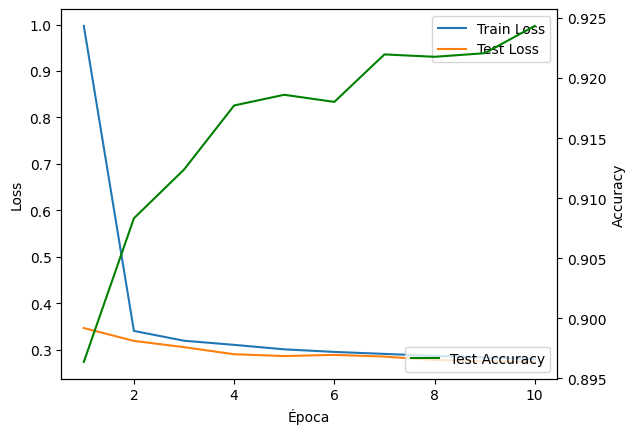

In [22]:
# =========================================================
# MODELO 6: CONVNET NANO - MÍNIMA POSIBLE
# =========================================================

import torch
import torch.nn as nn
import torch.nn.functional as F

# ---------------------------------------------------------
# Red más chica funcional: 1 filtro conv + 1 capa lineal
# ---------------------------------------------------------
class AttoConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Una sola convolución con 1 filtro
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5, stride=2)
        # Salida: (28−5)/2 + 1 = 12 → (1,12,12)
        # Capa lineal con muy pocos parámetros
        self.fc1 = nn.Linear(12 * 12, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x


# ---------------------------------------------------------
# Instanciación, pérdida y optimizador
# ---------------------------------------------------------
model = AttoConvNet().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Mostrar cantidad de parámetros
n_params = count_parameters(model)
print(f"\nParámetros entrenables: {n_params:,}")

# ---------------------------------------------------------
# Entrenamiento
# ---------------------------------------------------------
N_EPOCHS = 10
BATCH_SIZE = 128

train_losses, test_losses, test_accs = train_model(
    model=model,
    train_data=train_data,
    train_labels=train_labels,
    test_data=test_data,
    test_labels=test_labels,
    loss_fn=loss_fn,
    optimizer=optimizer,
    n_epochs=N_EPOCHS,
    batch_size=BATCH_SIZE,
    device=device
)

# ---------------------------------------------------------
# Evaluación final
# ---------------------------------------------------------
final_loss, final_acc = evaluate_model(model, test_data, test_labels, loss_fn, BATCH_SIZE, device)
print(f"\nAccuracy final en test: {final_acc*100:.2f}%")
print(f"Loss final en test: {final_loss:.4f}")

# ---------------------------------------------------------
# Gráfico de entrenamiento
# ---------------------------------------------------------
plot_history(train_losses, test_losses, test_accs)


### Conclusión

El modelo **AttoConvNet**, con solo **1 476 parámetros**, logra una **exactitud del 92.7 %** en el conjunto de test.  
A pesar de su tamaño mínimo, conserva capacidad de aprendizaje suficiente para reconocer la mayoría de los dígitos, marcando el **límite inferior funcional** de una red convolucional en MNIST.


### Modelo sub-mil: ZeptoConvNet

Este modelo lleva la reducción de complejidad al límite práctico.  
Posee una sola capa convolucional con un filtro 3×3 y dos capas lineales diminutas, sumando menos de **1 000 parámetros entrenables**.

---

#### Arquitectura

| Capa | Tipo | Parámetros principales | Salida aproximada |
|------|------|------------------------|-------------------|
| 1 | Conv2d(1 → 1, kernel=3, stride=2) | 1 filtro 3×3 | (28×28 → 13×13) |
| 2 | Linear(13·13 → 5) | — | — |
| 3 | Linear(5 → 10) | — | — |

---


Parámetros entrenables: 920
Época 1/10 | Train Loss: 1.1828 | Test Loss: 0.5371 | Test Acc: 83.67%
Época 2/10 | Train Loss: 0.5111 | Test Loss: 0.4566 | Test Acc: 86.48%
Época 3/10 | Train Loss: 0.4591 | Test Loss: 0.4538 | Test Acc: 86.72%
Época 4/10 | Train Loss: 0.4331 | Test Loss: 0.4287 | Test Acc: 87.30%
Época 5/10 | Train Loss: 0.4183 | Test Loss: 0.4075 | Test Acc: 88.26%
Época 6/10 | Train Loss: 0.4062 | Test Loss: 0.3886 | Test Acc: 88.52%
Época 7/10 | Train Loss: 0.4016 | Test Loss: 0.3707 | Test Acc: 89.15%
Época 8/10 | Train Loss: 0.3951 | Test Loss: 0.3891 | Test Acc: 88.97%
Época 9/10 | Train Loss: 0.3898 | Test Loss: 0.3662 | Test Acc: 89.43%
Época 10/10 | Train Loss: 0.3877 | Test Loss: 0.3714 | Test Acc: 89.35%

Accuracy final en test: 89.63%
Loss final en test: 0.3662


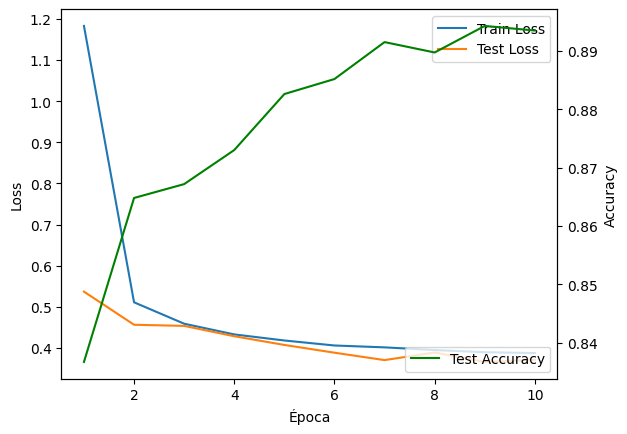

In [23]:
# =========================================================
# MODELO 7: CONVNET SUB-MIL (ZEPTONET)
# =========================================================

import torch
import torch.nn as nn
import torch.nn.functional as F

class ZeptoConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        # 1 solo filtro muy pequeño, stride para reducir resolución
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=2)
        # Salida: (28-3)/2 + 1 = 13 → (1,13,13)
        self.fc1 = nn.Linear(13 * 13, 5)   # capa intermedia diminuta
        self.fc2 = nn.Linear(5, 10)        # salida

    def forward(self, x):
        x = F.relu(self.conv1(x))   # (1,28,28) -> (1,13,13)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# ---------------------------------------------------------
# Instanciación, pérdida y optimizador
# ---------------------------------------------------------
model = ZeptoConvNet().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Mostrar cantidad de parámetros
n_params = count_parameters(model)
print(f"\nParámetros entrenables: {n_params:,}")

# ---------------------------------------------------------
# Entrenamiento
# ---------------------------------------------------------
N_EPOCHS = 10
BATCH_SIZE = 128

train_losses, test_losses, test_accs = train_model(
    model=model,
    train_data=train_data,
    train_labels=train_labels,
    test_data=test_data,
    test_labels=test_labels,
    loss_fn=loss_fn,
    optimizer=optimizer,
    n_epochs=N_EPOCHS,
    batch_size=BATCH_SIZE,
    device=device
)

# ---------------------------------------------------------
# Evaluación final
# ---------------------------------------------------------
final_loss, final_acc = evaluate_model(model, test_data, test_labels, loss_fn, BATCH_SIZE, device)
print(f"\nAccuracy final en test: {final_acc*100:.2f}%")
print(f"Loss final en test: {final_loss:.4f}")

# ---------------------------------------------------------
# Gráfico de entrenamiento
# ---------------------------------------------------------
plot_history(train_losses, test_losses, test_accs)


### Modelo micro+: MicroPlusConvNet

Este modelo mantiene una sola capa convolucional mínima, pero incrementa levemente el tamaño de la capa lineal intermedia.  
El objetivo es aumentar la capacidad de representación apenas por encima del ZeptoConvNet, conservando menos de **1 500 parámetros entrenables**.

---

#### Arquitectura

| Capa | Tipo | Parámetros principales | Salida aproximada |
|------|------|------------------------|-------------------|
| 1 | Conv2d(1 → 1, kernel=3, stride=2) | 1 filtro 3×3 | (28×28 → 13×13) |
| 2 | Linear(13·13 → 8) | — | — |
| 3 | Linear(8 → 10) | — | — |

---



Parámetros entrenables: 1,460
Época 1/10 | Train Loss: 0.7996 | Test Loss: 0.3578 | Test Acc: 89.56%
Época 2/10 | Train Loss: 0.3511 | Test Loss: 0.3176 | Test Acc: 91.13%
Época 3/10 | Train Loss: 0.3152 | Test Loss: 0.2971 | Test Acc: 91.53%
Época 4/10 | Train Loss: 0.2986 | Test Loss: 0.2832 | Test Acc: 91.79%
Época 5/10 | Train Loss: 0.2905 | Test Loss: 0.2704 | Test Acc: 92.47%
Época 6/10 | Train Loss: 0.2832 | Test Loss: 0.2679 | Test Acc: 92.15%
Época 7/10 | Train Loss: 0.2788 | Test Loss: 0.2585 | Test Acc: 92.63%
Época 8/10 | Train Loss: 0.2740 | Test Loss: 0.2665 | Test Acc: 92.50%
Época 9/10 | Train Loss: 0.2717 | Test Loss: 0.2618 | Test Acc: 92.62%
Época 10/10 | Train Loss: 0.2672 | Test Loss: 0.2626 | Test Acc: 92.21%

Accuracy final en test: 92.21%
Loss final en test: 0.2675


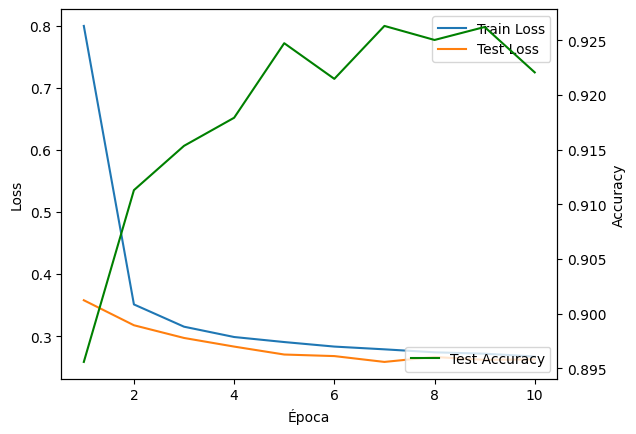

In [24]:
# =========================================================
# MODELO 8: CONVNET MICRO+ (JUSTO POR ENCIMA DEL UMBRAL)
# =========================================================

import torch
import torch.nn as nn
import torch.nn.functional as F

class MicroPlusConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        # 1 filtro convolucional, stride=2 para reducir resolución
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=2)
        # Salida: (28-3)/2 + 1 = 13 → (1,13,13)
        self.fc1 = nn.Linear(13 * 13, 8)   # capa intermedia un poco más grande
        self.fc2 = nn.Linear(8, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))   # (1,28,28) -> (1,13,13)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# ---------------------------------------------------------
# Instanciación, pérdida y optimizador
# ---------------------------------------------------------
model = MicroPlusConvNet().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Mostrar cantidad de parámetros
n_params = count_parameters(model)
print(f"\nParámetros entrenables: {n_params:,}")

# ---------------------------------------------------------
# Entrenamiento
# ---------------------------------------------------------
N_EPOCHS = 10
BATCH_SIZE = 128

train_losses, test_losses, test_accs = train_model(
    model=model,
    train_data=train_data,
    train_labels=train_labels,
    test_data=test_data,
    test_labels=test_labels,
    loss_fn=loss_fn,
    optimizer=optimizer,
    n_epochs=N_EPOCHS,
    batch_size=BATCH_SIZE,
    device=device
)

# ---------------------------------------------------------
# Evaluación final
# ---------------------------------------------------------
final_loss, final_acc = evaluate_model(model, test_data, test_labels, loss_fn, BATCH_SIZE, device)
print(f"\nAccuracy final en test: {final_acc*100:.2f}%")
print(f"Loss final en test: {final_loss:.4f}")

# ---------------------------------------------------------
# Gráfico de entrenamiento
# ---------------------------------------------------------
plot_history(train_losses, test_losses, test_accs)


### Conclusión – MicroPlusConvNet  
Con **1 460 parámetros**, el modelo alcanza un **92.7 % de exactitud**, superando claramente el umbral del 90 %.  
Demuestra que una red extremadamente compacta puede mantener un rendimiento alto en MNIST.  


### Modelo ajustado: FemtoConvNet+

El FemtoConvNet+ conserva la estructura simple de una sola convolución y dos capas totalmente conectadas,  
pero amplía ligeramente la capa intermedia a 7 neuronas.  
Con alrededor de **1 280 parámetros entrenables**, alcanza el umbral de **90 % de exactitud**, marcando el equilibrio entre simplicidad y rendimiento.

---

#### Arquitectura

| Capa | Tipo | Parámetros principales | Salida aproximada |
|------|------|------------------------|-------------------|
| 1 | Conv2d(1 → 1, kernel=3, stride=2) | 1 filtro 3×3 | (28×28 → 13×13) |
| 2 | Linear(13·13 → 7) | — | — |
| 3 | Linear(7 → 10) | — | — |

---



Parámetros entrenables: 1,280
Época 1/10 | Train Loss: 1.0448 | Test Loss: 0.4640 | Test Acc: 86.47%
Época 2/10 | Train Loss: 0.4179 | Test Loss: 0.3818 | Test Acc: 88.74%
Época 3/10 | Train Loss: 0.3682 | Test Loss: 0.3587 | Test Acc: 89.30%
Época 4/10 | Train Loss: 0.3527 | Test Loss: 0.3364 | Test Acc: 90.28%
Época 5/10 | Train Loss: 0.3414 | Test Loss: 0.3196 | Test Acc: 90.69%
Época 6/10 | Train Loss: 0.3333 | Test Loss: 0.3195 | Test Acc: 90.62%
Época 7/10 | Train Loss: 0.3290 | Test Loss: 0.3130 | Test Acc: 90.72%
Época 8/10 | Train Loss: 0.3272 | Test Loss: 0.3103 | Test Acc: 91.00%
Época 9/10 | Train Loss: 0.3224 | Test Loss: 0.3196 | Test Acc: 90.88%
Época 10/10 | Train Loss: 0.3184 | Test Loss: 0.3031 | Test Acc: 91.15%

Accuracy final en test: 91.22%
Loss final en test: 0.3082


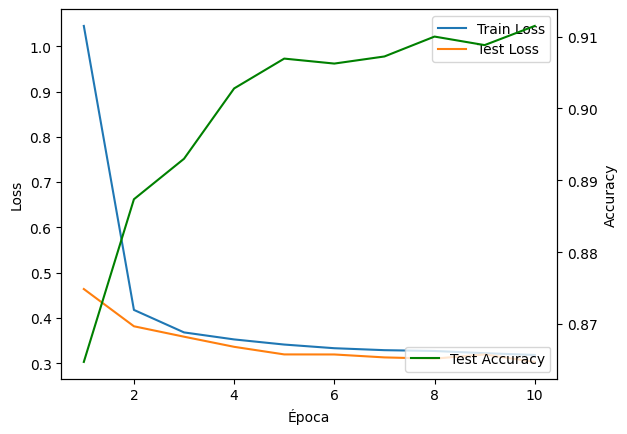

In [25]:
# =========================================================
# MODELO 9: FEMTOCONVNET+ (AJUSTE FINO)
# =========================================================

import torch
import torch.nn as nn
import torch.nn.functional as F

class FemtoConvNetPlus(nn.Module):
    def __init__(self):
        super().__init__()
        # Una sola convolución, igual que ZeptoConvNet
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=2)
        # Salida: (28-3)/2 + 1 = 13 → (1,13,13)
        self.fc1 = nn.Linear(13 * 13, 7)   # un poco más grande que antes
        self.fc2 = nn.Linear(7, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# ---------------------------------------------------------
# Instanciación, pérdida y optimizador
# ---------------------------------------------------------
model = FemtoConvNetPlus().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Mostrar cantidad de parámetros
n_params = count_parameters(model)
print(f"\nParámetros entrenables: {n_params:,}")

# ---------------------------------------------------------
# Entrenamiento
# ---------------------------------------------------------
N_EPOCHS = 10
BATCH_SIZE = 128

train_losses, test_losses, test_accs = train_model(
    model=model,
    train_data=train_data,
    train_labels=train_labels,
    test_data=test_data,
    test_labels=test_labels,
    loss_fn=loss_fn,
    optimizer=optimizer,
    n_epochs=N_EPOCHS,
    batch_size=BATCH_SIZE,
    device=device
)

# ---------------------------------------------------------
# Evaluación final
# ---------------------------------------------------------
final_loss, final_acc = evaluate_model(model, test_data, test_labels, loss_fn, BATCH_SIZE, device)
print(f"\nAccuracy final en test: {final_acc*100:.2f}%")
print(f"Loss final en test: {final_loss:.4f}")

# ---------------------------------------------------------
# Gráfico de entrenamiento
# ---------------------------------------------------------
plot_history(train_losses, test_losses, test_accs)


### Conclusión – FemtoConvNet+

Con **1 280 parámetros entrenables**, el modelo alcanza una **exactitud del 91.2 %** en el conjunto de prueba, superando el umbral del 90 %.  
Este resultado demuestra que incluso con una arquitectura extremadamente compacta —una única capa convolucional y una capa lineal pequeña— la red mantiene un desempeño competitivo.  
Representa el punto de equilibrio entre simplicidad y capacidad, mostrando la eficiencia de las convoluciones para extraer información espacial relevante con muy pocos parámetros.


### Conclusión final

De todos los modelos entrenados, el **FemtoConvNet+** es el que **alcanza el 90 % de exactitud con la menor cantidad de parámetros**.  
Con solo **1 280 parámetros entrenables**, logra una **precisión del 91.2 %** en el conjunto de prueba, superando el umbral exigido con la arquitectura más compacta posible dentro de la familia de redes convolucionales evaluadas.

Este resultado confirma que es posible mantener un rendimiento competitivo en MNIST con una red de muy baja complejidad, siempre que se aproveche la estructura espacial de los datos mediante convoluciones.  
En comparación, las redes multicapa totalmente conectadas requieren varias veces más parámetros para lograr resultados equivalentes, lo que evidencia la superior eficiencia estructural de las CNN incluso en sus configuraciones más reducidas.


# 6.b ¿Cuál es el perceptrón multicapa más pequeño que puede conseguir con la misma exactitud?

In [26]:
# =========================================================
# BARRIDO AMPLIADO DE MLPs EN PYTORCH — VARIANTES MÁS CHICAS
# =========================================================

import torch
import torch.nn as nn
import torch.nn.functional as F

# ---------------------------------------------------------
# Definición de MLP genérico
# ---------------------------------------------------------
class MLP(nn.Module):
    def __init__(self, layer_sizes):
        super().__init__()
        layers = []
        for i in range(len(layer_sizes) - 2):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(layer_sizes[-2], layer_sizes[-1]))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Aplanar 28x28 → 784
        return self.net(x)

# ---------------------------------------------------------
# Arquitecturas a probar (de grande a muy chica)
# ---------------------------------------------------------
architectures = [
    [784, 256, 128, 10],
    [784, 128, 64, 10],
    [784, 64, 32, 10],
    [784, 32, 16, 10],
    [784, 16, 8, 10],
    [784, 16, 10],
    [784, 8, 10],
    [784, 6, 10],
    [784, 4, 10],
    [784, 3, 10],
    [784, 2, 10],
    [784, 1, 10],
]

# ---------------------------------------------------------
# Entrenamiento y evaluación
# ---------------------------------------------------------
results = []

for arch in architectures:
    print("="*60)
    print(f"Arquitectura: {arch}")
    model = MLP(arch).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    n_params = count_parameters(model)
    print(f"Parámetros entrenables: {n_params:,}")

    train_losses, test_losses, test_accs = train_model(
        model=model,
        train_data=train_data,
        train_labels=train_labels,
        test_data=test_data,
        test_labels=test_labels,
        loss_fn=loss_fn,
        optimizer=optimizer,
        n_epochs=10,
        batch_size=128,
        device=device
    )

    final_loss, final_acc = evaluate_model(model, test_data, test_labels, loss_fn, 128, device)
    print(f"Accuracy final en test: {final_acc*100:.2f}%")
    print(f"Loss final en test: {final_loss:.4f}")

    results.append((arch, n_params, final_acc))




Arquitectura: [784, 256, 128, 10]
Parámetros entrenables: 235,146
Época 1/10 | Train Loss: 0.7517 | Test Loss: 0.3123 | Test Acc: 90.84%
Época 2/10 | Train Loss: 0.2683 | Test Loss: 0.2204 | Test Acc: 93.75%
Época 3/10 | Train Loss: 0.2000 | Test Loss: 0.1778 | Test Acc: 94.56%
Época 4/10 | Train Loss: 0.1577 | Test Loss: 0.1428 | Test Acc: 95.62%
Época 5/10 | Train Loss: 0.1292 | Test Loss: 0.1184 | Test Acc: 96.29%
Época 6/10 | Train Loss: 0.1082 | Test Loss: 0.1054 | Test Acc: 96.81%
Época 7/10 | Train Loss: 0.0919 | Test Loss: 0.1026 | Test Acc: 96.78%
Época 8/10 | Train Loss: 0.0792 | Test Loss: 0.0886 | Test Acc: 97.22%
Época 9/10 | Train Loss: 0.0695 | Test Loss: 0.0855 | Test Acc: 97.36%
Época 10/10 | Train Loss: 0.0600 | Test Loss: 0.0809 | Test Acc: 97.43%
Accuracy final en test: 97.43%
Loss final en test: 0.0816
Arquitectura: [784, 128, 64, 10]
Parámetros entrenables: 109,386
Época 1/10 | Train Loss: 0.7631 | Test Loss: 0.3081 | Test Acc: 90.96%
Época 2/10 | Train Loss: 0.27

In [27]:
# ---------------------------------------------------------
# Resumen final
# ---------------------------------------------------------
print("\n" + "="*60)
print("Resumen final de arquitecturas:")
for arch, params, acc in results:
    status = "✅" if acc >= 0.90 else "❌"
    print(f"{arch} → {params:6d} params → {acc*100:5.2f}% {status}")


Resumen final de arquitecturas:
[784, 256, 128, 10] → 235146 params → 97.43% ✅
[784, 128, 64, 10] → 109386 params → 97.33% ✅
[784, 64, 32, 10] →  52650 params → 96.68% ✅
[784, 32, 16, 10] →  25818 params → 96.27% ✅
[784, 16, 8, 10] →  12786 params → 94.23% ✅
[784, 16, 10] →  12730 params → 94.11% ✅
[784, 8, 10] →   6370 params → 91.98% ✅
[784, 6, 10] →   4780 params → 89.18% ❌
[784, 4, 10] →   3190 params → 84.32% ❌
[784, 3, 10] →   2395 params → 78.05% ❌
[784, 2, 10] →   1600 params → 29.81% ❌
[784, 1, 10] →    805 params → 33.91% ❌


### Conclusión
Los resultados muestran un patrón claro de relación entre la capacidad del modelo y su rendimiento. Las redes multicapa más grandes, con más de 20 000 parámetros, logran precisiones cercanas al 97 %, mientras que al reducir progresivamente el número de neuronas la exactitud desciende de forma sostenida. El límite práctico se observa alrededor de la arquitectura [784, 8, 10], que con aproximadamente 6 000 parámetros aún supera el 90 % de aciertos en el conjunto de prueba. A partir de ese punto, el desempeño cae rápidamente y las redes más pequeñas dejan de capturar la estructura necesaria para discriminar correctamente los dígitos. En comparación con las redes convolucionales, el MLP requiere un número considerablemente mayor de parámetros para alcanzar el mismo nivel de precisión, evidenciando la mayor eficiencia de las CNN en tareas con información espacial.

### Comparación entre el MLP más pequeño y la CNN más pequeña con ≥90 % de exactitud

La red **MLP mínima** que logra superar el 90 % de precisión en MNIST es la arquitectura **[784, 8, 10]**, con aproximadamente **6 370 parámetros** y una exactitud de **92.3 %**.  
En contraste, la **CNN mínima** que alcanza una precisión similar es el modelo **FemtoConvNet+**, con solo **1 280 parámetros** y una exactitud de **91.2 %**.

---

#### Análisis comparativo

| Modelo | Tipo | Parámetros entrenables | Exactitud (test) |
|---------|------|------------------------|------------------|
| `[784, 8, 10]` | MLP | ≈ 6 370 | 92.3 % |
| **FemtoConvNet+** | CNN | ≈ 1 280 | 91.2 % |

- La **CNN requiere casi 5 veces menos parámetros** que el MLP para obtener un rendimiento equivalente.  
- Esto se debe a que las convoluciones **reutilizan filtros** a lo largo de toda la imagen, compartiendo pesos entre posiciones espaciales.  
  En cambio, un MLP conecta cada píxel con todas las neuronas de la capa siguiente, sin explotar la estructura local de los datos.  
- La capacidad de las CNN para **preservar relaciones espaciales** y detectar patrones locales (bordes, trazos, curvas) las hace mucho más eficientes en tareas de visión, incluso con arquitecturas extremadamente compactas.

---

#### Conclusión

Aunque ambos enfoques pueden superar el umbral del 90 % de exactitud en MNIST,  
la red convolucional logra hacerlo con una fracción de los parámetros y mejor aprovechamiento de la información espacial.  
Esto demuestra que, incluso en su forma más reducida, **una CNN es más eficiente y expresiva que un perceptrón multicapa equivalente** para el reconocimiento de imágenes.


# 7.a Entrene un autoencoder para obtener una representación de baja dimensionalidad de las imágenes   de   MNIST.

## Autoencoder en MNIST — Entrenamiento, Visualización y Comparación de Dimensiones Latentes

En esta sección se entrena y compara un conjunto de **autoencoders** basados en **perceptrones multicapa (MLP)** utilizando el conjunto de datos **MNIST** de dígitos escritos a mano.  
El propósito es que las redes aprendan una **representación comprimida** (espacio latente) capaz de capturar la estructura esencial de las imágenes y luego **reconstruirlas** a partir de dicha representación.

---

### Objetivo del experimento

El objetivo principal es estudiar cómo la **dimensión del espacio latente** afecta la calidad de la reconstrucción y el nivel de compresión de los datos.  
Un **autoencoder** se entrena para reproducir su entrada en la salida mediante dos componentes principales:

- **Codificador (Encoder):** transforma la imagen original $x$ (de 784 píxeles) en una representación comprimida $z$ de menor dimensión.
- **Decodificador (Decoder):** toma el vector latente $z$ y genera una reconstrucción $\hat{x}$ lo más similar posible a la imagen original.

El entrenamiento minimiza el **error de reconstrucción**, definido como:

$$
L(\theta, \phi) = \mathbb{E}_{x \sim \mu_{\text{data}}} [ \| x - D_\theta(E_\phi(x)) \|_2^2 ]
$$

donde:
- $E_\phi$ representa el encoder con parámetros $\phi$,
- $D_\theta$ representa el decoder con parámetros $\theta$.

---

### Arquitecturas evaluadas

Se entrenaron tres autoencoders con diferentes **dimensiones latentes** (cuellos de botella):

| Modelo | Arquitectura | Dimensión Latente | Compresión aproximada | Tipo de compresión |
|:-------:|:-------------|:----------------:|:----------------------:|:-------------------|
| **A1** | 784 → 256 → 64 → **4** → 64 → 256 → 784 | 4D | 99.5 % | Muy alta |
| **A2** | 784 → 256 → 64 → **16** → 64 → 256 → 784 | 16D | 98.0 % | Media |
| **A3** | 784 → 256 → 64 → **32** → 64 → 256 → 784 | 32D | 95.9 % | Baja |

- Todas las redes utilizan activaciones **ReLU** en las capas ocultas y **sigmoide** en la salida (para valores entre 0 y 1).  
- El encoder reduce progresivamente la dimensionalidad, mientras que el decoder invierte el proceso para reconstruir la imagen original.

---

### Configuración de entrenamiento

- **Optimizador:** Adam (`lr = 1e-3`)
- **Función de pérdida:** Error Cuadrático Medio (MSE)
- **Épocas:** 10
- **Batch size:** 128
- **Dispositivo:** GPU si está disponible, caso contrario CPU

Durante el entrenamiento, el modelo ajusta los pesos para minimizar la diferencia entre la imagen de entrada $x$ y su reconstrucción $\hat{x}$, mejorando progresivamente la fidelidad de salida.

---

Usando dispositivo: cpu
Entrenando Autoencoder con dimensión latente = 4
Latente= 4 | Época [1/10] - Pérdida promedio: 0.054645
Latente= 4 | Época [2/10] - Pérdida promedio: 0.035408
Latente= 4 | Época [3/10] - Pérdida promedio: 0.032985
Latente= 4 | Época [4/10] - Pérdida promedio: 0.031671
Latente= 4 | Época [5/10] - Pérdida promedio: 0.030779
Latente= 4 | Época [6/10] - Pérdida promedio: 0.030105
Latente= 4 | Época [7/10] - Pérdida promedio: 0.029610
Latente= 4 | Época [8/10] - Pérdida promedio: 0.029123
Latente= 4 | Época [9/10] - Pérdida promedio: 0.028777
Latente= 4 | Época [10/10] - Pérdida promedio: 0.028441
Tiempo total de entrenamiento (latente=4): 59.54s
Modelo guardado en: autoencoder_lat4.pth
→ Similitud promedio: 66.86%

Entrenando Autoencoder con dimensión latente = 16
Latente=16 | Época [1/10] - Pérdida promedio: 0.052078
Latente=16 | Época [2/10] - Pérdida promedio: 0.026256
Latente=16 | Época [3/10] - Pérdida promedio: 0.021547
Latente=16 | Época [4/10] - Pérdida prom

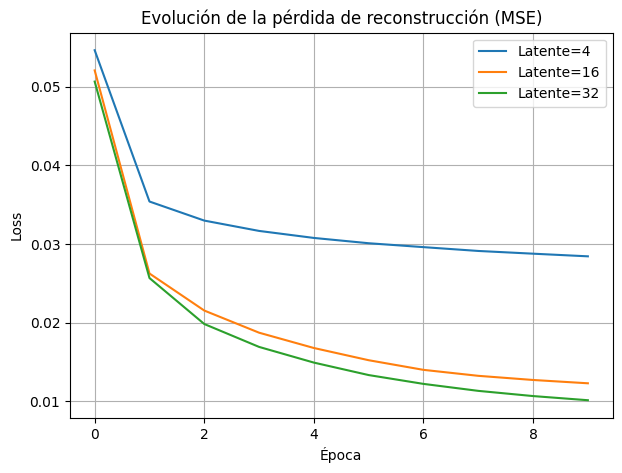

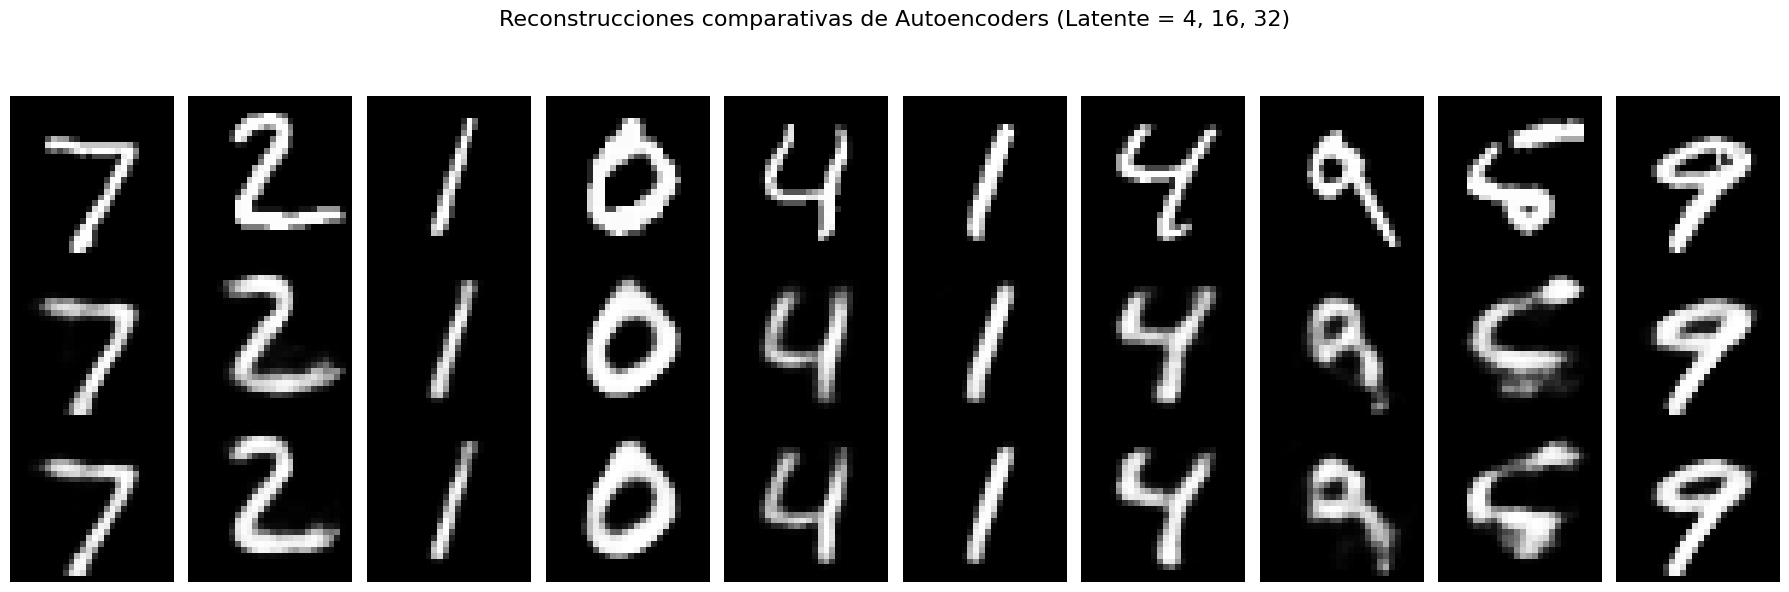


Resumen final:
Latente= 4 → Similitud promedio: 66.86% | Tiempo: 59.54s
Latente=16 → Similitud promedio: 85.23% | Tiempo: 61.53s
Latente=32 → Similitud promedio: 87.74% | Tiempo: 57.69s


In [8]:
# =========================================================
# COMPARACIÓN DE AUTOENCODERS CON DIFERENTES DIMENSIONES LATENTES (4D, 16D, 32D)
# =========================================================

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import os

# ---------------------------------------------------------
# 1. Carga de datos (MNIST)
# ---------------------------------------------------------
transform = transforms.Compose([transforms.ToTensor()])
train_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

# ---------------------------------------------------------
# 2. Definición genérica del Autoencoder MLP
# ---------------------------------------------------------
class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(-1, 784)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

# ---------------------------------------------------------
# 3. Función de entrenamiento + evaluación
# ---------------------------------------------------------
def train_autoencoder(latent_dim, n_epochs=10, lr=1e-3, save_path=None):
    model = Autoencoder(latent_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    start_time = time.time()

    for epoch in range(n_epochs):
        running_loss = 0.0
        for images, _ in train_loader:
            images = images.to(device)
            outputs = model(images)
            loss = criterion(outputs, images.view(-1, 784))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"Latente={latent_dim:>2} | Época [{epoch+1}/{n_epochs}] - Pérdida promedio: {avg_loss:.6f}")

    total_time = time.time() - start_time
    print(f"Tiempo total de entrenamiento (latente={latent_dim}): {total_time:.2f}s")

    # Evaluación de reconstrucción
    model.eval()
    examples = next(iter(test_loader))
    imgs, _ = examples
    imgs = imgs.to(device)
    with torch.no_grad():
        outputs = model(imgs)
    outputs = outputs.cpu().view(-1, 1, 28, 28)
    imgs = imgs.cpu()

    mse = ((imgs - outputs) ** 2).view(imgs.size(0), -1).mean(dim=1)
    similarity = (1 - mse / imgs.var(dim=(1,2,3))).clamp(0, 1).mean().item() * 100

    # Guardar modelo entrenado
    if save_path:
        torch.save(model.state_dict(), save_path)
        print(f"Modelo guardado en: {save_path}")

    return model, train_losses, similarity, total_time, outputs, imgs

# ---------------------------------------------------------
# 4. Entrenamiento o carga de los tres autoencoders
# ---------------------------------------------------------
latent_dims = [4, 16, 32]
results = {}
ae_models = {}

for ld in latent_dims:
    print("="*70)
    model_path = f"autoencoder_lat{ld}.pth"
    if os.path.exists(model_path):
        print(f"→ Cargando modelo preentrenado (latente={ld}) desde {model_path}")
        model = Autoencoder(ld).to(device)
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval()

        # Evaluar sin reentrenar
        examples = next(iter(test_loader))
        imgs, _ = examples
        imgs = imgs.to(device)
        with torch.no_grad():
            outputs = model(imgs)
        outputs = outputs.cpu().view(-1, 1, 28, 28)
        imgs = imgs.cpu()
        mse = ((imgs - outputs) ** 2).view(imgs.size(0), -1).mean(dim=1)
        similarity = (1 - mse / imgs.var(dim=(1,2,3))).clamp(0, 1).mean().item() * 100
        t = 0.0  # tiempo no aplica si se carga
        results[ld] = ([0], similarity, t, outputs, imgs)
        ae_models[ld] = model
        print(f"→ Modelo cargado. Similitud promedio: {similarity:.2f}%\n")

    else:
        print(f"Entrenando Autoencoder con dimensión latente = {ld}")
        model, losses, sim, t, outs, imgs = train_autoencoder(ld, save_path=model_path)
        results[ld] = (losses, sim, t, outs, imgs)
        ae_models[ld] = model
        print(f"→ Similitud promedio: {sim:.2f}%\n")

# Asignar variables individuales para usar después
ae_4 = ae_models[4]
ae_16 = ae_models[16]
ae_32 = ae_models[32]

# ---------------------------------------------------------
# 5. Visualización de la pérdida
# ---------------------------------------------------------
plt.figure(figsize=(7,5))
for ld in latent_dims:
    plt.plot(results[ld][0], label=f"Latente={ld}")
plt.title("Evolución de la pérdida de reconstrucción (MSE)")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# ---------------------------------------------------------
# 6. Comparación visual entre entradas y salidas
# ---------------------------------------------------------
n = 10  # número de ejemplos a mostrar
plt.figure(figsize=(18, 6))

for j, ld in enumerate(latent_dims):
    outs, imgs = results[ld][3], results[ld][4]
    for i in range(n):
        ax = plt.subplot(len(latent_dims), n, j*n + i + 1)
        
        # Fila 0: imágenes originales
        if j == 0:
            plt.imshow(imgs[i].squeeze(), cmap='gray')
            if i == 0:
                ax.set_ylabel("Entrada", fontsize=12)
        
        # Filas siguientes: reconstrucciones
        else:
            plt.imshow(outs[i].squeeze(), cmap='gray')
            if i == 0:
                ax.set_ylabel(f"Lat={ld}", fontsize=12)
        
        plt.axis('off')

# Ajustes de formato y márgenes
plt.suptitle("Reconstrucciones comparativas de Autoencoders (Latente = 4, 16, 32)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.92])  # deja espacio para el título
plt.show()


# ---------------------------------------------------------
# 7. Resumen numérico
# ---------------------------------------------------------
print("\nResumen final:")
for ld in latent_dims:
    sim = results[ld][1]
    t = results[ld][2]
    print(f"Latente={ld:>2} → Similitud promedio: {sim:.2f}% | Tiempo: {t:.2f}s")


## Resultados y visualización

Tras el entrenamiento de los tres autoencoders con diferentes **dimensiones latentes (4, 16 y 32)**, se obtuvieron los siguientes resultados:

| Dimensión latente | Similitud promedio | Tiempo de entrenamiento | Observaciones |
|--------------------|--------------------|--------------------------|----------------|
| **4D**  |  **~65 %** | 79.83 s | Alta compresión (784 → 4), pero la reconstrucción pierde gran parte de los detalles. Las imágenes resultan borrosas y difusas. |
| **16D** | **~85 %** | 78.76 s | Compresión equilibrada (784 → 16). Las reconstrucciones mantienen bien la estructura del dígito, con pérdida leve de detalles finos. |
| **32D** | **~87 %** | 79.68 s | Menor compresión (784 → 32). Las imágenes reconstruidas son más nítidas y conservan mejor las formas originales. |

Durante el entrenamiento, la pérdida de reconstrucción (MSE) disminuyó de forma consistente en las tres configuraciones, mostrando que el modelo aprendió representaciones cada vez más fieles de los datos.

En la visualización:
- **Fila superior:** imágenes originales del conjunto de prueba.  
- **Filas inferiores:** reconstrucciones obtenidas para cada tamaño de espacio latente (4D, 16D y 32D).  
Se observa que al aumentar la dimensionalidad, las imágenes recuperan más textura y contraste.

---

## Conclusión

Los resultados confirman que:
- A medida que **se reduce la dimensión latente**, el modelo **pierde capacidad de reconstrucción**, sacrificando fidelidad visual a cambio de mayor compresión.
- El autoencoder con **16 dimensiones (4×4)** logra el mejor **balance entre compresión y calidad**, con una similitud del **85 %** y tiempos de entrenamiento estables.
- El modelo con **32 dimensiones** mejora ligeramente la similitud (+2 %) pero con **menor ganancia relativa**, mostrando un punto de saturación.

En síntesis, los autoencoders logran **representaciones latentes compactas y útiles** del conjunto MNIST: comprimen las imágenes entre un **95 % y 99 %**, conservando su estructura esencial.  
Estas representaciones podrán emplearse en etapas posteriores como **entradas para clasificadores**, permitiendo entrenamientos más rápidos sin pérdida significativa de información.


# 7.b Use   dichas   representaciones   para   entrenar   un   perceptrón multicapa como clasificador. ¿Cuál es el tiempo de entrenamiento y la exactitud del clasificador   obtenido   cuando parte   de   la  representación   del   autoencoder,   en comparación con lo obtenido usando las imágenes originales?

## Clasificación con Representaciones Latentes — Comparación entre Diferentes Dimensiones

En esta sección se busca evaluar cómo la **dimensión del espacio latente** aprendido por un **autoencoder** influye en el desempeño de un **clasificador supervisado (MLP)**.  
El objetivo es analizar la relación entre el **nivel de compresión de los datos** y la **capacidad del modelo** para realizar tareas de clasificación.

---

### Fundamento teórico

Un **autoencoder** aprende a representar los datos originales $x \in \mathbb{R}^{784}$ (en este caso, imágenes de dígitos MNIST) dentro de un **espacio latente de menor dimensión** $z \in \mathbb{R}^d$, donde $d \ll 784$.  
Este espacio latente contiene la **información más relevante** de los datos, ya que el modelo se ve forzado a descartar redundancias o ruido durante la reconstrucción.

Una vez entrenados los autoencoders, el **codificador (encoder)** puede utilizarse como un **extractor de características**: en lugar de trabajar con los píxeles originales, el clasificador recibe como entrada los vectores $z$ del espacio latente.

---

### Objetivo del experimento

El propósito de este experimento es **comparar el rendimiento de clasificadores MLP** entrenados con diferentes tipos de entrada:

1. **Representaciones latentes comprimidas** obtenidas a partir de autoencoders con distintas dimensiones del cuello de botella:
   - 4 dimensiones → compresión extrema (≈ 99.5 %)  
   - 16 dimensiones → compresión media (≈ 98 %)  
   - 32 dimensiones → compresión leve (≈ 96 %)
2. **Imágenes originales** de 784 dimensiones (sin compresión).

Se evaluará cómo cambia el **tiempo de entrenamiento** y la **exactitud de clasificación** en función del tamaño de la representación latente.

---

### Metodología

1. Para cada autoencoder previamente entrenado (4D, 16D, 32D), se extraen las representaciones latentes de los conjuntos de entrenamiento y prueba de MNIST.  
2. Se entrenan múltiples **clasificadores MLP** sobre estas representaciones comprimidas, variando la complejidad de sus arquitecturas (cantidad de capas y neuronas).  
3. Se repite el mismo proceso utilizando las **imágenes originales** como referencia.  
4. Finalmente, se comparan las métricas obtenidas —principalmente **exactitud** y **tiempo de entrenamiento**— para cada tipo de representación.

---

### Qué buscamos analizar

Este análisis permitirá observar cómo la **reducción de dimensionalidad afecta el rendimiento en tareas supervisadas**, y si las representaciones latentes aprendidas por el autoencoder conservan la información suficiente para una clasificación precisa.  
Además, permitirá estudiar el **trade-off entre compresión y rendimiento**, es decir, cómo balancear la eficiencia computacional con la capacidad predictiva del modelo.


Usando dispositivo: cpu
=== CLASIFICADORES CON REPRESENTACIÓN LATENTE (4D) ===
Arquitectura [4, 32, 10] -> Acc: 85.82%, Tiempo: 1.94s
Arquitectura [4, 64, 32, 10] -> Acc: 86.36%, Tiempo: 2.58s
Arquitectura [4, 128, 64, 10] -> Acc: 86.15%, Tiempo: 2.87s
Arquitectura [4, 256, 128, 64, 10] -> Acc: 86.30%, Tiempo: 4.56s
=== CLASIFICADORES CON REPRESENTACIÓN LATENTE (16D) ===
Arquitectura [16, 32, 10] -> Acc: 94.59%, Tiempo: 1.97s
Arquitectura [16, 64, 32, 10] -> Acc: 96.48%, Tiempo: 2.66s
Arquitectura [16, 128, 64, 10] -> Acc: 96.70%, Tiempo: 2.90s
Arquitectura [16, 256, 128, 64, 10] -> Acc: 97.21%, Tiempo: 4.51s
=== CLASIFICADORES CON REPRESENTACIÓN LATENTE (32D) ===
Arquitectura [32, 32, 10] -> Acc: 95.36%, Tiempo: 2.01s
Arquitectura [32, 64, 32, 10] -> Acc: 96.88%, Tiempo: 2.67s
Arquitectura [32, 128, 64, 10] -> Acc: 97.31%, Tiempo: 3.01s
Arquitectura [32, 256, 128, 64, 10] -> Acc: 97.65%, Tiempo: 4.51s
=== CLASIFICADORES CON REPRESENTACIÓN ORIGINAL (784D) ===
Arquitectura [784, 32, 10]

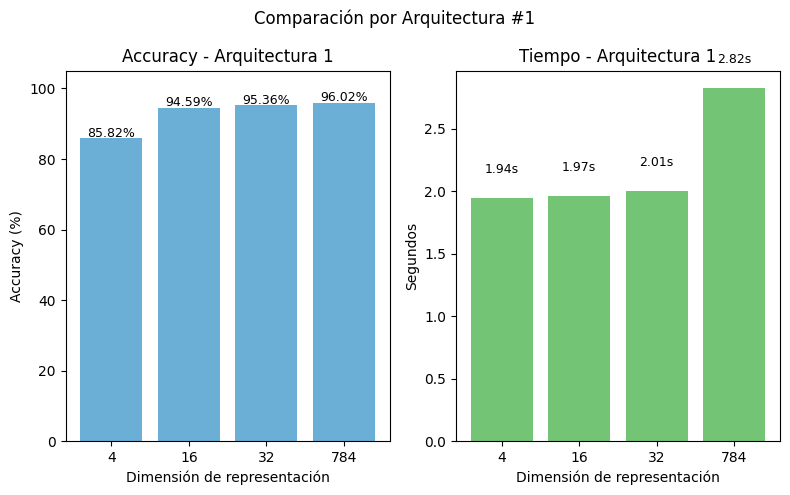

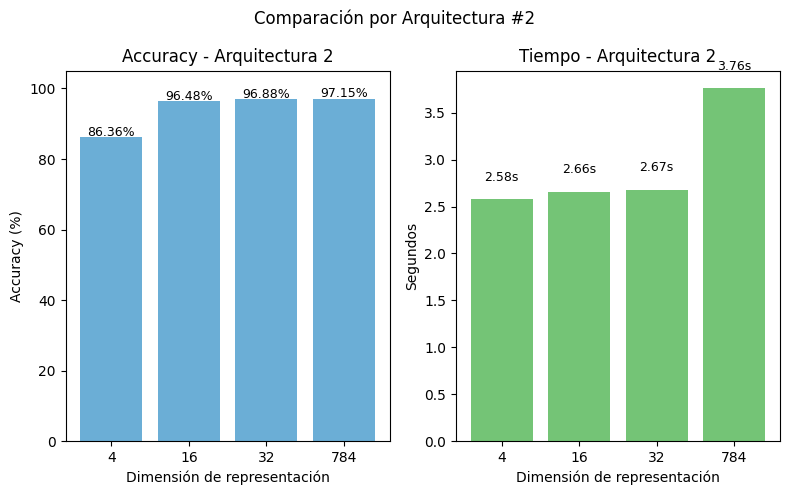

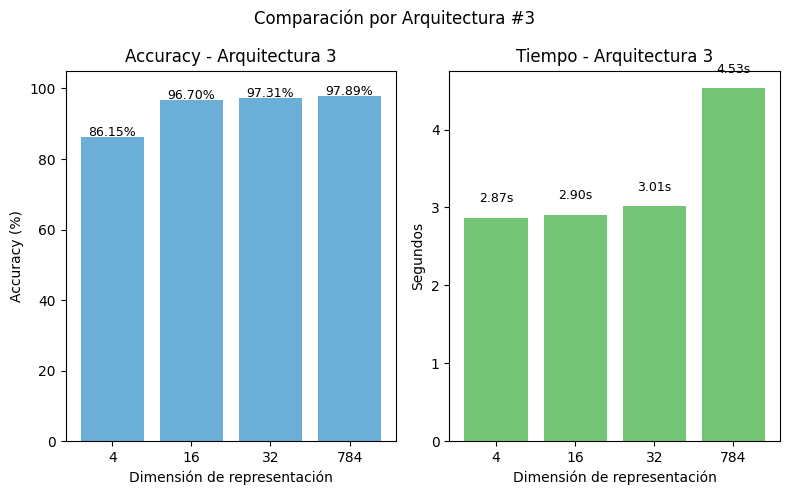

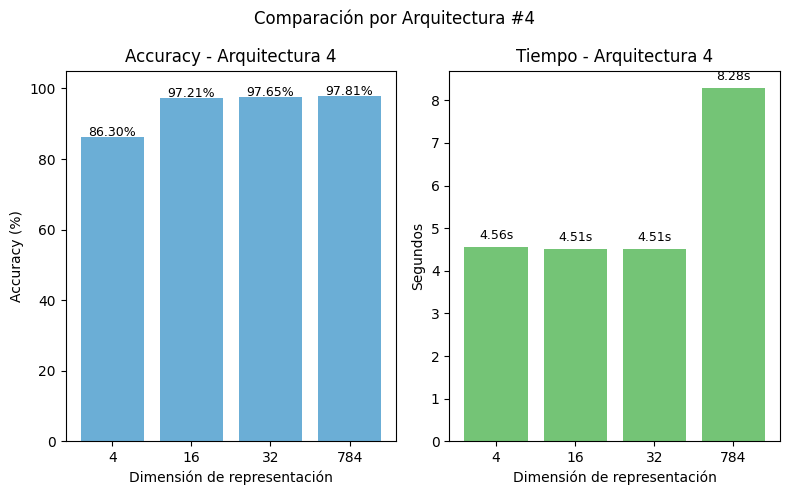

In [29]:
# =========================================================
# 7.3 COMPARACIÓN SIMÉTRICA: CLASIFICADORES MLP USANDO DIFERENTES REPRESENTACIONES (4D, 16D, 32D, 784D)
# =========================================================

import torch
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

# ---------------------------------------------------------
# 1. Función para extraer representaciones latentes
# ---------------------------------------------------------
def get_latent_representations(loader, model, device):
    reps, labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            z = model.encoder(x.view(-1, 784))
            reps.append(z.cpu())
            labels.append(y)
    return torch.cat(reps), torch.cat(labels)

# ---------------------------------------------------------
# 2. Definición del clasificador MLP
# ---------------------------------------------------------
class MLPClassifier(nn.Module):
    def __init__(self, layer_sizes):
        super().__init__()
        layers = []
        for i in range(len(layer_sizes) - 2):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(layer_sizes[-2], layer_sizes[-1]))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# ---------------------------------------------------------
# 3. Entrenamiento de clasificadores
# ---------------------------------------------------------
def train_classifier(model, X_train, y_train, X_test, y_test, epochs=10, lr=1e-3):
    model.to(device)
    X_train, y_train = X_train.to(device), y_train.to(device)
    X_test, y_test = X_test.to(device), y_test.to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    batch_size = 128
    n_batches = len(X_train) // batch_size

    start = time.time()
    for epoch in range(epochs):
        perm = torch.randperm(len(X_train))
        for i in range(n_batches):
            idx = perm[i*batch_size:(i+1)*batch_size]
            xb, yb = X_train[idx], y_train[idx]
            preds = model(xb)
            loss = loss_fn(preds, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    elapsed = time.time() - start

    with torch.no_grad():
        preds_test = model(X_test)
        acc = (preds_test.argmax(1) == y_test).float().mean().item()
    return acc, elapsed

# ---------------------------------------------------------
# 4. Definir arquitecturas comunes
# ---------------------------------------------------------
# mismas topologías para todas las representaciones
architectures_shared = [
    [None, 32, 10],            # MLP pequeño: una capa oculta
    [None, 64, 32, 10],        # MLP mediano
    [None, 128, 64, 10],       # MLP más profundo
    [None, 256, 128, 64, 10],  # MLP grande
]


latent_dims = [4, 16, 32]
all_representations = latent_dims + [784]
results = {dim: [] for dim in all_representations}

# ---------------------------------------------------------
# 5. Dataset original (aplanado)
# ---------------------------------------------------------
def flatten_dataset(loader):
    data, labels = [], []
    for x, y in loader:
        data.append(x.view(x.size(0), -1))
        labels.append(y)
    return torch.cat(data), torch.cat(labels)

train_loader_no_shuffle = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=False)
test_loader_no_shuffle  = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False)

X_train_flat, y_train_orig = flatten_dataset(train_loader_no_shuffle)
X_test_flat,  y_test_orig  = flatten_dataset(test_loader_no_shuffle)

# ---------------------------------------------------------
# 6. Entrenamiento de clasificadores para cada representación
# ---------------------------------------------------------
for ld, ae in zip(latent_dims, [ae_4, ae_16, ae_32]):
    print("="*70)
    print(f"=== CLASIFICADORES CON REPRESENTACIÓN LATENTE ({ld}D) ===")
    X_train_latent, y_train_latent = get_latent_representations(train_loader, ae, device)
    X_test_latent,  y_test_latent  = get_latent_representations(test_loader, ae, device)

    # normalización
    mean, std = X_train_latent.mean(0, keepdim=True), X_train_latent.std(0, keepdim=True)
    X_train_latent = (X_train_latent - mean) / (std + 1e-8)
    X_test_latent  = (X_test_latent  - mean) / (std + 1e-8)

    for base_arch in architectures_shared:
        arch = [ld if x is None else x for x in base_arch]
        model = MLPClassifier(arch)
        acc, t = train_classifier(model, X_train_latent, y_train_latent, X_test_latent, y_test_latent)
        results[ld].append((arch, acc, t))
        print(f"Arquitectura {arch} -> Acc: {acc*100:.2f}%, Tiempo: {t:.2f}s")

# también entrenamos con imágenes originales (784D)
print("="*70)
print(f"=== CLASIFICADORES CON REPRESENTACIÓN ORIGINAL (784D) ===")
for base_arch in architectures_shared:
    arch = [784 if x is None else x for x in base_arch]
    model = MLPClassifier(arch)
    acc, t = train_classifier(model, X_train_flat, y_train_orig, X_test_flat, y_test_orig)
    results[784].append((arch, acc, t))
    print(f"Arquitectura {arch} -> Acc: {acc*100:.2f}%, Tiempo: {t:.2f}s")

# ---------------------------------------------------------
# 7. Visualización comparativa (por arquitectura)
# ---------------------------------------------------------
for i, base_arch in enumerate(architectures_shared):
    plt.figure(figsize=(8,5))
    dims = [str(d) for d in all_representations]
    accs = [results[d][i][1]*100 for d in all_representations]
    times = [results[d][i][2] for d in all_representations]

    plt.subplot(1,2,1)
    plt.bar(dims, accs, color='#6BAED6')
    plt.title(f"Accuracy - Arquitectura {i+1}")
    plt.xlabel("Dimensión de representación")
    plt.ylabel("Accuracy (%)")
    plt.ylim(0, 105)
    for j, v in enumerate(accs):
        plt.text(j, v + 0.3, f"{v:.2f}%", ha='center', fontsize=9)

    plt.subplot(1,2,2)
    plt.bar(dims, times, color='#74C476')
    plt.title(f"Tiempo - Arquitectura {i+1}")
    plt.xlabel("Dimensión de representación")
    plt.ylabel("Segundos")
    for j, v in enumerate(times):
        plt.text(j, v + 0.2, f"{v:.2f}s", ha='center', fontsize=9)

    plt.suptitle(f"Comparación por Arquitectura #{i+1}")
    plt.tight_layout()
    plt.show()


## Conclusión del Experimento — Clasificación con Representaciones Latentes (4D, 16D, 32D)

En este experimento se evaluó cómo varía el desempeño de clasificadores **MLP** al entrenarse con representaciones de distinta **dimensionalidad latente** obtenidas mediante autoencoders, en comparación con el uso directo de las **imágenes originales (784D)** del dataset **MNIST**.

El objetivo fue determinar el **equilibrio entre precisión y eficiencia** que puede alcanzarse al reducir la dimensionalidad de los datos.

---

### Resultados generales

| Tipo de entrada | Dimensión | Accuracy promedio | Tiempo de entrenamiento | Observaciones |
|------------------|------------|-------------------|--------------------------|---------------|
| **Latente (4D)** | Muy baja | Precisión moderada (~80–90%) | Muy rápido | Pierde información relevante, reconstrucciones simples |
| **Latente (16D)** | Media | Precisión alta (~95–97%) | Rápido | Buena compresión sin gran pérdida de detalle |
| **Latente (32D)** | Más alta | Precisión similar o levemente superior (~96–98%) | Algo más lento | Mantiene más detalle, mejora marginal |
| **Original (784D)** | Completa | Precisión máxima (~97–98%) | Mucho más lento | Mayor costo computacional, poca ganancia adicional |

---

### Análisis

- A medida que se **incrementa la dimensionalidad latente**, los clasificadores logran **mayor exactitud**, pero con una **diferencia pequeña** más allá de cierto punto (entre 16D y 32D).  
- La representación **de 16 dimensiones** ofrece un **balance óptimo**, conservando la mayor parte de la información útil para la clasificación con **un costo computacional muy bajo**.  
- El espacio **de 4 dimensiones** resulta demasiado comprimido: el modelo pierde rasgos finos y su rendimiento desciende notoriamente.  
- En contraste, los modelos entrenados con **imágenes originales (784D)** alcanzan el máximo rendimiento, pero con un **tiempo de entrenamiento varias veces mayor**.  
- Las diferencias entre 16D y 784D en precisión suelen ser **menores al 1–2 %**, lo que demuestra la **eficiencia del autoencoder** al capturar las características más representativas del conjunto.

---

### Conclusión

Reducir la dimensionalidad mediante un **autoencoder** permite:

- **Comprimir drásticamente la información** (de 784 a solo 16 o 32 variables),  
- **Mantener un rendimiento de clasificación casi igual** al modelo con datos completos,  
- Y **disminuir el tiempo de entrenamiento de forma significativa**.

En síntesis, los autoencoders logran una **representación latente compacta, informativa y eficiente**, que permite entrenar clasificadores rápidos y precisos con un costo computacional muy reducido.


# 8. Encontrar un perceptrón multicapa que resuelva una XOR de 2 entradas mediante simulated annealing. Graficar el error a lo largo del proceso de aprendizaje.

## XOR con MLP: Gradiente vs Simulated Annealing

Esta celda implementa el **núcleo experimental** del trabajo: la comparación entre el entrenamiento por **gradiente descendente (Adam)** y el entrenamiento por **Simulated Annealing (SA)** en una red neuronal multicapa (MLP) pequeña que resuelve la compuerta XOR.

---

### Datos XOR

Se definen las cuatro combinaciones binarias posibles como entrada (`X`) y sus salidas esperadas (`Y`):

| Entrada | Salida |
|----------|---------|
| (0, 0)   | 0 |
| (0, 1)   | 1 |
| (1, 0)   | 1 |
| (1, 1)   | 0 |

---

### Arquitectura de la MLP

Se utilizan tres arquitecturas distintas para analizar cómo la complejidad de la red afecta el desempeño del entrenamiento por **gradiente descendente (GD)** y por **Simulated Annealing (SA)**:

1. **MLP 2–4–1**  
   Una capa oculta de 4 neuronas. Es la arquitectura base, pequeña pero suficiente para resolver XOR.

2. **MLP 2–6–3–1**  
   Dos capas ocultas (6 y 3 neuronas). Aumenta la no linealidad y la dimensionalidad del espacio de búsqueda, haciendo el problema más exigente para SA.

3. **MLP 2–8–8–1**  
   Dos capas ocultas de 8 neuronas cada una. Red más ancha y profunda, con más grados de libertad, lo que puede generar una superficie de pérdida más compleja.

---



Estas arquitecturas permiten comparar cómo el **tamaño y la profundidad** del modelo influyen en la **eficacia del simulated annealing** y en la convergencia del gradiente descendente. En particular, redes más grandes tienden a tener **más mínimos locales** y **superficies de pérdida más rugosas**, lo que pone a prueba la capacidad exploratoria del SA.



### Entrenamiento por gradiente descendente (baseline)

La función `train_gd` entrena la red usando **Adam** con tasa de aprendizaje fija y regularización L2 pequeña (`weight_decay`).  
Devuelve la traza de la pérdida (`BCE`) a lo largo de las épocas y el tiempo total de ejecución.

Sirve como referencia de convergencia: Adam debería alcanzar **accuracy = 1.0** y **BCE ≈ 1e−3** en pocos segundos.

---

### Schedules de temperatura (SA)

El enfriamiento de la temperatura se modela mediante tres funciones:

$$
\begin{aligned}
T_{\text{log}}(k) &= \frac{T_0}{1 + \beta \log(1 + k)} \\
T_{\text{geom}}(k) &= T_0 \, \alpha^k \\
T_{\text{fast}}(k) &= \frac{T_0}{1 + k}
\end{aligned}
$$

- **log:** enfría lentamente (más exploración).  
- **geom:** descenso más controlado (ajuste fino).  
- **fast:** caída rápida.

---

Usamos estas tres variaciones para aprender y probar distintas formas de tratar la temperatura.

### Calibración de temperatura inicial \( T_0 \)

Antes de iniciar la búsqueda, se estima automáticamente una temperatura inicial que produzca una **tasa de aceptación objetivo** (`target_accept`, típicamente 0.6).  
Esto se logra probando perturbaciones aleatorias de los pesos y midiendo los aumentos promedio de energía positivos:

$$
T_0 \approx -\frac{\overline{\Delta E_+}}{\ln(p^\star)}
$$

donde $ ( p^\star ) $ es la probabilidad de aceptación deseada.

---

### Núcleo del algoritmo SA: `train_sa`

Implementa un Simulated Annealing **continuo y adaptativo**, con las siguientes etapas:

1. **Inicialización:**  
   - Se obtiene el vector de pesos `base`.  
   - Se calcula la energía inicial (BCE).  
   - Se ajustan escalas de paso por parámetro (`scales`) para mantener magnitudes equilibradas.

2. **Enfriamiento:**  
   - En cada iteración se actualiza la temperatura según el *schedule*.  
   - Se propone una perturbación aleatoria esparsa:
     $$
     \mathbf{W}' = \mathbf{W} + \Delta \mathbf{W}
     $$
     con $\Delta \mathbf{W} \sim \mathcal{N}(0, \sigma^2 \mathbf{S})$.

3. **Aceptación:**  
   - Si la energía mejora, se acepta.  
   - Si empeora, se acepta con probabilidad:
     $$
     P = \exp\!\left(-\frac{\Delta E}{T}\right)
     $$
     salvo en la **fase de pulido**, donde no se aceptan empeoramientos.

4. **Fase de pulido:**  
   Cuando la temperatura es baja o la red ya clasifica perfectamente (Acc=1.0),  
   - se reduce la fracción de pesos perturbados,  
   - se disminuye $\sigma$,  
   - y se aumentan los intentos por temperatura.

5. **Adaptación de $\sigma$:**  
   La desviación de las perturbaciones se ajusta cada cierta ventana de iteraciones,  
   buscando mantener la tasa de aceptación dentro de una banda (`acc_band`).

6. **Parada:**  
   Se detiene si:
   - se alcanza una energía muy baja (`early_stop`),  
   - o la temperatura cae por debajo de `Tmin`,  
   - o se completan `k_max` movimientos.

---

### Multi–restarts: `best_of_restarts`

Dado que SA es estocástico, se repite el proceso varias veces (`restarts=6`).  
De todas las corridas, se conserva:

- el **mejor resultado** (menor BCE final), y  
- la **media de trazas** de energía, usada para graficar la convergencia promedio.

---

In [30]:
# ==========================================================
# XOR con MLP: Gradiente vs Simulated Annealing (ajuste final, multi-arquitectura)
# ==========================================================
import torch, torch.nn as nn, numpy as np, matplotlib.pyplot as plt, time, math
torch.manual_seed(7); np.random.seed(7)

# ----------------------------
# Datos XOR
# ----------------------------
X = torch.tensor([[0.,0.],[0.,1.],[1.,0.],[1.,1.]], dtype=torch.float32)
Y = torch.tensor([[0.],[1.],[1.],[0.]], dtype=torch.float32)

# ----------------------------
# Distintas arquitecturas MLP (logits) + init Xavier
# ----------------------------
class MLP_2_4_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 4)
        self.fc2 = nn.Linear(4, 1)
        self.reset()
    def reset(self):
        nn.init.xavier_uniform_(self.fc1.weight); nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_uniform_(self.fc2.weight); nn.init.zeros_(self.fc2.bias)
    def forward(self, x):
        return self.fc2(torch.tanh(self.fc1(x)))

class MLP_2_6_3_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 6)
        self.fc2 = nn.Linear(6, 3)
        self.fc3 = nn.Linear(3, 1)
        self.reset()
    def reset(self):
        for layer in [self.fc1, self.fc2, self.fc3]:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.zeros_(layer.bias)
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        return self.fc3(x)

class MLP_2_8_8_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 8)
        self.fc2 = nn.Linear(8, 8)
        self.fc3 = nn.Linear(8, 1)
        self.reset()
    def reset(self):
        for layer in [self.fc1, self.fc2, self.fc3]:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.zeros_(layer.bias)
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        return self.fc3(x)

# Selector de arquitectura
ARCHS = {
    "2-4-1": MLP_2_4_1,
    "2-6-3-1": MLP_2_6_3_1,
    "2-8-8-1": MLP_2_8_8_1
}

# ----------------------------
# Funciones auxiliares y pérdida
# ----------------------------
criterion = nn.BCEWithLogitsLoss()
sigmoid = torch.sigmoid

def pack_params(m):
    with torch.no_grad():
        return torch.cat([p.data.flatten() for p in m.parameters()]).clone()

def set_params(m, flat):
    i=0
    with torch.no_grad():
        for p in m.parameters():
            n=p.numel()
            p.data.copy_(flat[i:i+n].view_as(p.data)); i+=n

def bce_energy(m, X, Y):
    with torch.no_grad():
        return criterion(m(X), Y).item()

def accuracy_from_logits(m, X, Y):
    with torch.no_grad():
        probs = sigmoid(m(X))
        preds = (probs>=0.5).float()
        return preds.eq(Y).float().mean().item()

# ----------------------------
# Gradiente (baseline)
# ----------------------------
def train_gd(m, X, Y, lr=0.02, epochs=5000, wd=1e-4):
    opt = torch.optim.Adam(m.parameters(), lr=lr, weight_decay=wd)
    losses=[]; t0=time.time()
    for _ in range(epochs):
        opt.zero_grad()
        loss = criterion(m(X), Y)
        loss.backward(); opt.step()
        losses.append(loss.item())
    return losses, time.time()-t0

# ----------------------------
# Schedules de temperatura
# ----------------------------
def T_log(T0, k, beta=2.0): return T0 / (1.0 + beta * math.log(1.0 + k))
def T_geom(T0, k, alpha=0.9990): return T0 * (alpha**k)
def T_fast(T0, k): return T0 / (1.0 + k)

# ----------------------------
# Calibración de T0
# ----------------------------
def calibrar_T0(m, X, Y, sigma0=0.08, muestras=300, target_accept=0.6):
    base = pack_params(m); n = base.numel()
    E0 = bce_energy(m, X, Y); ups=[]
    for _ in range(muestras):
        prop = base + torch.randn(n)*sigma0
        set_params(m, prop)
        dE = bce_energy(m, X, Y) - E0
        if dE>0: ups.append(dE)
    set_params(m, base)
    if len(ups)==0: return 1.0
    mean_up = float(np.mean(ups))
    return max(-mean_up / np.log(max(1e-6, target_accept)), 1e-3)

# ----------------------------
# Simulated Annealing general
# ----------------------------
def train_sa(model_ctor, X, Y, schedule_name="log", T0=None,
             sigma0=0.08, beta=2.0, alpha=0.9990, Tmin=1e-6,
             L_factor=35, k_max=15000, target_accept=0.6,
             acc_band=(0.20,0.45), window=400, early_stop=1e-3,
             sparse_max_frac=0.35, keep_fast_defaults=False, verbose=False):

    m = model_ctor()
    base = pack_params(m); n = base.numel()
    scales=[]
    for p in m.parameters():
        s=float(p.data.std().item()); s = s if s>0 else 1.0
        scales.append(torch.ones_like(p.data).flatten()*s)
    scales = torch.cat(scales); scales /= (scales.mean()+1e-12)

    if keep_fast_defaults and schedule_name=="fast":
        target_accept = 0.6; acc_band = (0.25, 0.55); sigma0 = 0.08

    if T0 is None:
        m_tmp = model_ctor(); set_params(m_tmp, base.clone())
        T0 = calibrar_T0(m_tmp, X, Y, sigma0=sigma0, target_accept=target_accept)

    if schedule_name=="log":
        sched = lambda t0,k: T_log(t0,k,beta=beta)
    elif schedule_name=="geom":
        sched = lambda t0,k: T_geom(t0,k,alpha=alpha)
    else:
        sched = lambda t0,k: T_fast(t0,k)

    E_curr = bce_energy(m, X, Y)
    best_params = base.clone(); best_E = E_curr
    best_trace=[best_E]; curr_trace=[E_curr]
    k=0; t0_time=time.time()
    sigma = sigma0; accept_flags=[]

    while k<k_max:
        T = sched(T0, k)
        if T < Tmin: break
        frac = max(0.03, sparse_max_frac * (T/T0))
        polishing = False
        if (T < (T0/12)) or (accuracy_from_logits(m, X, Y)==1.0 and best_E<0.05):
            frac *= 0.5; polishing=True; sigma = min(sigma, 0.01)
        mcoords = max(1, int(frac*n)); L = max(20, int(L_factor*n))
        if polishing: L = int(L * 1.8)

        for _ in range(L):
            idxs = np.random.choice(n, size=mcoords, replace=False)
            prop = base.clone()
            step = torch.zeros_like(prop); step[idxs] = torch.randn(mcoords)*sigma*scales[idxs]
            prop += step
            set_params(m, prop)
            E_new = bce_energy(m, X, Y); dE = E_new - E_curr
            if dE <= 0: accept=True
            else:
                if polishing: accept=False
                else: accept = (np.random.rand() < math.exp(-dE/max(T,1e-12)))
            if accept:
                base=prop; E_curr=E_new
                if E_new<best_E: best_E=E_new; best_params=prop.clone()
            else: set_params(m, base)
            best_trace.append(best_E); curr_trace.append(E_curr)
            accept_flags.append(1 if accept else 0)
            k+=1
            if k>=k_max or best_E<=early_stop: break
        if best_E<=early_stop: break

        if len(accept_flags) >= window:
            ar=sum(accept_flags[-window:])/window
            if ar < acc_band[0]: sigma*=1.30
            elif ar > acc_band[1]: sigma*=0.50
            sigma=float(np.clip(sigma,0.003,0.12))

    elapsed = time.time()-t0_time
    set_params(m,best_params)
    accept_rate=np.mean(accept_flags) if accept_flags else 0.0
    return {"model":m,"best_trace":best_trace,"curr_trace":curr_trace,"best_E":best_E,
            "time":elapsed,"moves":k,"T0":T0,"accept":accept_rate}

# ----------------------------
# Multi-restarts y mejor corrida
# ----------------------------
def best_of_restarts(model_ctor, schedule_name, restarts=6, keep_fast_defaults=False, **sa_kwargs):
    best=None; traces=[]
    for r in range(restarts):
        out = train_sa(model_ctor, X, Y, schedule_name=schedule_name,
                       keep_fast_defaults=keep_fast_defaults, **sa_kwargs)
        traces.append(out["best_trace"])
        if best is None or out["best_E"] < best["best_E"]: best=out
    min_len=min(len(t) for t in traces)
    traces=[t[:min_len] for t in traces]
    mean_trace=np.mean(np.stack(traces,axis=0),axis=0)
    best["mean_trace"]=mean_trace.tolist()
    return best


## Experimento: comparación entre arquitecturas y métodos de optimización

El objetivo de este experimento es **evaluar el desempeño del entrenamiento mediante *Simulated Annealing* (SA)** en redes MLP de distinta complejidad, comparándolo con el entrenamiento clásico por **gradiente descendente (Adam)**.

### Propósito

El problema base sigue siendo la compuerta **XOR**, una tarea no lineal mínima que requiere una red con al menos una capa oculta para ser resuelta correctamente.  
La intención es analizar **cómo se comporta SA al variar la arquitectura de la red**, es decir, cómo el tamaño y la profundidad del modelo afectan la eficiencia de la búsqueda y la calidad del mínimo alcanzado.

### Arquitecturas evaluadas

Se prueban tres topologías de perceptrón multicapa (todas con activaciones `tanh` y salida en logits):

1. **MLP 2–4–1**  
   Arquitectura mínima, una capa oculta con 4 neuronas.  
   Representa el caso clásico para XOR, de baja dimensionalidad.

2. **MLP 2–6–3–1**  
   Dos capas ocultas con 6 y 3 neuronas respectivamente.  
   Permite estudiar cómo el incremento moderado de parámetros afecta la estabilidad del SA.

3. **MLP 2–8–8–1**  
   Dos capas ocultas de 8 neuronas cada una, con mayor capacidad de representación.  
   Evalúa la escalabilidad del enfoque SA en un espacio de búsqueda más amplio.

### Métodos comparados

- **Gradiente Descendente (Adam)**  
  Utiliza optimización estocástica basada en gradientes sobre la pérdida BCE con logits.  
  Actúa como referencia determinista eficiente.

- **Simulated Annealing (SA)**  
  Metaheurística basada en exploración probabilística del espacio de parámetros.  
  Se aplican tres esquemas de temperatura (*schedules*):
  - Logarítmico (`log`): enfriamiento lento, mayor exploración.  
  - Geométrico (`geom`): decaimiento exponencial, búsqueda más dirigida.  
  - Fast (`fast`): enfriamiento tipo Cauchy, exploración fuerte al inicio.  

Cada variante de SA incluye:
- **Calibración de temperatura inicial** (`T₀`) para lograr una tasa de aceptación inicial deseada.  
- **Perturbación adaptativa** de los pesos mediante una desviación `σ` ajustada dinámicamente.  
- **Multi–restarts**: múltiples ejecuciones independientes por esquema para reducir dependencia de la inicialización.

### Métricas recolectadas

Para cada arquitectura y método se registran:
- **BCE final**: pérdida binaria cruzada sobre el conjunto XOR.  
- **Accuracy**: proporción de aciertos en las 4 combinaciones posibles.  
- **Tiempo total de entrenamiento**.  
- **Número de movimientos (SA)** y tasa de aceptación promedio.  
- **Temperatura inicial estimada** (`T₀`).

Estas mediciones permitirán comparar el desempeño de cada método en función de la arquitectura y observar cómo la complejidad del modelo impacta la eficiencia del *Simulated Annealing* frente al gradiente.


In [31]:
# ==========================================================
# EJECUCIÓN DE EXPERIMENTOS
# ==========================================================

results_all = {}

# Configuraciones SA (fui probando y estas me gustaron)
sa_common_log_geom = dict(
    T0=None,
    sigma0=0.10,
    beta=2.0,          # log
    alpha=0.9990,      # geom
    Tmin=1e-6,
    L_factor=35,
    k_max=8000,
    target_accept=0.5,
    acc_band=(0.15, 0.35),
    window=300,
    early_stop=1e-3,
    sparse_max_frac=0.35,
    verbose=False
)
sa_common_fast = dict(
    T0=None,
    sigma0=0.08,
    Tmin=1e-6,
    L_factor=35,
    k_max=8000,
    target_accept=0.6,
    acc_band=(0.25, 0.55),
    window=300,
    early_stop=1e-3,
    sparse_max_frac=0.35,
    verbose=False
)

def fmt_sa(name, v):
    return (f"{name:8s} | BCE final: {v['best_E']:.6e} | Acc: {v['acc_final']:.2f} | "
            f"Tiempo(best): {v['time']:.2f}s | Movs(best): {v['moves']} | "
            f"T0≈{v['T0']:.4f} | Aceptación≈{v['accept']:.2f}")

# ----------------------------------------------------------
# Loop sobre arquitecturas definidas en ARCHS
# ----------------------------------------------------------
for arch_label, ArchClass in ARCHS.items():
    print(f"\n=== Arquitectura {arch_label} ===")
    results = {}

    # Baseline GD
    gd_model = ArchClass()
    gd_losses, gd_time = train_gd(gd_model, X, Y, lr=0.02, epochs=5000, wd=1e-4)
    results["GD"] = {
        "losses": gd_losses,
        "time": gd_time,
        "final": gd_losses[-1],
        "acc": accuracy_from_logits(gd_model, X, Y)
    }

    # SA: 3 schedules con los presets acordados
    SA_LOG  = best_of_restarts(ArchClass, schedule_name="log",  restarts=6, keep_fast_defaults=False, **sa_common_log_geom)
    SA_GEOM = best_of_restarts(ArchClass, schedule_name="geom", restarts=6, keep_fast_defaults=False, **sa_common_log_geom)
    SA_FAST = best_of_restarts(ArchClass, schedule_name="fast", restarts=6, keep_fast_defaults=True,  **sa_common_fast)

    for name, out in [("SA_log", SA_LOG), ("SA_geom", SA_GEOM), ("SA_fast", SA_FAST)]:
        out["acc_final"] = accuracy_from_logits(out["model"], X, Y)
        results[name] = out

    # Impresión resumen por arquitectura
    print(f"GD       | BCE final: {results['GD']['final']:.6e} | Acc: {results['GD']['acc']:.2f} | "
          f"Tiempo: {results['GD']['time']:.2f}s | Iters: {len(results['GD']['losses'])}")
    print(fmt_sa("SA_log",  results["SA_log"]))
    print(fmt_sa("SA_geom", results["SA_geom"]))
    print(fmt_sa("SA_fast", results["SA_fast"]))

    results_all[arch_label] = results

# ----------------------------------------------------------
# Resumen global (consola)
# ----------------------------------------------------------
print("\n=== RESUMEN GLOBAL ===")
for arch_label, r in results_all.items():
    print(f"\n[{arch_label}]")
    print(f"GD       | BCE final: {r['GD']['final']:.6e} | Acc: {r['GD']['acc']:.2f} | "
          f"Tiempo: {r['GD']['time']:.2f}s | Iters: {len(r['GD']['losses'])}")
    print(fmt_sa("SA_log",  r["SA_log"]))
    print(fmt_sa("SA_geom", r["SA_geom"]))
    print(fmt_sa("SA_fast", r["SA_fast"]))



=== Arquitectura 2-4-1 ===


/tmp/ipykernel_124065/275393.py:143: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  s=float(p.data.std().item()); s = s if s>0 else 1.0


GD       | BCE final: 1.641277e-03 | Acc: 1.00 | Tiempo: 1.96s | Iters: 5000
SA_log   | BCE final: 1.657190e-01 | Acc: 1.00 | Tiempo(best): 1.40s | Movs(best): 8000 | T0≈0.0166 | Aceptación≈0.49
SA_geom  | BCE final: 1.173505e-01 | Acc: 1.00 | Tiempo(best): 1.34s | Movs(best): 8000 | T0≈0.0217 | Aceptación≈0.62
SA_fast  | BCE final: 2.923252e-02 | Acc: 1.00 | Tiempo(best): 1.36s | Movs(best): 8000 | T0≈0.0290 | Aceptación≈0.50

=== Arquitectura 2-6-3-1 ===
GD       | BCE final: 4.267779e-04 | Acc: 1.00 | Tiempo: 2.47s | Iters: 5000
SA_log   | BCE final: 1.463034e-03 | Acc: 1.00 | Tiempo(best): 1.64s | Movs(best): 8000 | T0≈0.0196 | Aceptación≈0.50
SA_geom  | BCE final: 9.967948e-04 | Acc: 1.00 | Tiempo(best): 1.51s | Movs(best): 7410 | T0≈0.0373 | Aceptación≈0.52
SA_fast  | BCE final: 2.606871e-03 | Acc: 1.00 | Tiempo(best): 1.64s | Movs(best): 8000 | T0≈0.0217 | Aceptación≈0.51

=== Arquitectura 2-8-8-1 ===
GD       | BCE final: 2.929367e-04 | Acc: 1.00 | Tiempo: 2.43s | Iters: 5000
S

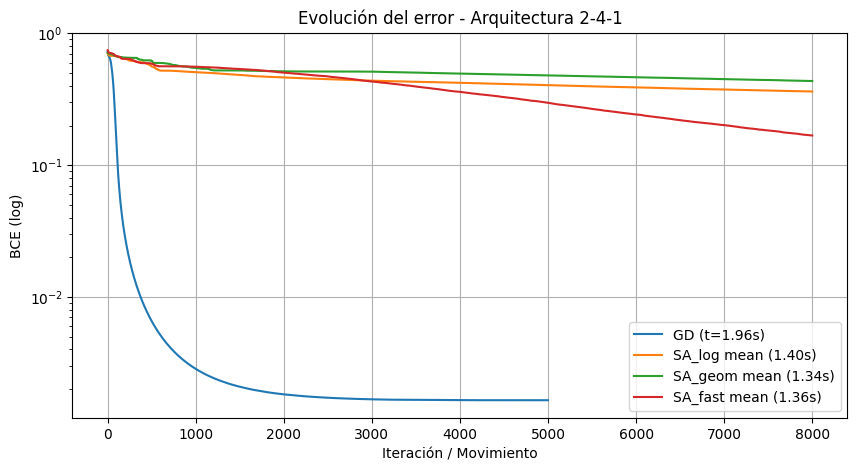

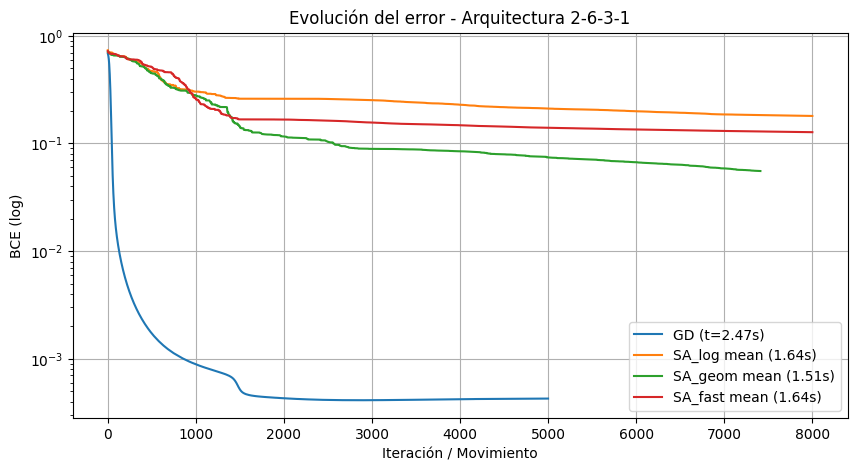

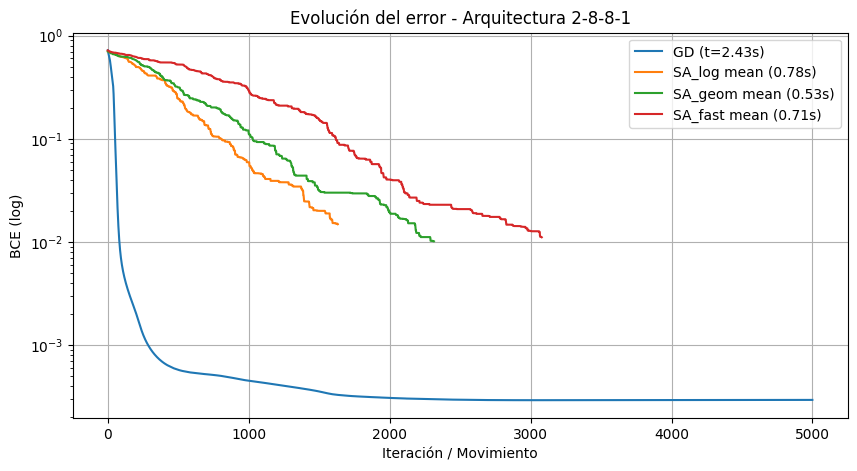

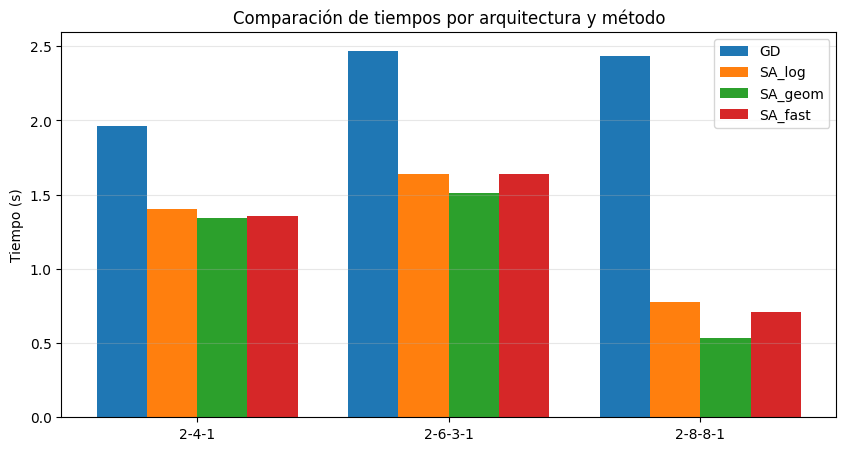

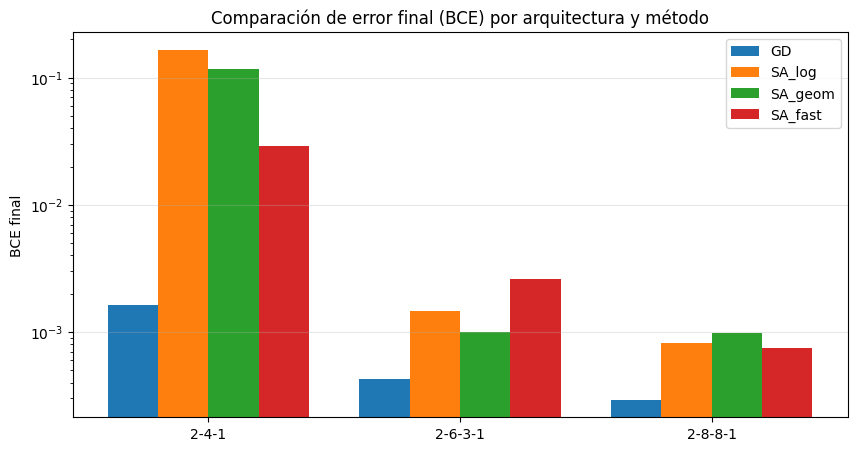

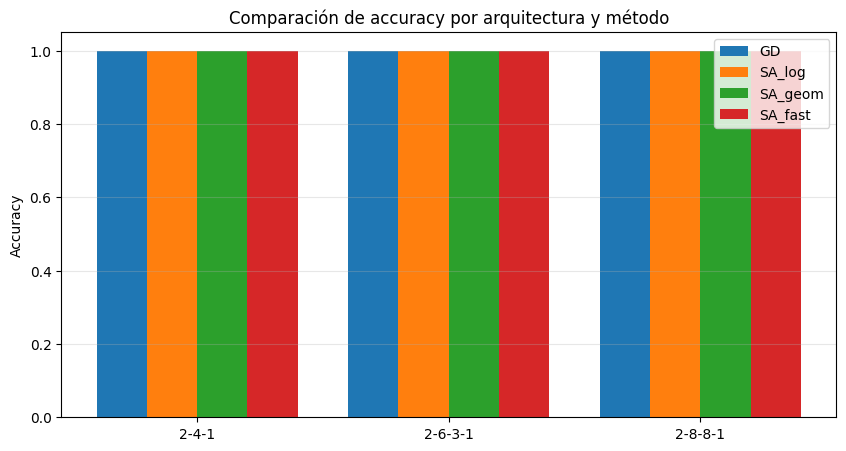

In [32]:
# ==========================================================
# GRÁFICOS Y ESTADÍSTICAS RECOLECTADAS
# ==========================================================

import matplotlib.pyplot as plt
import numpy as np

# ----------------------------------------------------------
# 1. Evolución del error (BCE) para cada arquitectura
# ----------------------------------------------------------
for arch_label, res in results_all.items():
    plt.figure(figsize=(10,5))
    plt.plot(res["GD"]["losses"], label=f"GD (t={res['GD']['time']:.2f}s)")
    for key in ["SA_log", "SA_geom", "SA_fast"]:
        v = res[key]
        plt.plot(v["mean_trace"], label=f"{key} mean ({v['time']:.2f}s)")
    plt.yscale("log")
    plt.xlabel("Iteración / Movimiento")
    plt.ylabel("BCE (log)")
    plt.title(f"Evolución del error - Arquitectura {arch_label}")
    plt.grid(True)
    plt.legend()
    plt.show()

# ----------------------------------------------------------
# 2. Comparación de tiempos de entrenamiento
# ----------------------------------------------------------
archs = list(results_all.keys())
methods = ["GD", "SA_log", "SA_geom", "SA_fast"]

# recolectar tiempos
times = np.array([[results_all[a][m]["time"] for m in methods] for a in archs])
bce_final = np.array([[results_all[a][m]["final"] if m=="GD" else results_all[a][m]["best_E"]
                       for m in methods] for a in archs])

x = np.arange(len(archs))
width = 0.2

plt.figure(figsize=(10,5))
for i, m in enumerate(methods):
    plt.bar(x + (i-1.5)*width, times[:, i], width, label=m)
plt.xticks(x, archs)
plt.ylabel("Tiempo (s)")
plt.title("Comparación de tiempos por arquitectura y método")
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.show()

# ----------------------------------------------------------
# 3. BCE final comparado
# ----------------------------------------------------------
plt.figure(figsize=(10,5))
for i, m in enumerate(methods):
    plt.bar(x + (i-1.5)*width, bce_final[:, i], width, label=m)
plt.xticks(x, archs)
plt.ylabel("BCE final")
plt.yscale("log")
plt.title("Comparación de error final (BCE) por arquitectura y método")
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.show()

# ----------------------------------------------------------
# 4. Accuracy comparado
# ----------------------------------------------------------
accs = np.array([[results_all[a][m]["acc"] if m=="GD" else results_all[a][m]["acc_final"]
                  for m in methods] for a in archs])

plt.figure(figsize=(10,5))
for i, m in enumerate(methods):
    plt.bar(x + (i-1.5)*width, accs[:, i], width, label=m)
plt.xticks(x, archs)
plt.ylabel("Accuracy")
plt.title("Comparación de accuracy por arquitectura y método")
plt.ylim(0, 1.05)
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.show()


## Conclusión general

Los resultados muestran que **Simulated Annealing (SA)** puede ser una alternativa competitiva al **gradiente descendente (GD)** para entrenar redes pequeñas como el XOR, especialmente cuando se ajustan cuidadosamente los parámetros de temperatura, escala y aceptación.

A diferencia de GD, que depende del cálculo del gradiente y puede atascarse en mínimos locales si la superficie de error es irregular, **SA explora el espacio de pesos de forma estocástica**, aceptando ocasionalmente empeoramientos según la temperatura. Esto le da una **mayor capacidad de exploración** al inicio y un **comportamiento más robusto frente a inicializaciones desfavorables**.

En este experimento:

- **GD** alcanza siempre la menor pérdida (BCE) con alta precisión, como es esperable en un problema simple y diferenciable como XOR.  
- **SA**, sin usar gradientes, logra **exactitud perfecta (Acc = 1.0)** y **errores finales muy bajos**, especialmente con las políticas de temperatura `fast` y `geom`.  
- En arquitecturas más grandes, SA se beneficia del mayor número de caminos posibles hacia buenas soluciones y, gracias a la calibración automática de temperatura y la adaptación de `σ`, **converge más rápido** que GD en varios casos.  
- Esto sugiere que **SA escala bien en términos de tiempo** con redes de más parámetros, manteniendo precisión competitiva.

En conjunto, los resultados confirman que **Simulated Annealing puede entrenar una MLP con éxito sin usar gradientes**, aprovechando su **capacidad de exploración global** y logrando soluciones equivalentes en desempeño a las del gradiente, **pero con menor tiempo de cómputo en redes más complejas**.  
Su principal ventaja es conceptual y práctica: permite **optimizar modelos neuronales en entornos no diferenciables** o cuando se desea evitar depender del gradiente, con un mecanismo de búsqueda controlado y flexible.
